This notebook determines the recovery rates of discharge events for icpc detector types.

**Contents:**

**Section 1:** Extracts all the discharge events. This process has previously been conducted in the notebook `CUTS.ipynb`.

**Section 2:** This section calculates the recovery rates, similar to `RECOVERY_RATES_DETECTORS.ipynb` with one if statement difference.

In [1]:
import pygama
import pygama.lh5 as lh5
import matplotlib.pyplot as plt
import numpy as np
import h5py
from pygama.dsp.processors import pole_zero
plt.rcParams['figure.figsize'] = [10, 10]
import json
from scipy.stats import zscore
from scipy.optimize import curve_fit

## Section 1

In [2]:
new_raw = f'/unix/legend/wquinn/discharges/raw_files/ '
sto = lh5.Store() # we require this to read 
fw_new1=f'/unix/legend/wquinn/discharges/raw_files/l200-p06-r007-tst-20230726T004658Z_tier_raw.lh5'

In [3]:
f = open('channel_maps.json','r')
cmap = json.load(f)

In [4]:
target_bege = "icpc"

matching_bege = [key for key, value in cmap.items() if "type" in value and value["type"] == target_bege]

In [5]:
ch = "ch"

detectors_bege = [ch+element for element in matching_bege]

In [6]:
tb_data_dict = {}  
wfs_all_dict = {}  

for j in detectors_bege:
    tb_data_dict[j] = sto.read_object(f'/{j}/raw', fw_new1)[0]
    wfs_all_dict[j] = tb_data_dict[j]['waveform']['values'].nda

In [7]:
def minimum_values(wfs_all_dict,index):
    """ Determines the minimum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    min_values - minimum values 
    """
    wfs_all = wfs_all_dict[index]

    min_values = []
    
    for i in range(len(wfs_all)):
        wf0 = wfs_all[i, :]
        wf_min = np.min(wf0)
        min_values.append(wf_min)
    return min_values

In [8]:
minimum_dict={}
for j in detectors_bege:
    minimum_dict[j]=minimum_values(wfs_all_dict,j) 

In [9]:
def zcalc(zscore_threshold,min_values):
    """ Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    min_values - the values to be used in the z-score
    Outputs:
    filtered_min_values - values which are within the zscore threshold
    skipped_min_values - values which are outside the zscore threshold
    index_skip - the waveforms which are outside the zscore threshold
    index_filter - the waveforms which are inside the zscore threshold
    """
    min_z_scores = zscore(min_values)
    
    filtered_min_values = []
    skipped_min_values= []
    index_skip = []
    index_filter = []
    
    for i, z_score in enumerate(min_z_scores):
        if z_score < -zscore_threshold:
            skipped_min_values.append(min_values[i])
            index_skip.append(i)
            continue
        
        filtered_min_values.append(min_values[i])
        index_filter.append(i)
    return filtered_min_values,skipped_min_values,index_skip,index_filter

In [10]:
threshold = 1
filtered_values ={}
skipped_values = {}
skipped_index = {}
filtered_index = {}

for j in detectors_bege:
    filtered_values[j],skipped_values[j],skipped_index[j],filtered_index[j]=zcalc(threshold,minimum_dict[j])

In [11]:
def maximum_values(wfs_all_dict,index):
    """Determines the maximum values of 
    a waveform.
    Inputs:
    wfs_all_dict - the dictionary storing all waveforms 
    index - the name of the detector, to extract waveforms
    from the waveform dictionary
    Ouputs:
    max_values - maximum values 
    """
    wfs_all = wfs_all_dict[index]
    index_skip = skipped_index[index]
    
    max_values = []
    
    for i in index_skip:
        wf0 = wfs_all[i, :]
        wf_max = np.max(wf0)
        max_values.append(wf_max)
    
    return max_values

In [12]:
maximum_dict={}

for j in detectors_bege:
    maximum_dict[j]=maximum_values(wfs_all_dict,j)

In [13]:
def zcalc_max(zscore_threshold,maximum_values,index):
    """Filters values depending on their z-score
    by their distance from the threshold.
    Inputs:
    zscore_threshold - threshold to extract values above/
    below 
    maximum_values - the values to be used in the z-score
    index - detector index for previous dictionaries
    Outputs:
    filtered_max_values - values which are within the zscore threshold
    skipped_max_values - values which are outside the zscore threshold
    index_skipm - the waveforms which are outside the zscore threshold
    index_filterm - the waveforms which are inside the zscore threshold
    """
    max_z_scores = zscore(maximum_values)
    index_skip = skipped_index[index]
    max_values = maximum_dict[index]

    filtered_max_values = []
    skipped_max_values = []
    index_skipm = []
    index_filterm = []
    
    for i, z_score in enumerate(max_z_scores):
        if abs(z_score) > zscore_threshold:
            skipped_max_values.append(max_values[i])
            index_skipm.append(index_skip[i])
            continue
        
        filtered_max_values.append(max_values[i])
        index_filterm.append(index_skip[i])
    
    return filtered_max_values,skipped_max_values,index_skipm,index_filterm

In [14]:
threshold =1 #one standard deviation 
filtered_max_values = {}
skipped_max_values = {}
index_skipm = {}
index_filterm = {}


for j in detectors_bege:
    if len(maximum_dict[j])>20:
        filtered_max_values[j],skipped_max_values[j],index_skipm[j],index_filterm[j]=zcalc_max(threshold,maximum_dict[j],j)
    else:
        index_skipm[j]=skipped_index[j]   

Skipped waveforms for detector ch1104000: [77, 179, 725, 908]
Percentage of discharges present: 0.283286118980175%


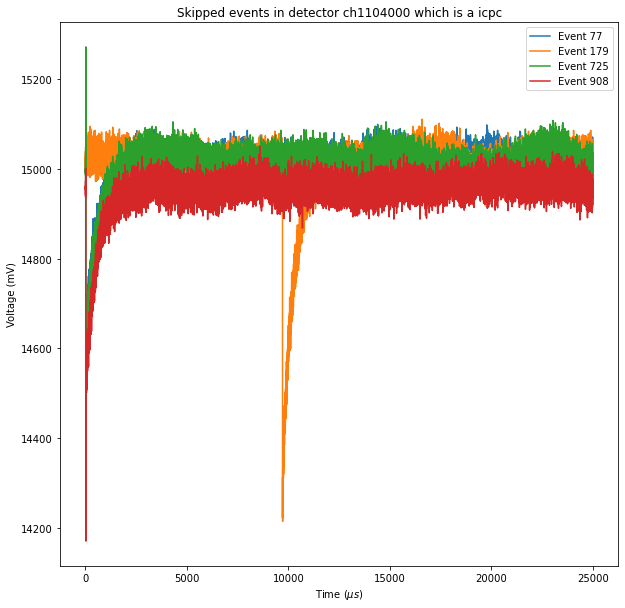

Skipped waveforms for detector ch1104001: [77, 725, 908, 925]
Percentage of discharges present: 0.283286118980175%


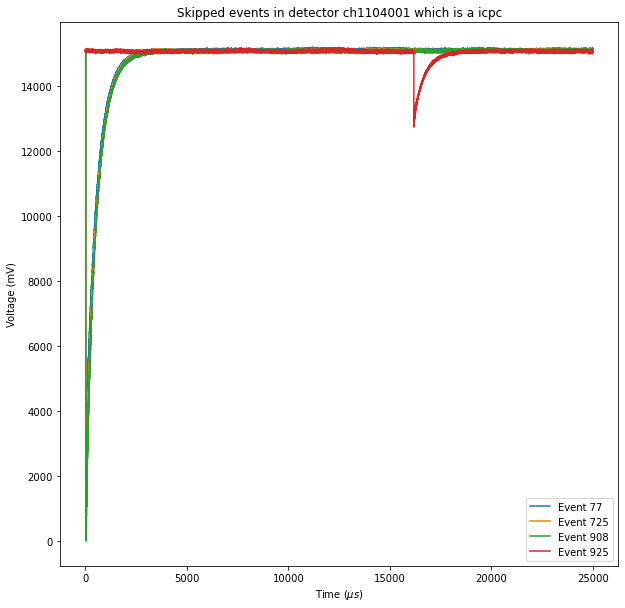

Skipped waveforms for detector ch1104002: [1338]
Percentage of discharges present: 0.07082152974504652%


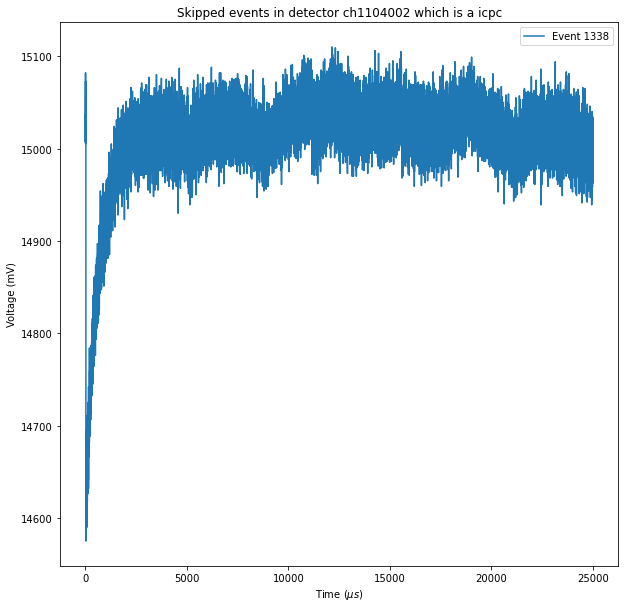

Skipped waveforms for detector ch1104003: [464, 1043, 1338]
Percentage of discharges present: 0.21246458923512845%


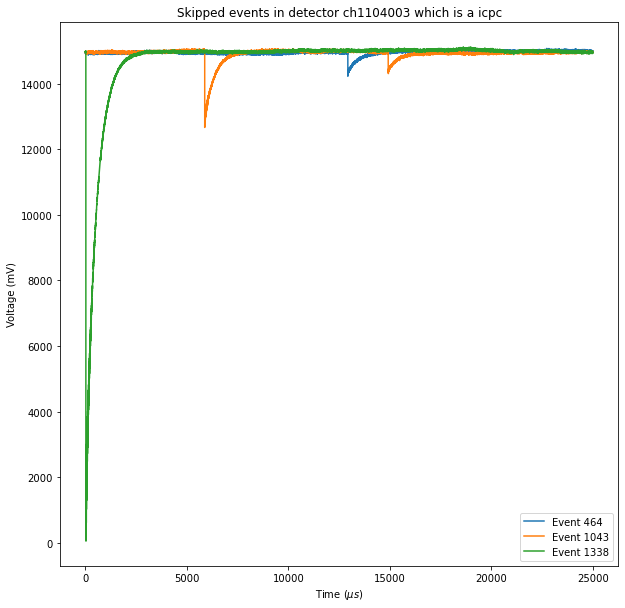

Skipped waveforms for detector ch1104004: [165]
Percentage of discharges present: 0.07082152974504652%


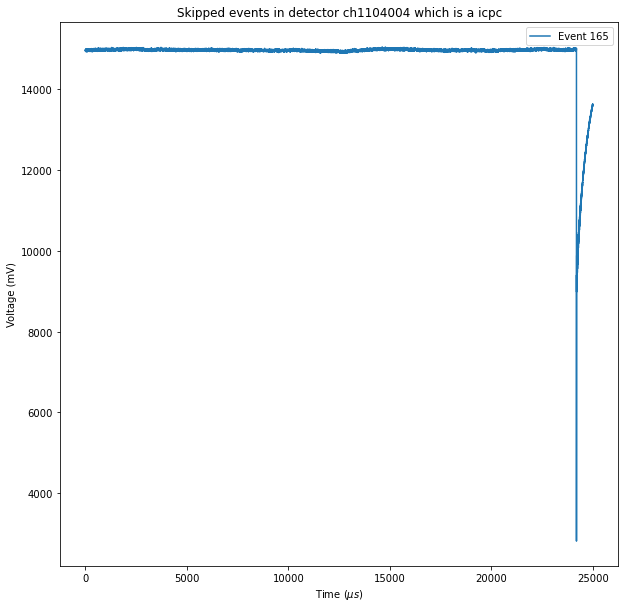

This detector ch1104005 doesn't have any discharges
Skipped waveforms for detector ch1105600: [302, 855]
Percentage of discharges present: 0.14164305949008194%


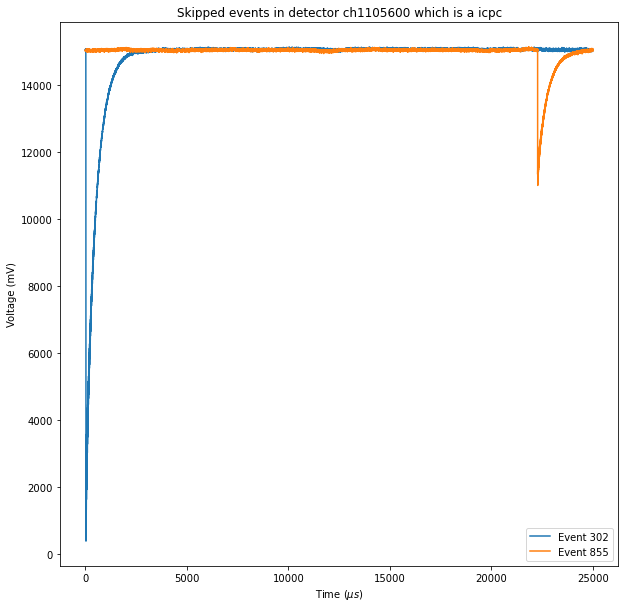

Skipped waveforms for detector ch1105602: [117, 165]
Percentage of discharges present: 0.14164305949008194%


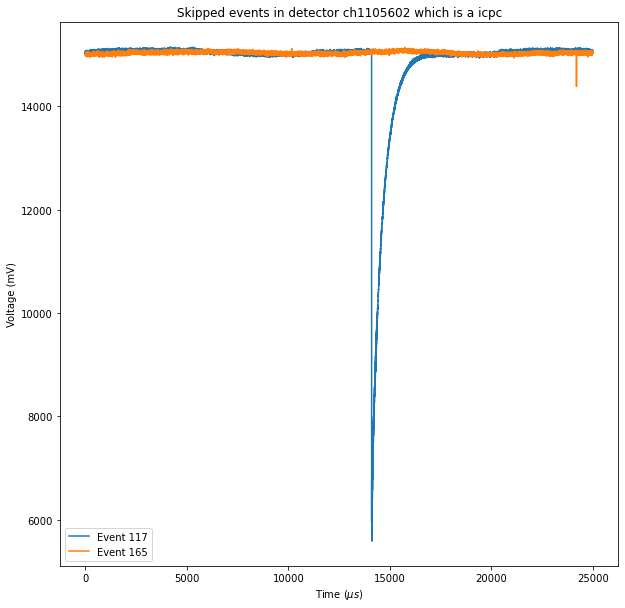

This detector ch1105603 doesn't have any discharges
Skipped waveforms for detector ch1108802: [643, 672]
Percentage of discharges present: 0.14164305949008194%


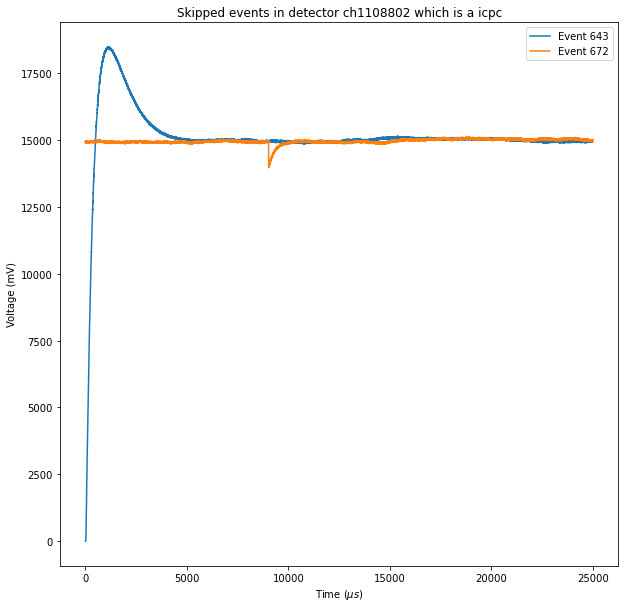

Skipped waveforms for detector ch1108803: [918]
Percentage of discharges present: 0.07082152974504652%


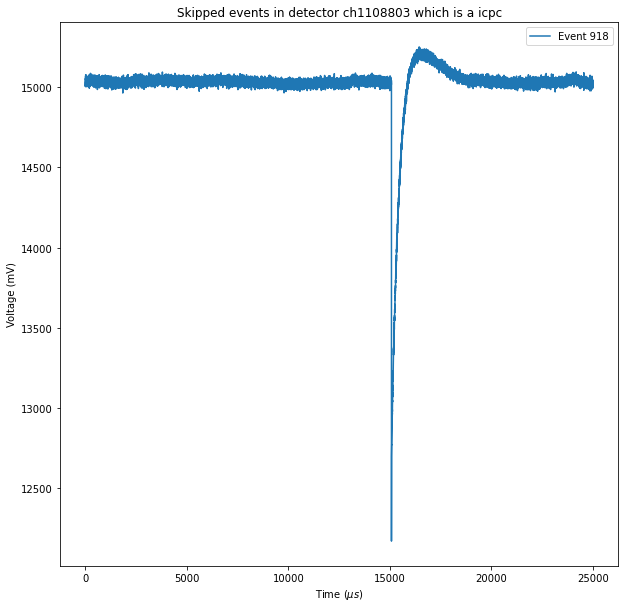

This detector ch1108804 doesn't have any discharges
This detector ch1115200 doesn't have any discharges
Skipped waveforms for detector ch1115201: [233, 1329]
Percentage of discharges present: 0.14164305949008194%


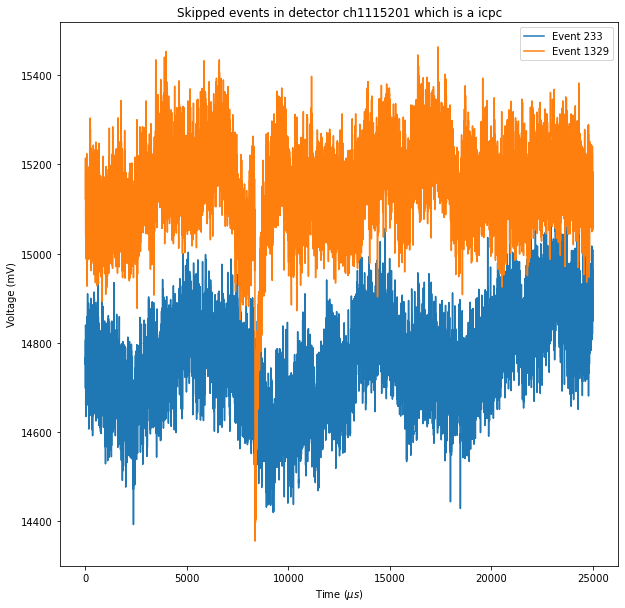

Skipped waveforms for detector ch1115202: [5, 60, 90, 151, 180, 215, 270, 281, 289, 829, 944, 1329]
Percentage of discharges present: 0.8498583569405138%


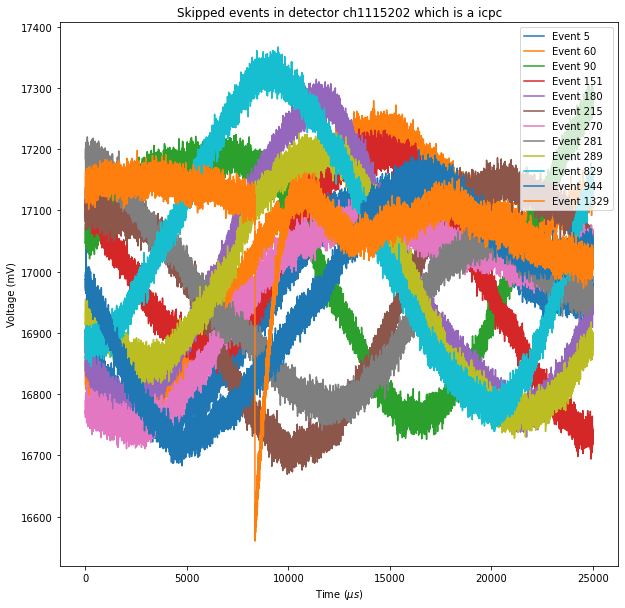

This detector ch1115203 doesn't have any discharges
This detector ch1115204 doesn't have any discharges
Skipped waveforms for detector ch1116801: [20, 32, 710]
Percentage of discharges present: 0.21246458923512845%


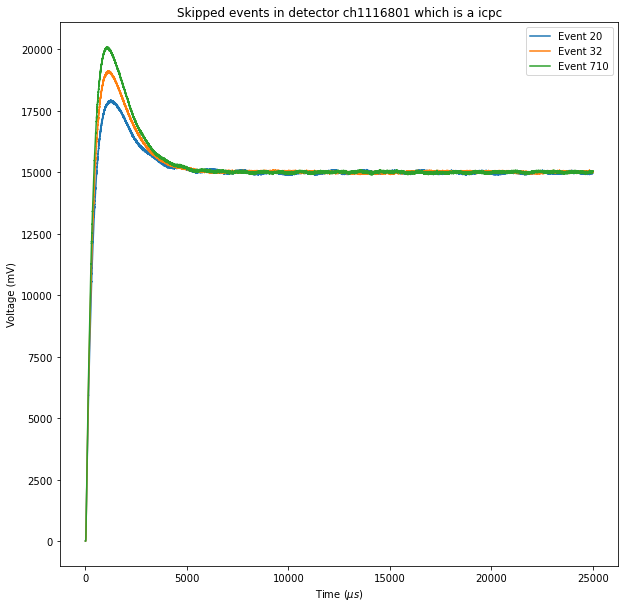

This detector ch1116802 doesn't have any discharges
Skipped waveforms for detector ch1116803: [120, 143, 495, 774, 943, 1189, 1270]
Percentage of discharges present: 0.4957507082152923%


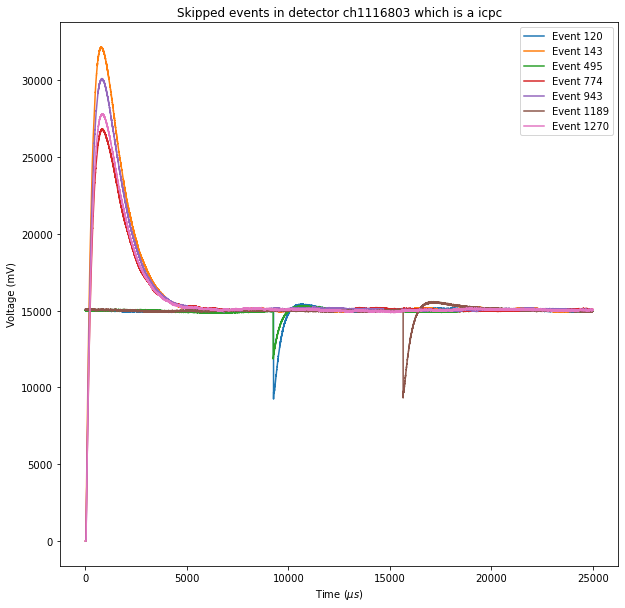

Skipped waveforms for detector ch1116804: [52, 137, 247, 353, 400, 628, 676, 718, 733, 1126, 1131, 1180]
Percentage of discharges present: 0.8498583569405138%


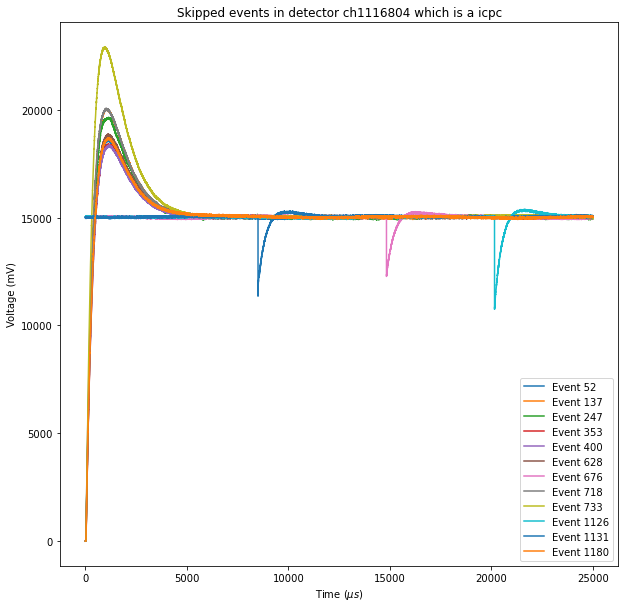

Skipped waveforms for detector ch1116805: [474, 995]
Percentage of discharges present: 0.14164305949008194%


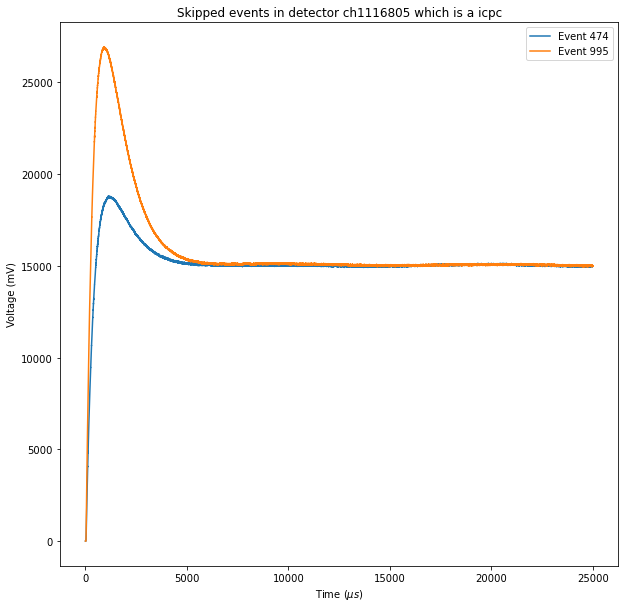

Skipped waveforms for detector ch1118402: [261, 279, 283, 400, 690, 852, 996, 1292]
Percentage of discharges present: 0.5665722379603388%


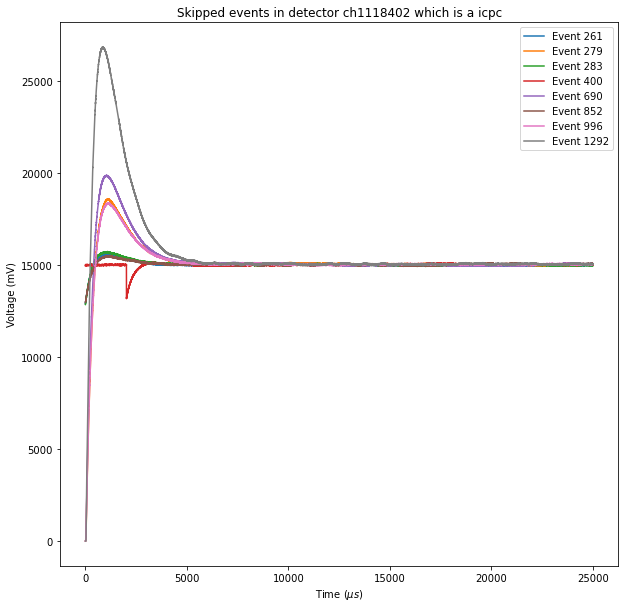

Skipped waveforms for detector ch1118403: [261, 283, 852, 1327]
Percentage of discharges present: 0.283286118980175%


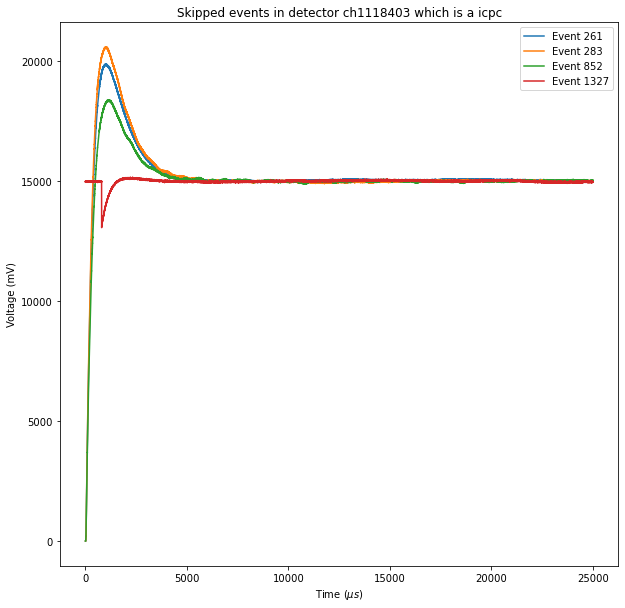

Skipped waveforms for detector ch1118404: [136, 169, 659, 1325]
Percentage of discharges present: 0.283286118980175%


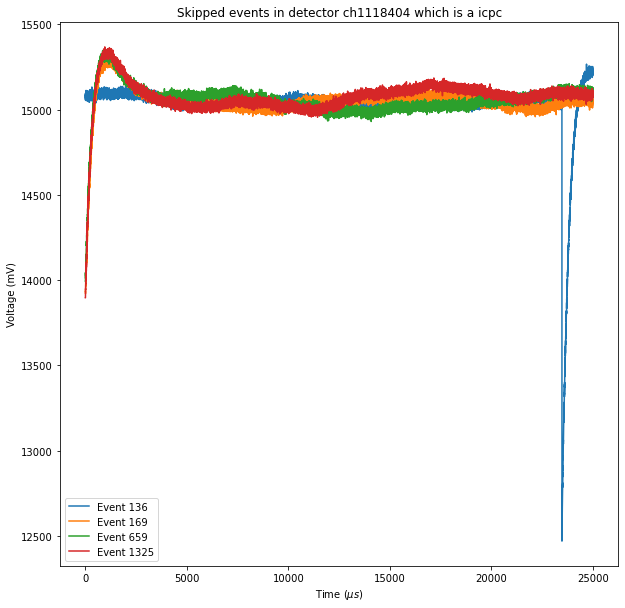

This detector ch1118405 doesn't have any discharges
Skipped waveforms for detector ch1120000: [47, 324, 501, 954, 1000, 1085, 1096, 1107, 1342]
Percentage of discharges present: 0.6373937677053854%


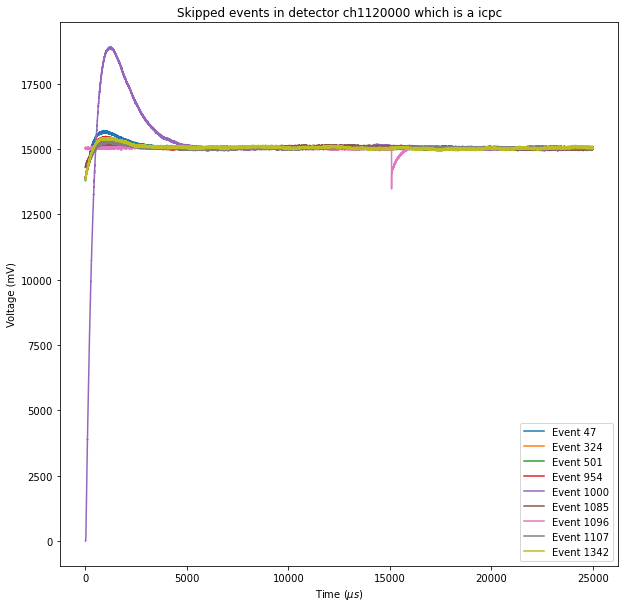

Skipped waveforms for detector ch1120001: [41, 47, 324, 433, 501, 954, 1096, 1107, 1336, 1342]
Percentage of discharges present: 0.7082152974504208%


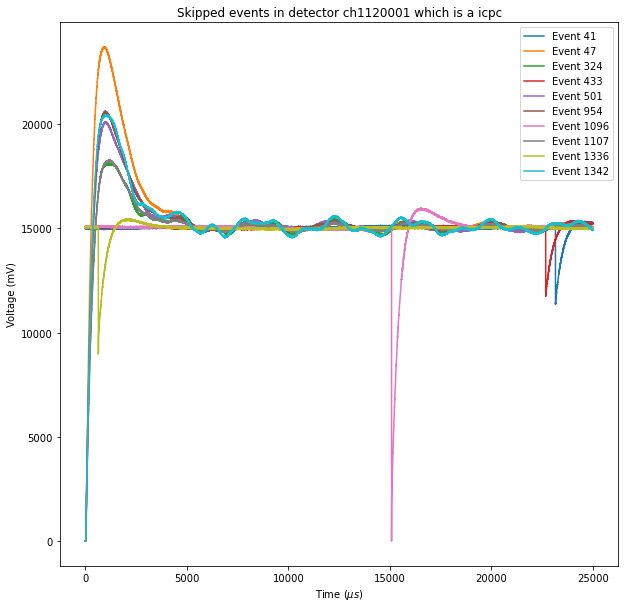

Skipped waveforms for detector ch1120002: [799, 1096, 1151]
Percentage of discharges present: 0.21246458923512845%


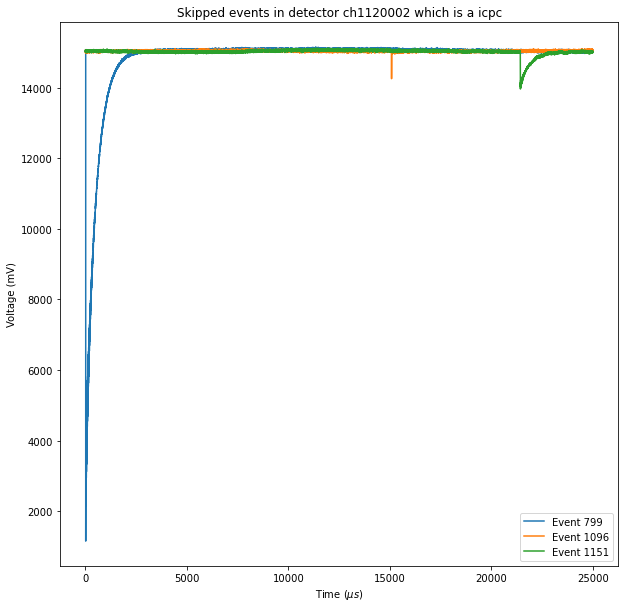

Skipped waveforms for detector ch1121600: [59, 436, 499, 562, 675, 789, 909, 1009, 1099]
Percentage of discharges present: 0.6373937677053854%


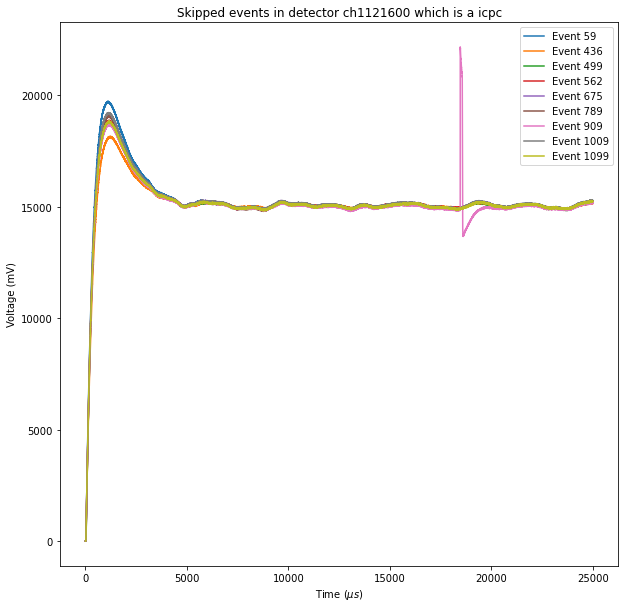

Skipped waveforms for detector ch1121601: [240, 931, 1234, 1363]
Percentage of discharges present: 0.283286118980175%


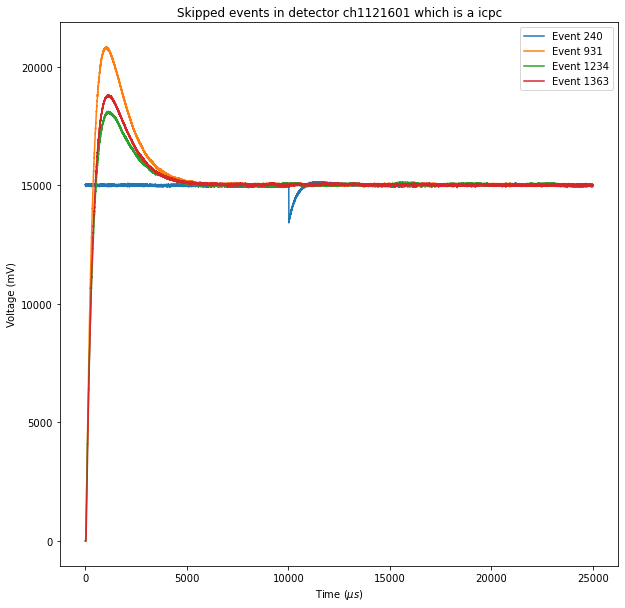

Skipped waveforms for detector ch1121602: [931, 1234, 1363]
Percentage of discharges present: 0.21246458923512845%


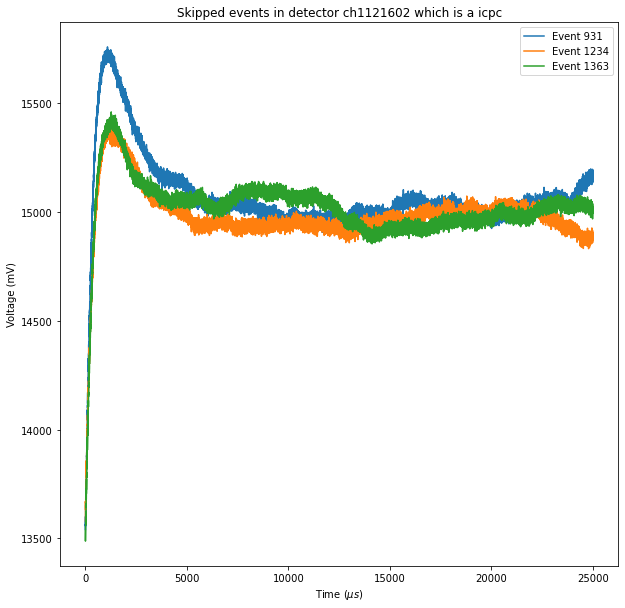

This detector ch1121603 doesn't have any discharges
Skipped waveforms for detector ch1121604: [885]
Percentage of discharges present: 0.07082152974504652%


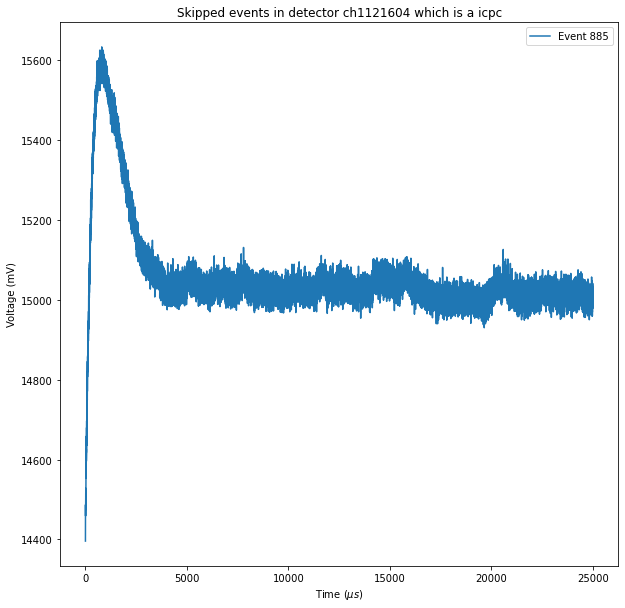

Skipped waveforms for detector ch1121605: [757, 885]
Percentage of discharges present: 0.14164305949008194%


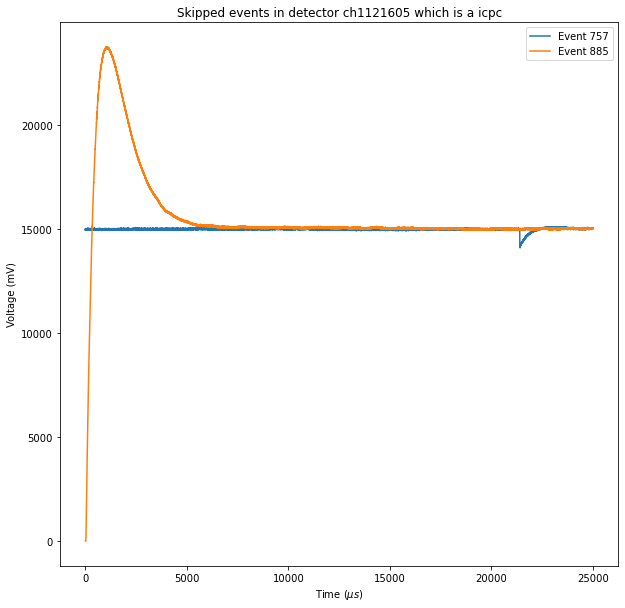

This detector ch1078400 doesn't have any discharges
Skipped waveforms for detector ch1084803: [474, 495]
Percentage of discharges present: 0.14164305949008194%


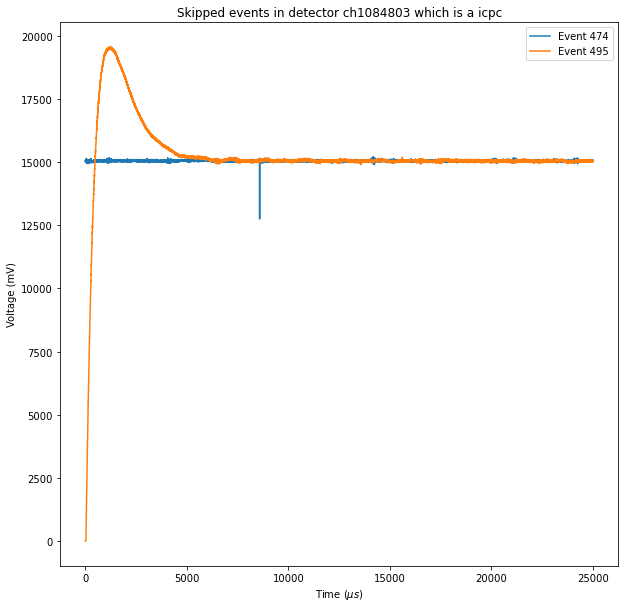

This detector ch1084804 doesn't have any discharges
Skipped waveforms for detector ch1084805: [474, 625]
Percentage of discharges present: 0.14164305949008194%


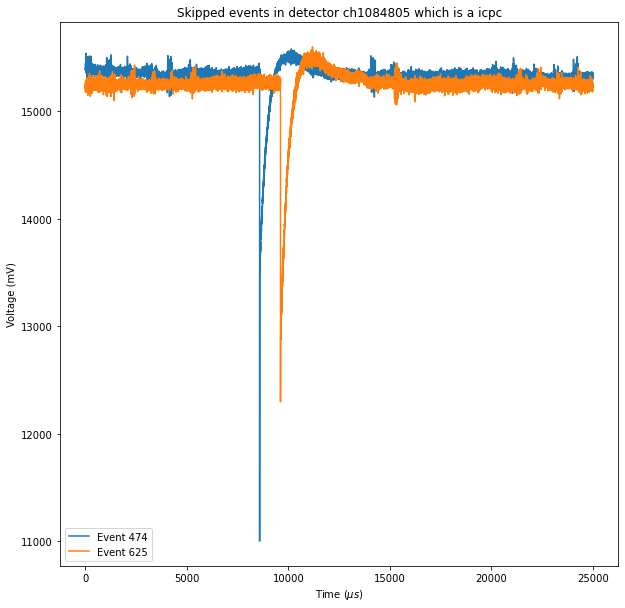

Skipped waveforms for detector ch1086400: [103, 205, 474, 629, 707, 1093]
Percentage of discharges present: 0.4249291784702569%


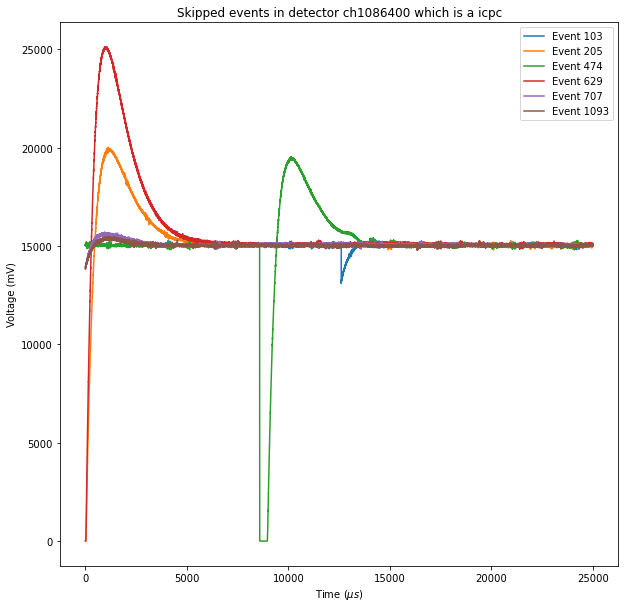

Skipped waveforms for detector ch1086401: [194, 340, 474, 515, 707, 722, 1093]
Percentage of discharges present: 0.4957507082152923%


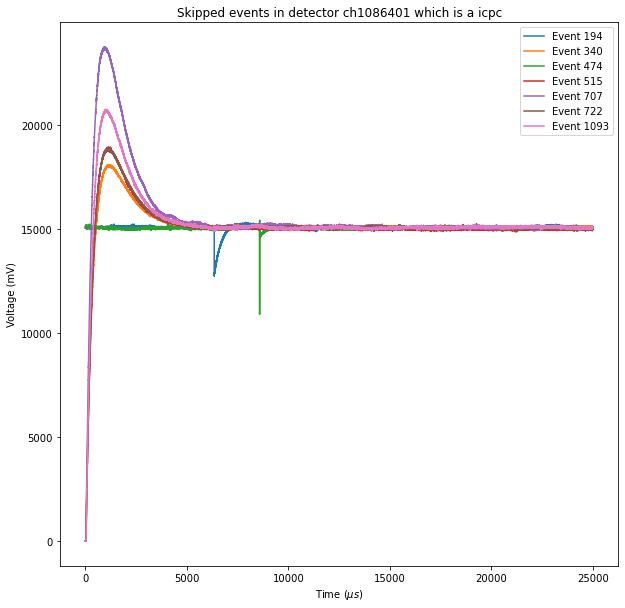

In [15]:
percent_discharge = {}
skipped_waveforms = {}
maxima_skipped = []
skipped_index1 = []
detectors_with_discharges=[]
for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]

    if len(index_skip1) < 20:
        skipped_waveforms[j] = index_skip1 
        print(f"Skipped waveforms for detector {j}: {index_skip1}")

        for i in index_skip1:
            maxima_skipped.append(np.max(wfs_all))
            skipped_index1.append(i)
            wf0 = wfs_all[i, :]
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            x = j[2:]
            test = cmap[x]['type']
            detectors_with_discharges.append(j)

            plt.plot(ts[:], wf0[:], label=f'Event {i}') 

        # Customize plot
        #plt.xlabel('Time ($\mu s$)')
        #plt.ylabel('Voltage (mV)')
        #plt.title(f'Skipped events in detector {j} which is a {test}')
        #plt.legend()

        diff = len(minimum_dict[j]) - len(index_skip1)
        percentage = (1 - (diff / len(minimum_dict[j]))) * 100
        percent_discharge[j] = percentage
        print(f"Percentage of discharges present: {percentage}%")
        #plt.show()
    else:
        print(f"This detector {j} doesn't have any discharges")

Another selection criteria which states that if the size of the skipped indices is larger than 20, after the 2 cuts, this suggests we have no discharges.

## Section 2

recovery rate -52.0s
MICRODISCHARGE
Maximum difference: 10.4, 1127.2
Next Maximum difference: 1179.2, 1240.8000000000002


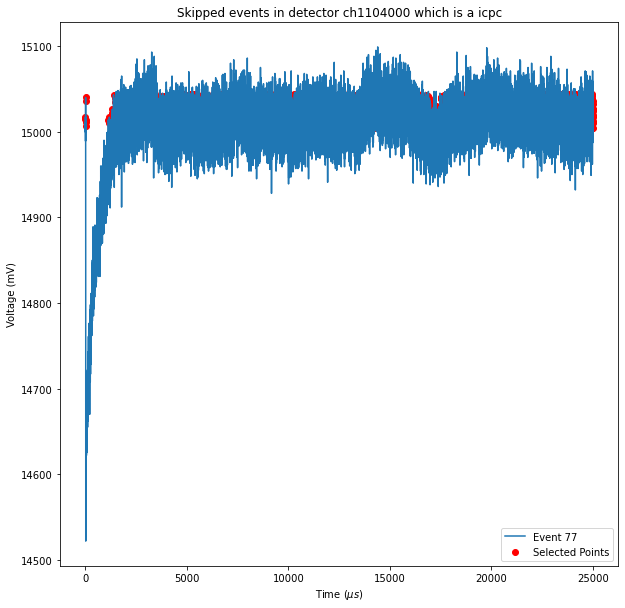

recovery rate -33.599999999998545s
MICRODISCHARGE
Maximum difference: 9711.2, 11118.400000000001
Next Maximum difference: 11152.0, 11198.400000000001


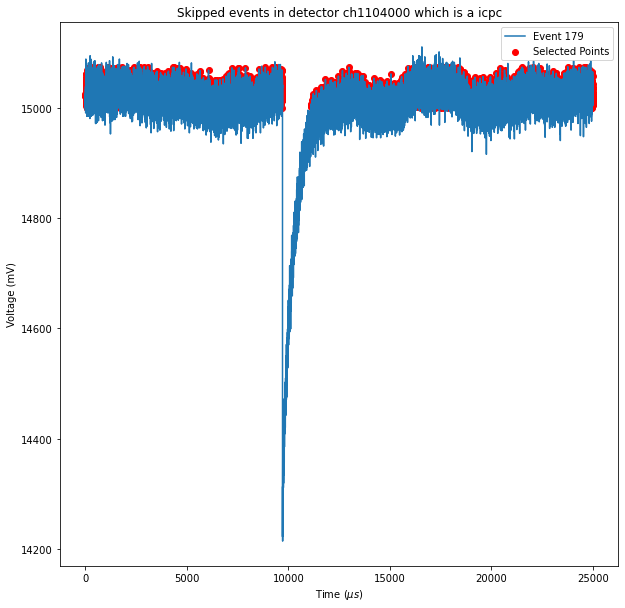

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 17.6, 1084.0
Next Maximum difference: 1084.0, 1251.2


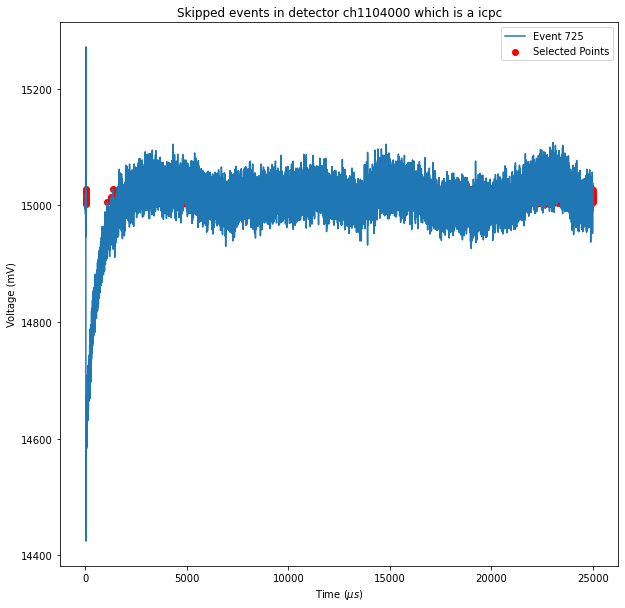

recovery rate -8005.6s
MICRODISCHARGE
Maximum difference: 19.200000000000003, 752.0
Next Maximum difference: 8757.6, 8828.800000000001


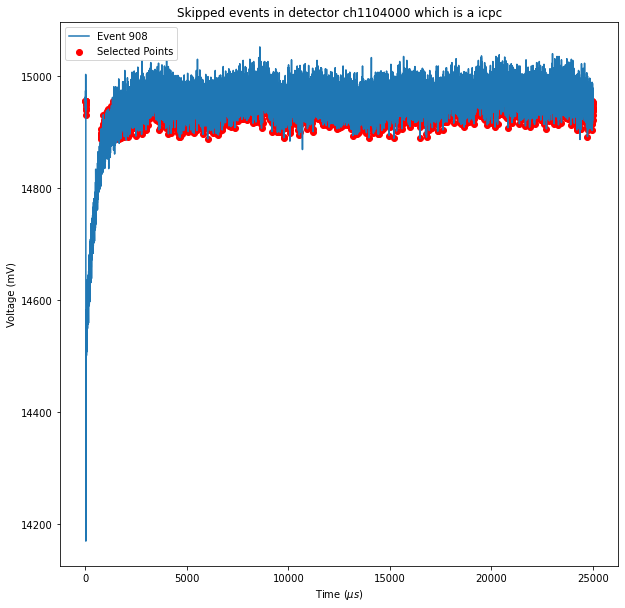

recovery rate -72.0s
MICRODISCHARGE
Maximum difference: 10.4, 2876.8
Next Maximum difference: 2948.8, 2994.4


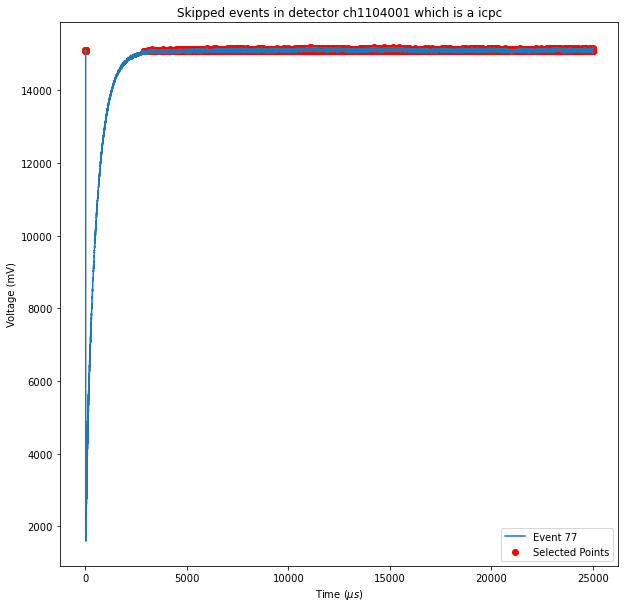

recovery rate -5.599999999999909s
MICRODISCHARGE
Maximum difference: 19.200000000000003, 2635.2000000000003
Next Maximum difference: 2640.8, 2689.6000000000004


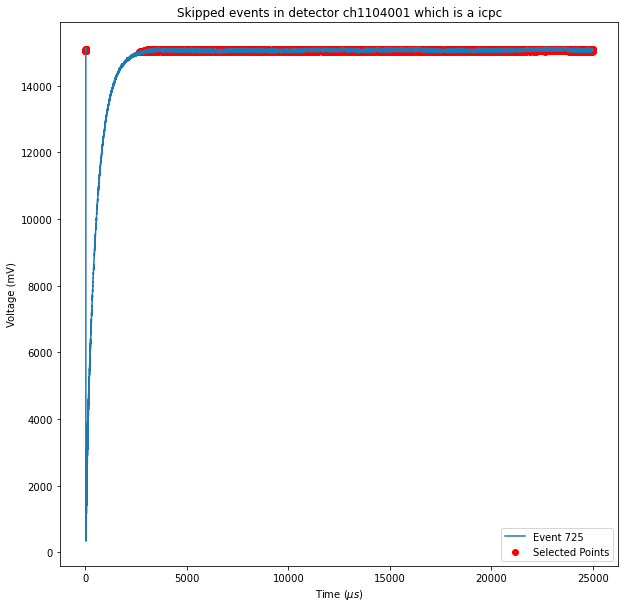

recovery rate -16887.2s
DISCHARGE
Maximum difference: 19.200000000000003, 2560.8
Next maximum difference: 19448.0, 19568.0


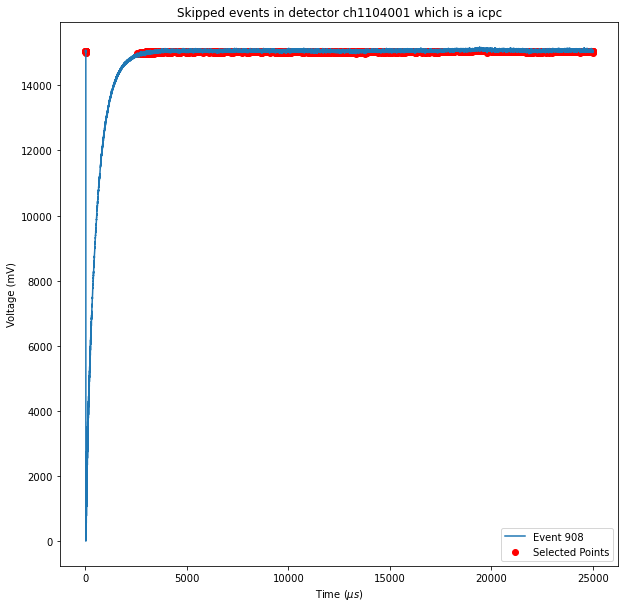

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 16184.0, 17890.4
Next Maximum difference: 17890.4, 17996.0


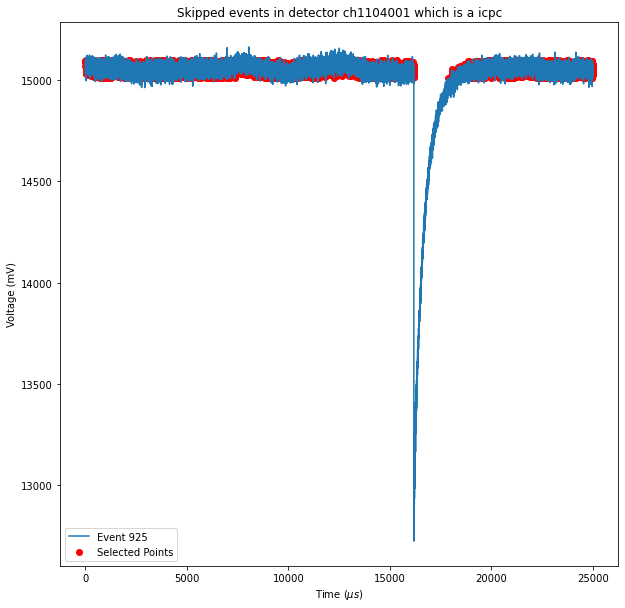

recovery rate -53.600000000000136s
MICRODISCHARGE
Maximum difference: 20.0, 1419.2
Next Maximum difference: 1472.8000000000002, 1514.4


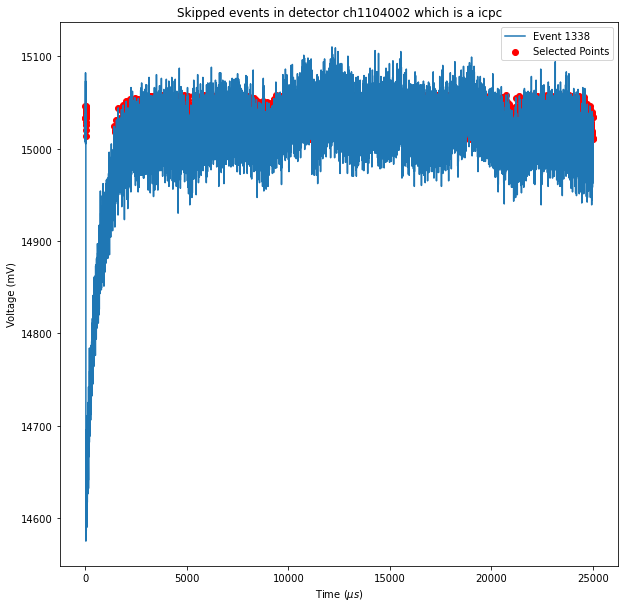

recovery rate 4817.6s
MICRODISCHARGE
Maximum difference: 12930.400000000001, 14248.0
Next Maximum difference: 9430.4, 9578.4


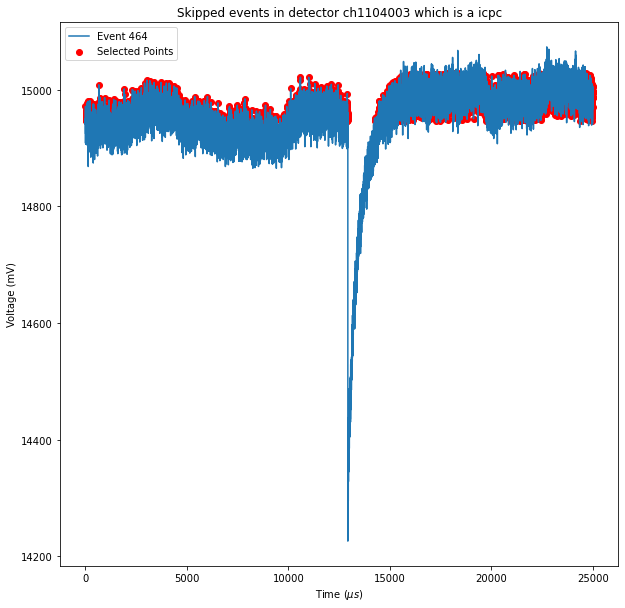

recovery rate -7732.800000000001s
MICRODISCHARGE
Maximum difference: 5876.0, 7188.0
Next Maximum difference: 14920.800000000001, 15911.2


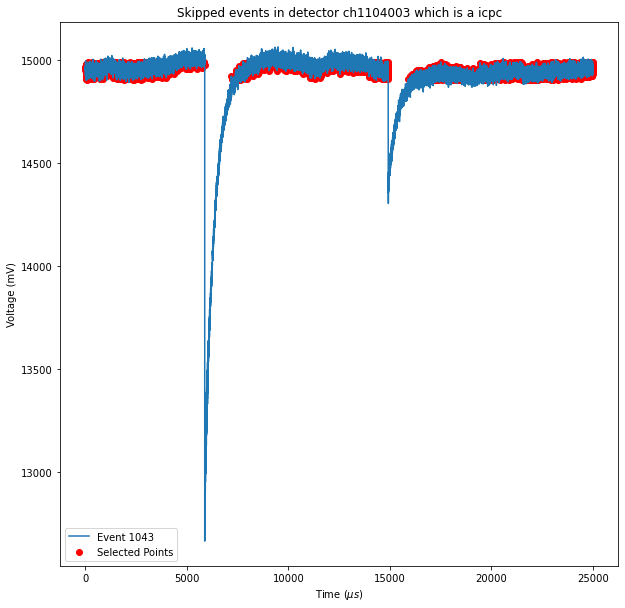

recovery rate -15792.8s
MICRODISCHARGE
Maximum difference: 20.0, 2328.0
Next Maximum difference: 18120.8, 19480.8


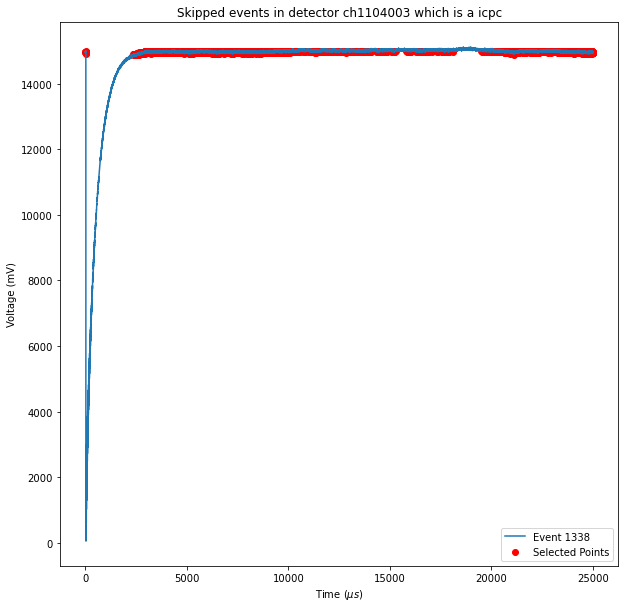

recovery rate 3.2000000000007276s
MICRODISCHARGE
Maximum difference: 24968.0, 24969.600000000002
Next Maximum difference: 24966.4, 24968.0


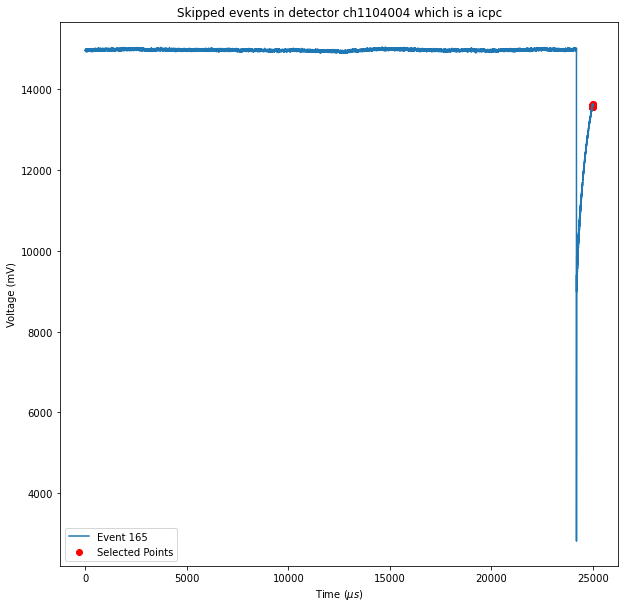

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 19.200000000000003, 2316.0
Next Maximum difference: 2316.0, 2362.4


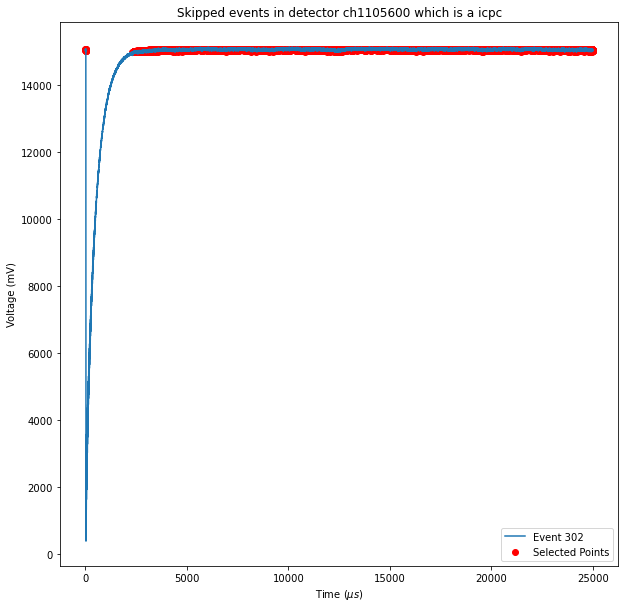

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 22284.0, 24265.600000000002
Next Maximum difference: 24265.600000000002, 24321.600000000002


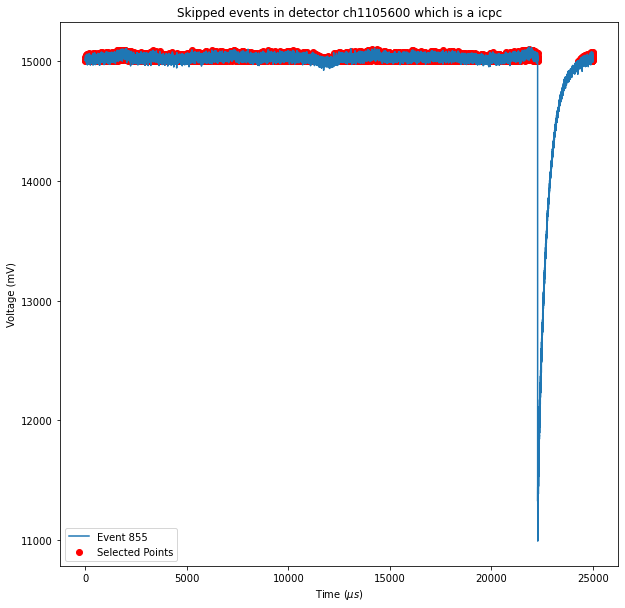

recovery rate -0.7999999999992724s
MICRODISCHARGE
Maximum difference: 14102.400000000001, 16547.2
Next Maximum difference: 16548.0, 16677.600000000002


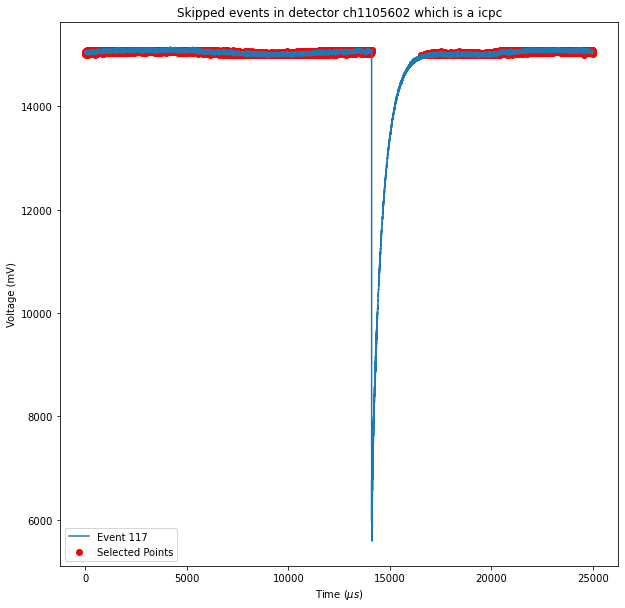

recovery rate -39.20000000000073s
MICRODISCHARGE
Maximum difference: 15452.0, 15647.2
Next Maximum difference: 15686.400000000001, 15833.6


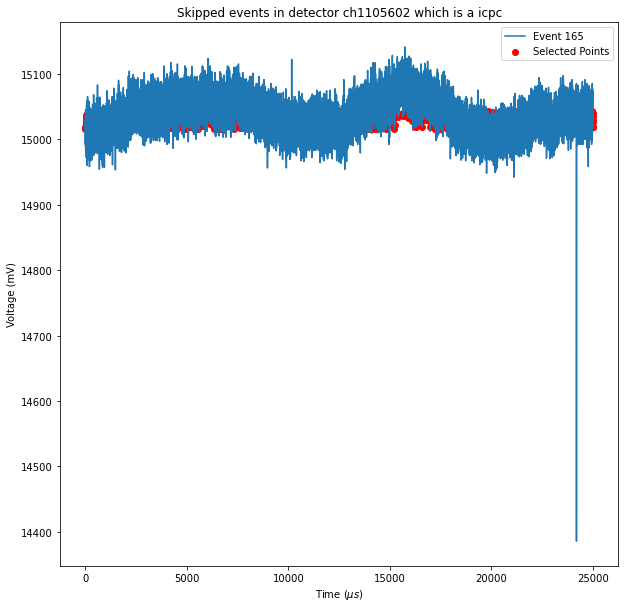

recovery rate 4458.400000000001s
DISCHARGE
Maximum difference: 499.20000000000005, 4458.400000000001
Next maximum difference: 10621.6, 10967.2


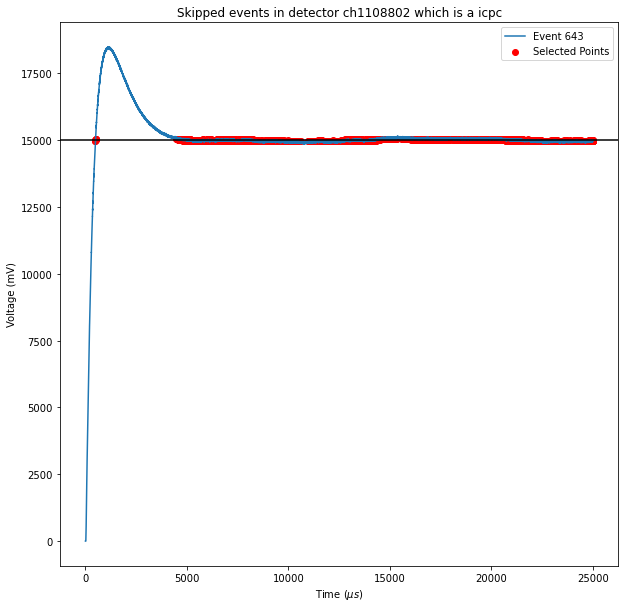

recovery rate 10915.2s
MICRODISCHARGE
Maximum difference: 18124.0, 19943.2
Next Maximum difference: 9028.0, 10044.800000000001


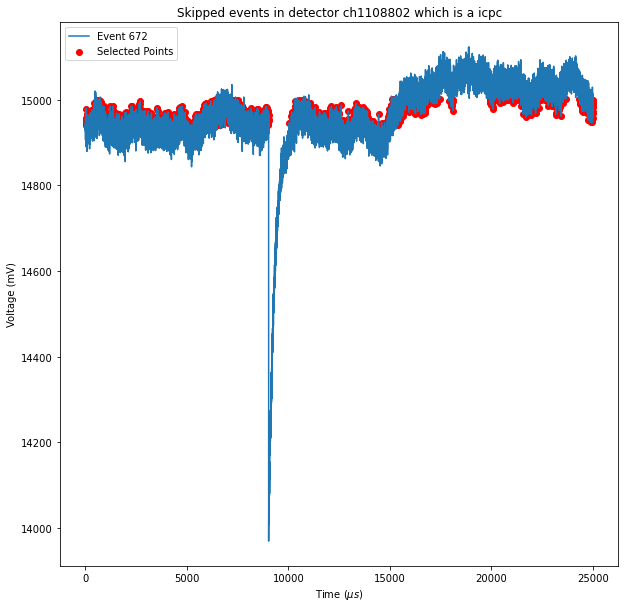

recovery rate 3246.3999999999996s
MICRODISCHARGE
Maximum difference: 15943.2, 18327.2
Next Maximum difference: 15080.800000000001, 15800.800000000001


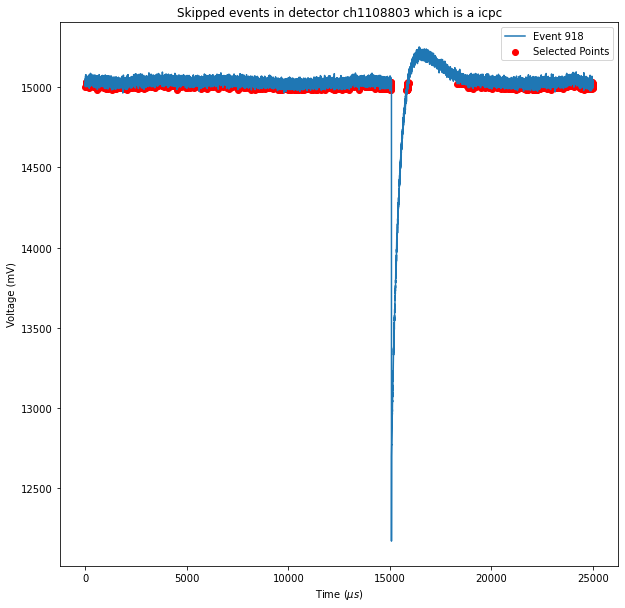

recovery rate 10819.2s
MICRODISCHARGE
Maximum difference: 8237.6, 10819.2
Next Maximum difference: 1404.8000000000002, 3113.6000000000004


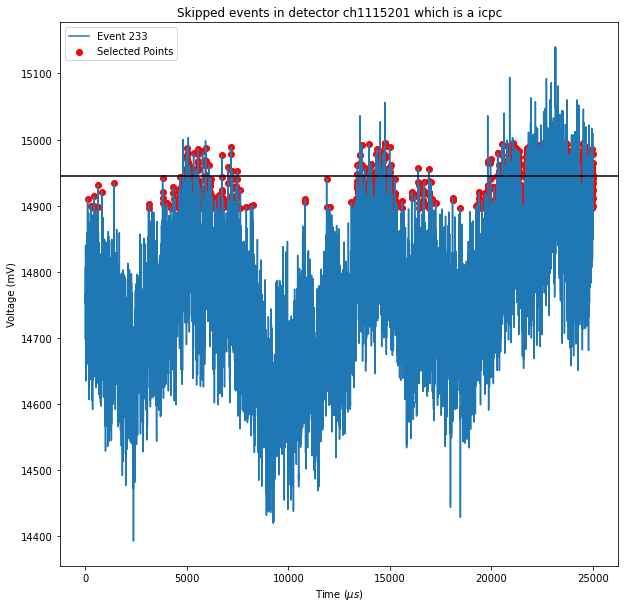

recovery rate 757.6000000000004s
MICRODISCHARGE
Maximum difference: 8332.0, 8701.6
Next Maximum difference: 7944.0, 8074.400000000001


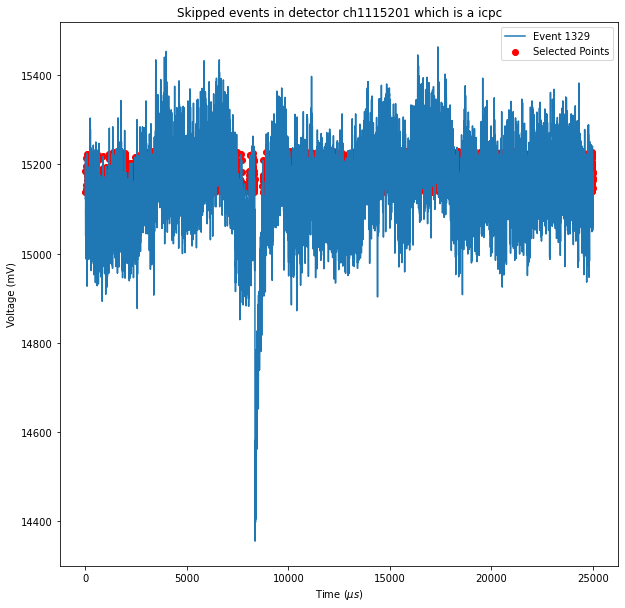

recovery rate 20433.600000000002s
MICRODISCHARGE
Maximum difference: 10592.0, 20783.2
Next Maximum difference: 349.6, 7538.400000000001


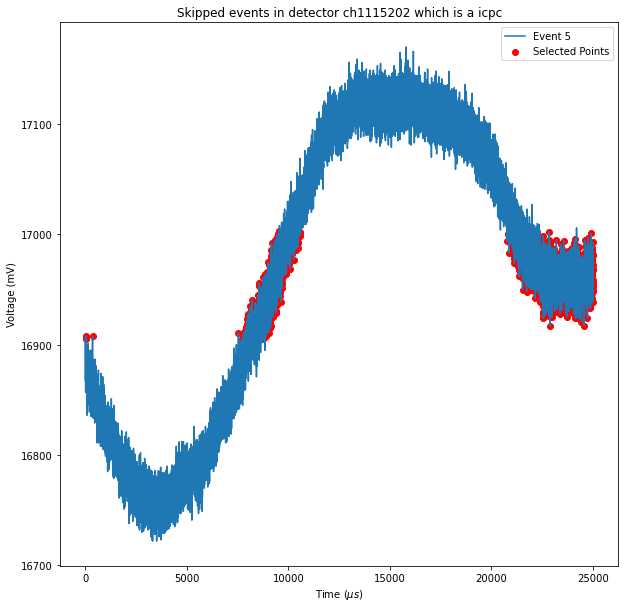

recovery rate 4221.6s
MICRODISCHARGE
Maximum difference: 12359.2, 16470.4
Next Maximum difference: 12248.800000000001, 12359.2


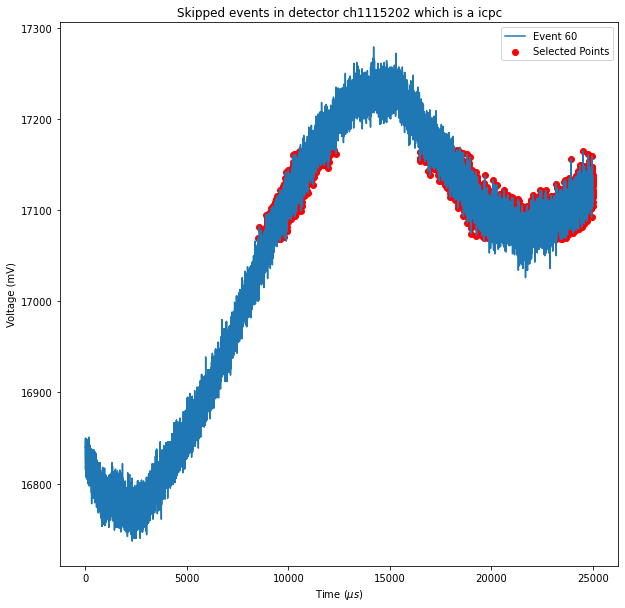

recovery rate 17012.8s
MICRODISCHARGE
Maximum difference: 6730.400000000001, 23608.0
Next Maximum difference: 6595.200000000001, 6730.400000000001


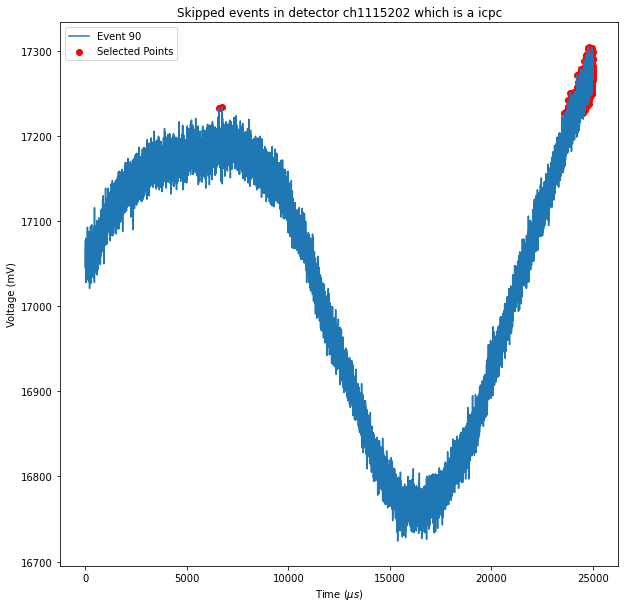

recovery rate 196.79999999999927s
MICRODISCHARGE
Maximum difference: 22720.0, 22847.2
Next Maximum difference: 22650.4, 22720.0


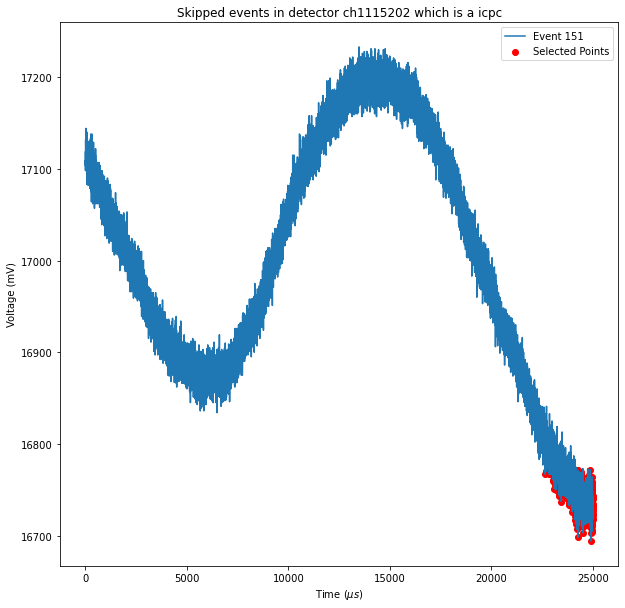

recovery rate -2766.3999999999996s
MICRODISCHARGE
Maximum difference: 6688.8, 15845.6
Next Maximum difference: 18612.0, 23937.600000000002


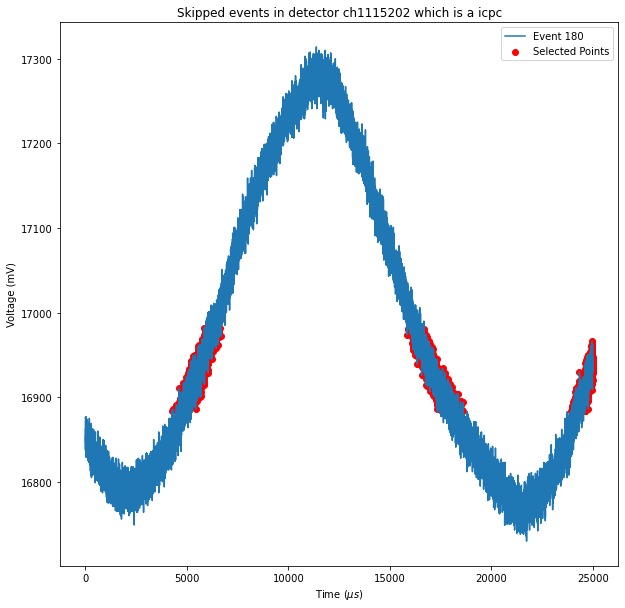

recovery rate -2384.0s
MICRODISCHARGE
Maximum difference: 5691.200000000001, 15447.2
Next Maximum difference: 17831.2, 23145.600000000002


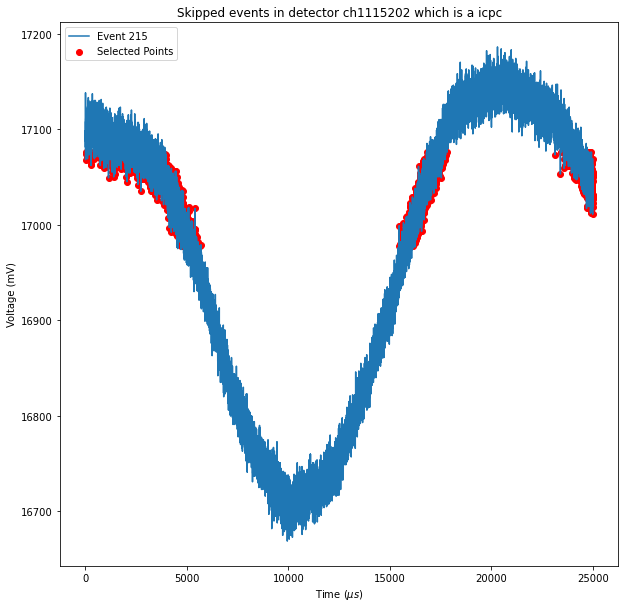

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 8529.6, 8562.4
Next Maximum difference: 8562.4, 8594.4


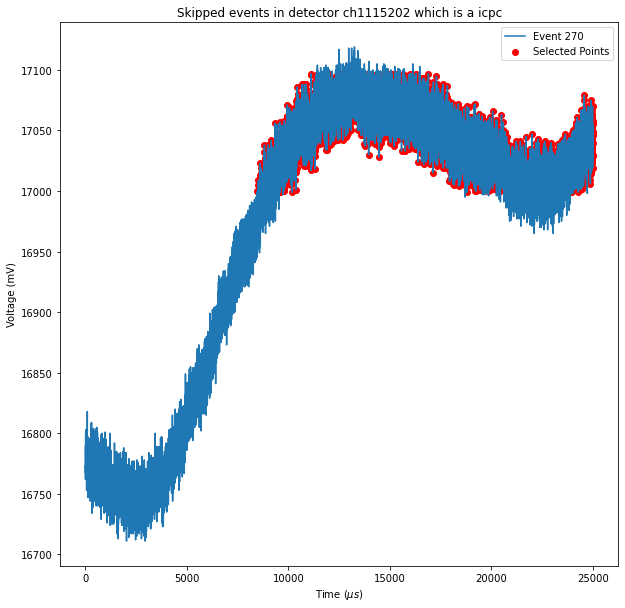

recovery rate -3247.999999999998s
MICRODISCHARGE
Maximum difference: 7955.200000000001, 15484.800000000001
Next Maximum difference: 18732.8, 21282.4


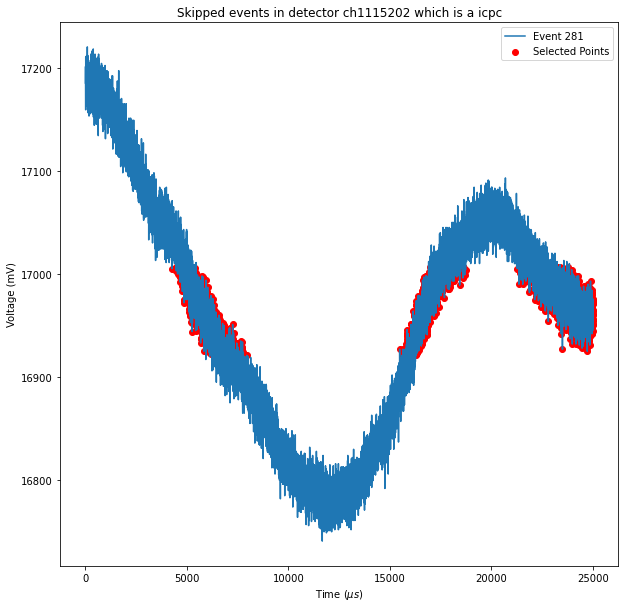

recovery rate -2723.2000000000007s
MICRODISCHARGE
Maximum difference: 6295.200000000001, 16448.8
Next Maximum difference: 19172.0, 23591.2


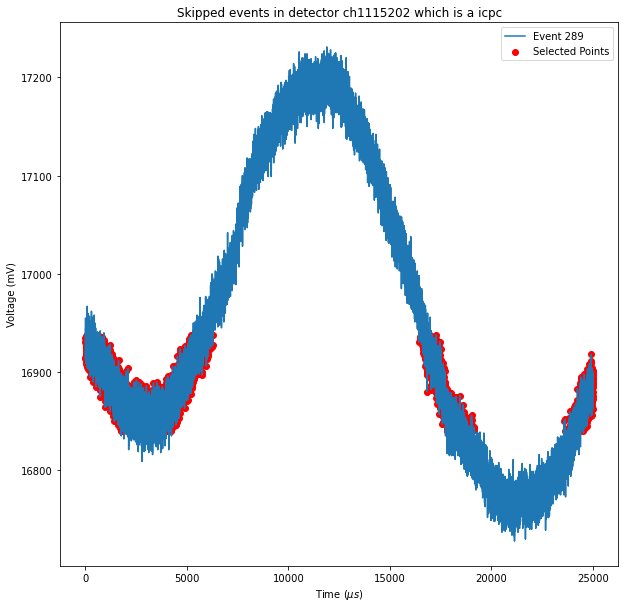

recovery rate 17792.8s
MICRODISCHARGE
Maximum difference: 14451.2, 24015.2
Next Maximum difference: 6222.400000000001, 12086.400000000001


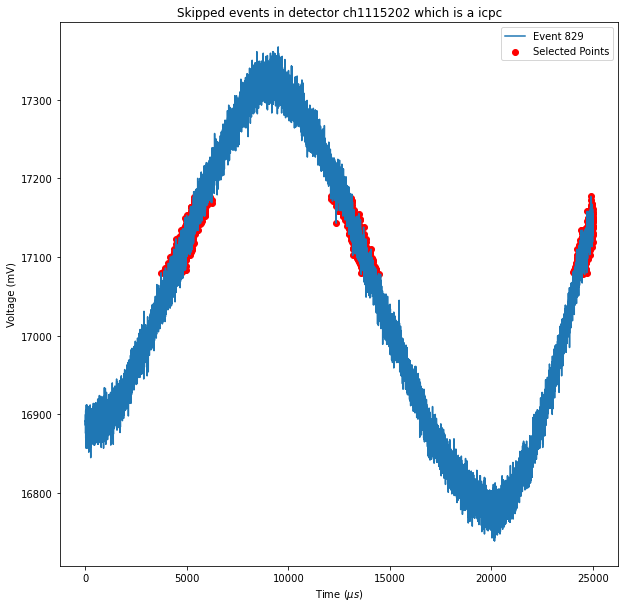

recovery rate -3276.800000000001s
MICRODISCHARGE
Maximum difference: 252.0, 11740.0
Next Maximum difference: 15016.800000000001, 18317.600000000002


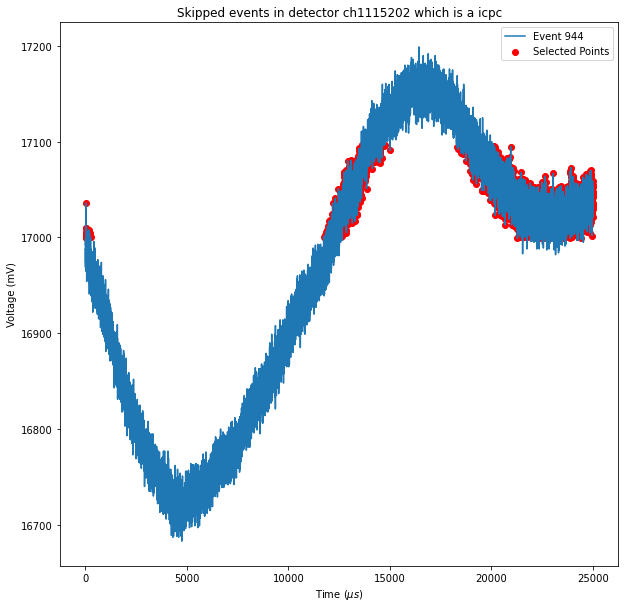

recovery rate 2453.6000000000004s
MICRODISCHARGE
Maximum difference: 8339.2, 9367.2
Next Maximum difference: 6913.6, 7746.400000000001


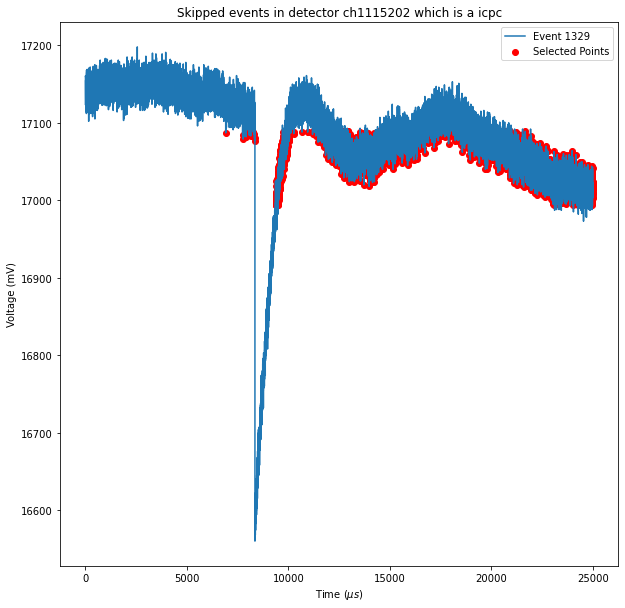

recovery rate 5295.200000000001s
DISCHARGE
Maximum difference: 556.8000000000001, 5295.200000000001
Next maximum difference: 5856.8, 6376.0


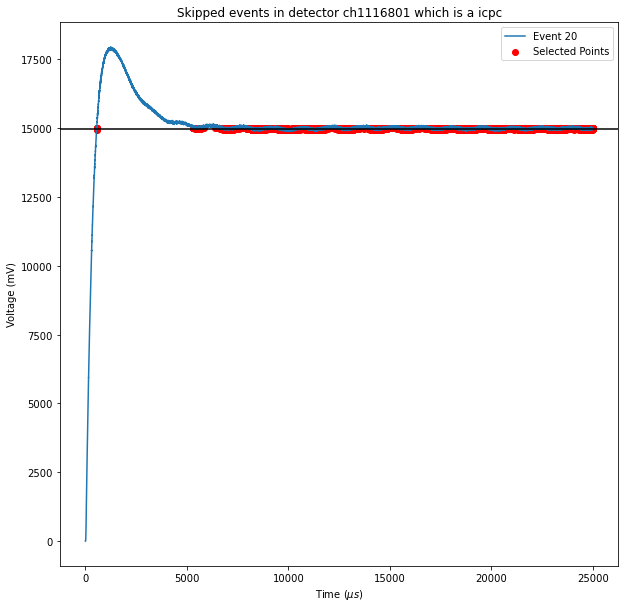

recovery rate 5040.8s
DISCHARGE
Maximum difference: 477.6, 5040.8
Next maximum difference: 13728.0, 13773.6


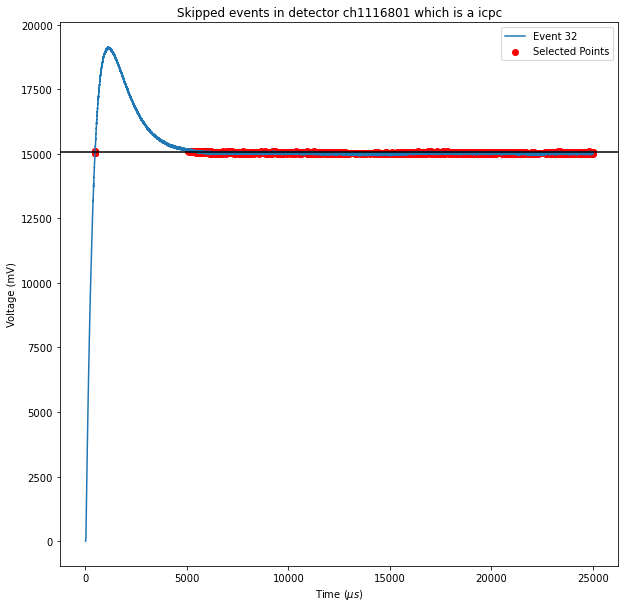

recovery rate 5108.0s
DISCHARGE
Maximum difference: 420.8, 5108.0
Next maximum difference: 9892.0, 9966.400000000001


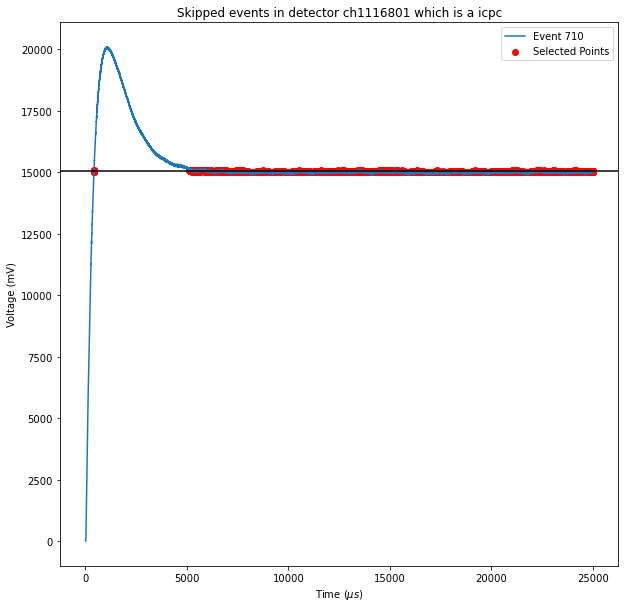

recovery rate 9808.0s
MICRODISCHARGE
Maximum difference: 15892.800000000001, 19928.0
Next Maximum difference: 10120.0, 12076.800000000001


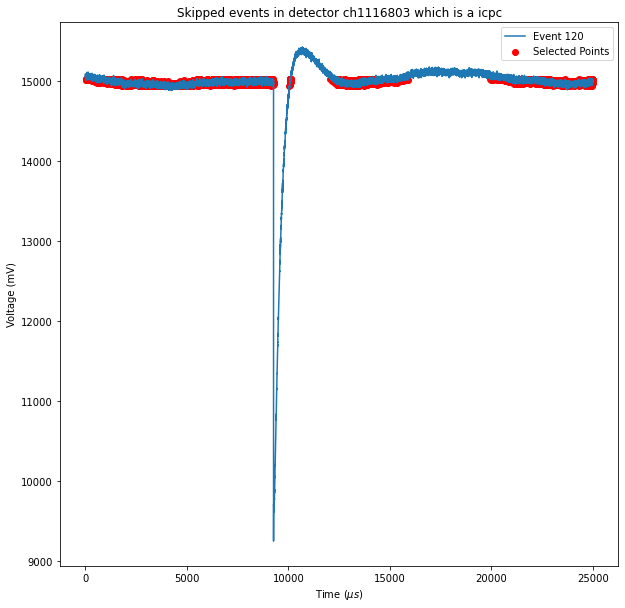

recovery rate 5742.400000000001s
DISCHARGE
Maximum difference: 176.8, 5742.400000000001
Next maximum difference: 18662.4, 19557.600000000002


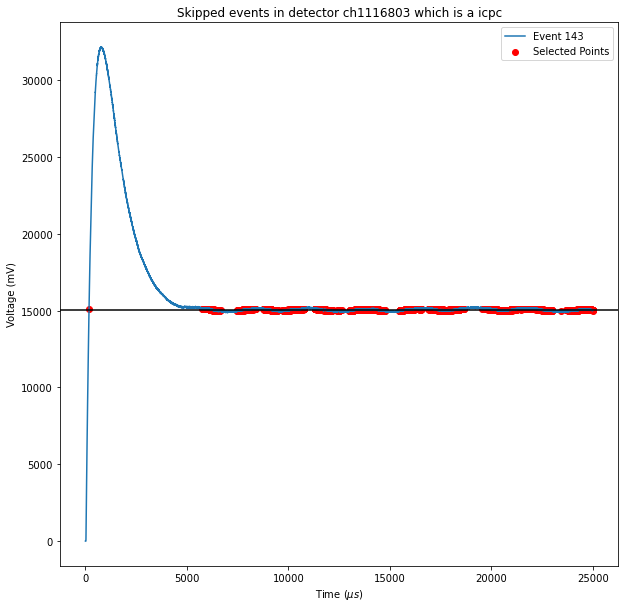

recovery rate -7055.200000000001s
MICRODISCHARGE
Maximum difference: 10074.400000000001, 13536.0
Next Maximum difference: 20591.2, 22911.2


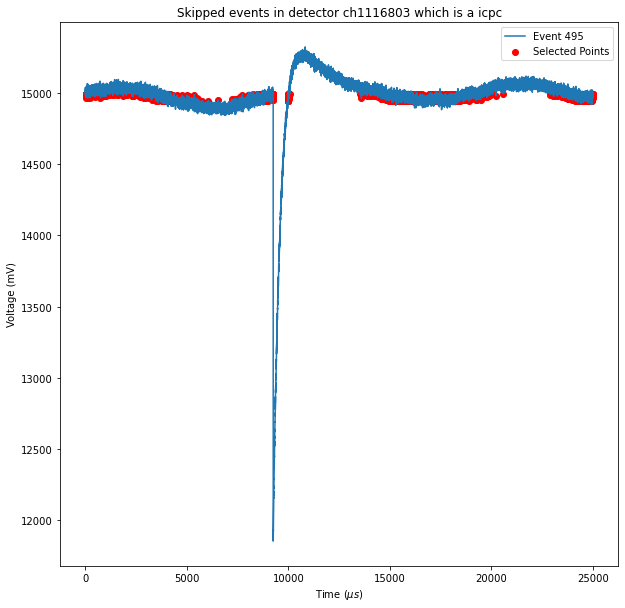

recovery rate 5631.200000000001s
DISCHARGE
Maximum difference: 231.20000000000002, 5631.200000000001
Next maximum difference: 19803.2, 20364.0


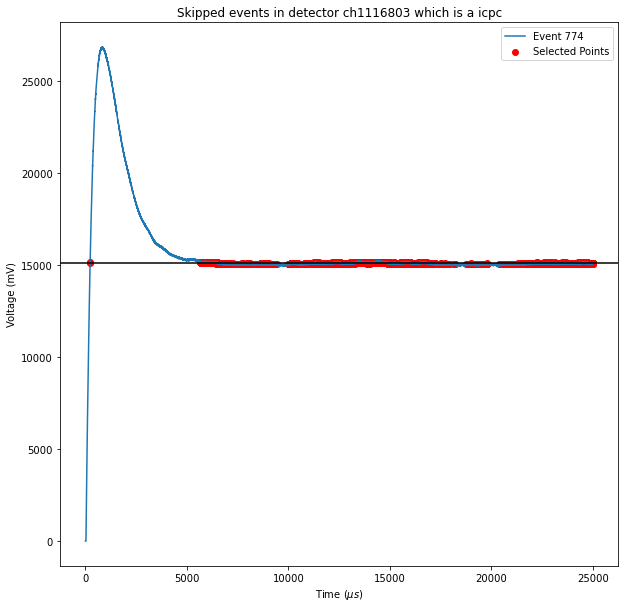

recovery rate 5404.0s
DISCHARGE
Maximum difference: 196.0, 5404.0
Next maximum difference: 10066.400000000001, 11662.400000000001


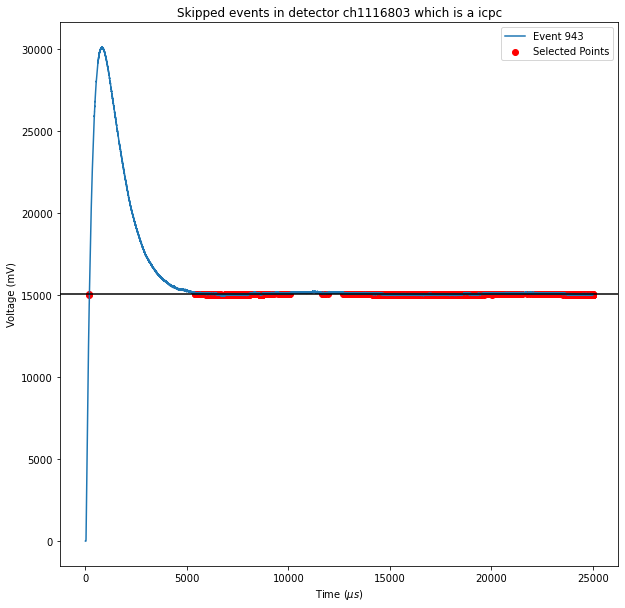

recovery rate 5293.6s
MICRODISCHARGE
Maximum difference: 16452.8, 20950.4
Next Maximum difference: 15656.800000000001, 16402.4


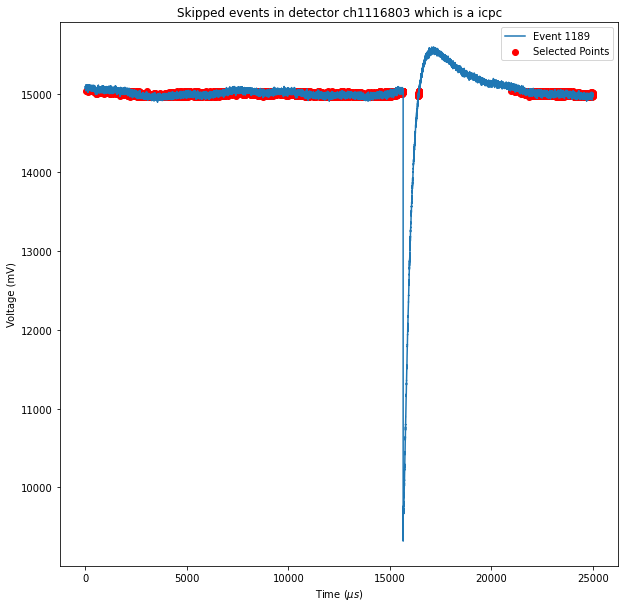

recovery rate 5688.0s
DISCHARGE
Maximum difference: 220.8, 5688.0
Next maximum difference: 14701.6, 15518.400000000001


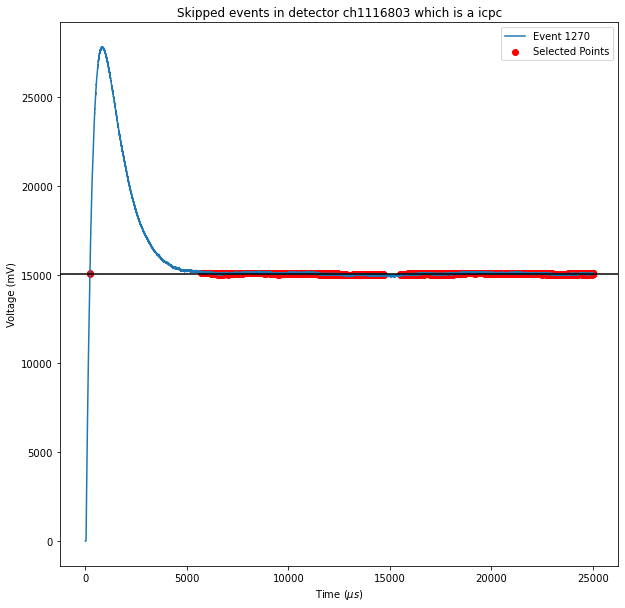

recovery rate 4947.200000000001s
DISCHARGE
Maximum difference: 497.6, 4947.200000000001
Next maximum difference: 9448.0, 9772.800000000001


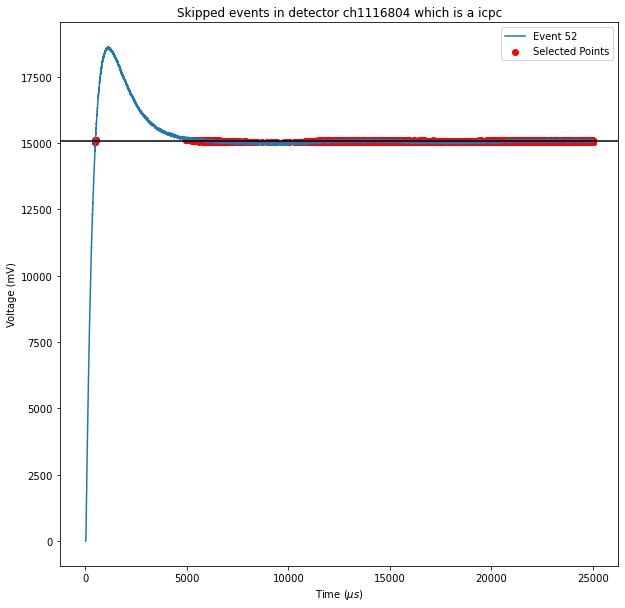

recovery rate 5352.0s
DISCHARGE
Maximum difference: 407.20000000000005, 5352.0
Next maximum difference: 20474.4, 20758.4


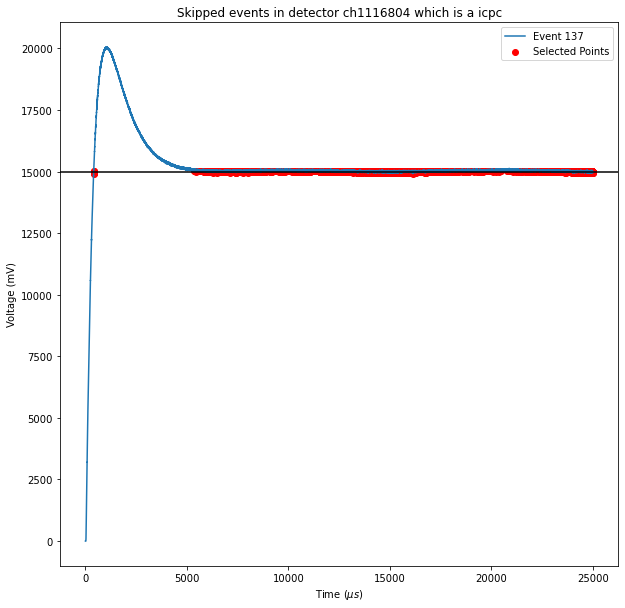

recovery rate 4844.8s
DISCHARGE
Maximum difference: 423.20000000000005, 4844.8
Next maximum difference: 17554.4, 18472.8


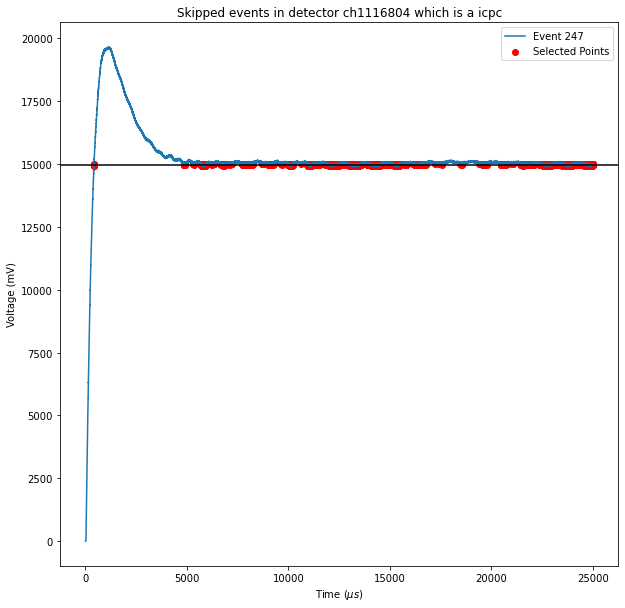

recovery rate 4912.0s
DISCHARGE
Maximum difference: 515.2, 4912.0
Next maximum difference: 4912.0, 5043.200000000001


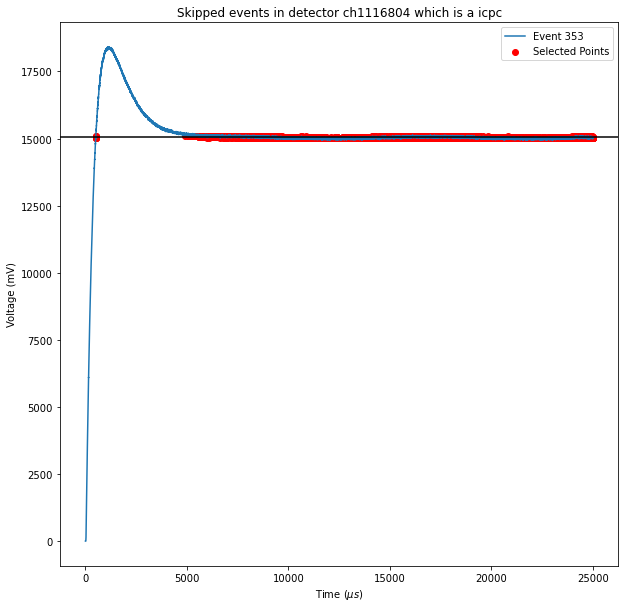

recovery rate 5206.400000000001s
DISCHARGE
Maximum difference: 507.20000000000005, 5206.400000000001
Next maximum difference: 5388.8, 5521.6


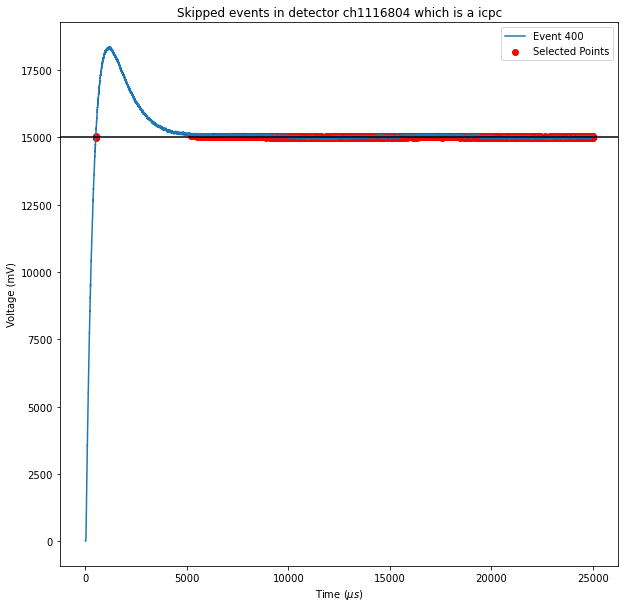

recovery rate 5040.8s
DISCHARGE
Maximum difference: 483.20000000000005, 5040.8
Next maximum difference: 17946.4, 18004.8


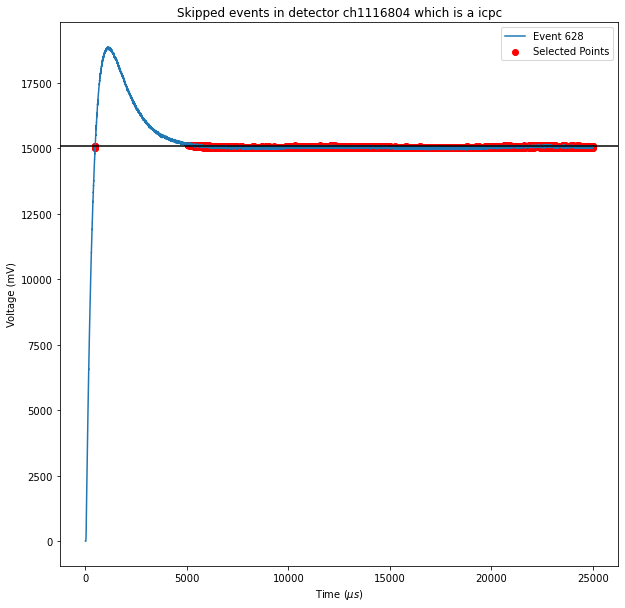

recovery rate 4038.4000000000015s
MICRODISCHARGE
Maximum difference: 15713.6, 18873.600000000002
Next Maximum difference: 14835.2, 15568.800000000001


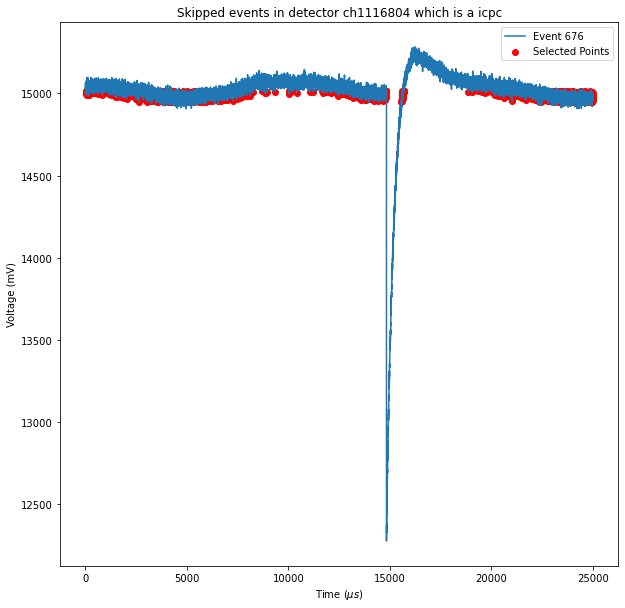

recovery rate 5263.200000000001s
DISCHARGE
Maximum difference: 397.6, 5263.200000000001
Next maximum difference: 20876.0, 21047.2


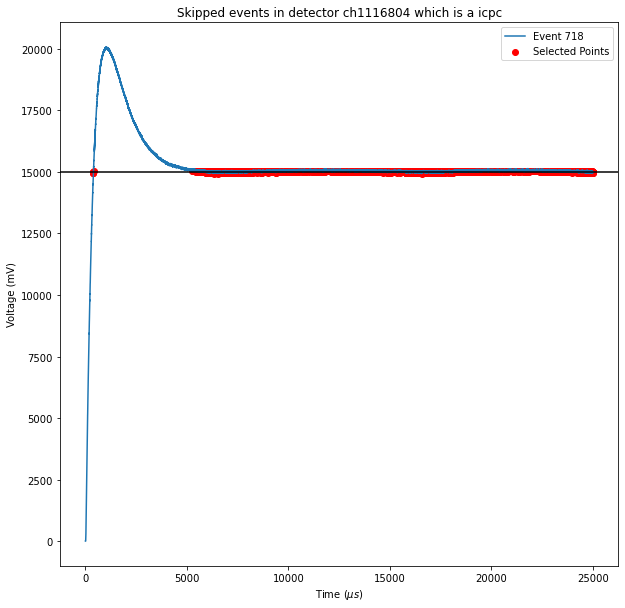

recovery rate 5532.0s
DISCHARGE
Maximum difference: 311.20000000000005, 5532.0
Next maximum difference: 5604.0, 5653.6


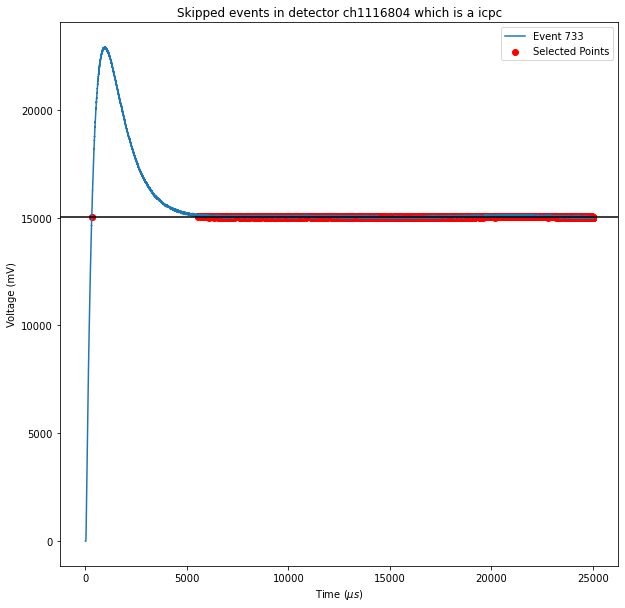

recovery rate 2652.800000000003s
MICRODISCHARGE
Maximum difference: 21071.2, 22812.800000000003
Next Maximum difference: 20160.0, 20944.800000000003


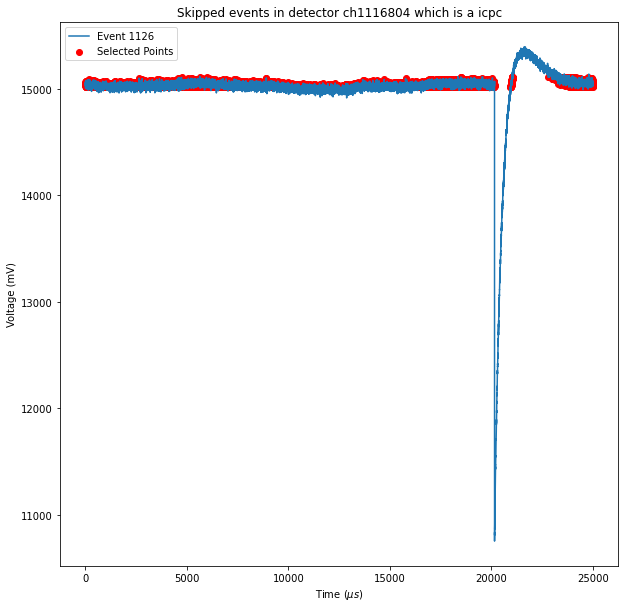

recovery rate 2323.2000000000007s
MICRODISCHARGE
Maximum difference: 9432.800000000001, 10827.2
Next Maximum difference: 8504.0, 9259.2


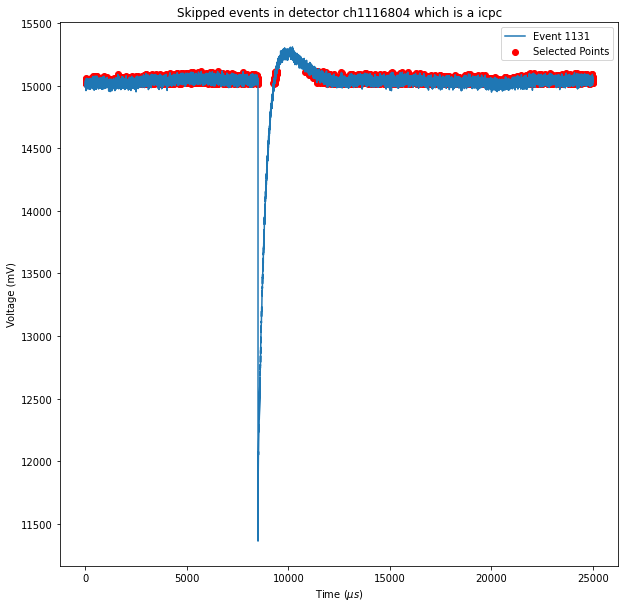

recovery rate 5751.200000000001s
DISCHARGE
Maximum difference: 488.0, 5751.200000000001
Next maximum difference: 5932.8, 6219.200000000001


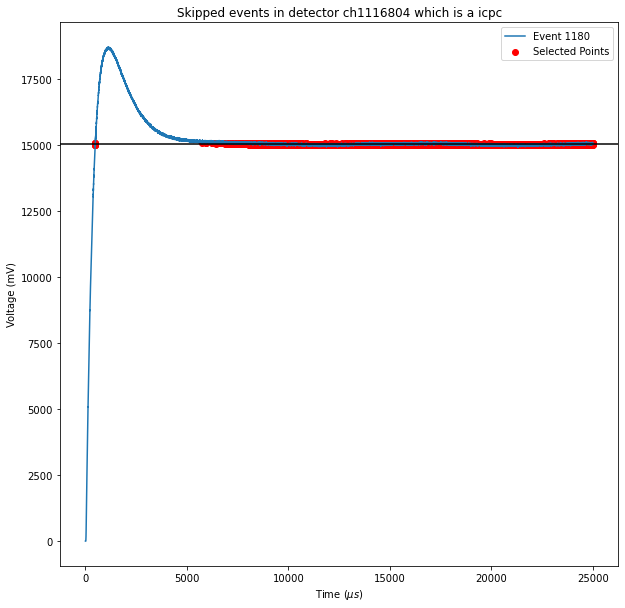

recovery rate 5360.8s
DISCHARGE
Maximum difference: 513.6, 5360.8
Next maximum difference: 19546.4, 19638.4


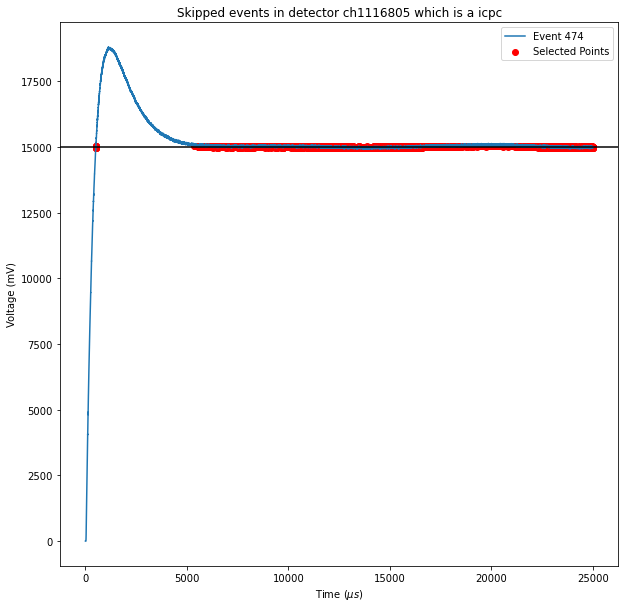

recovery rate 6879.200000000001s
DISCHARGE
Maximum difference: 253.60000000000002, 6879.200000000001
Next maximum difference: 8255.2, 9538.4


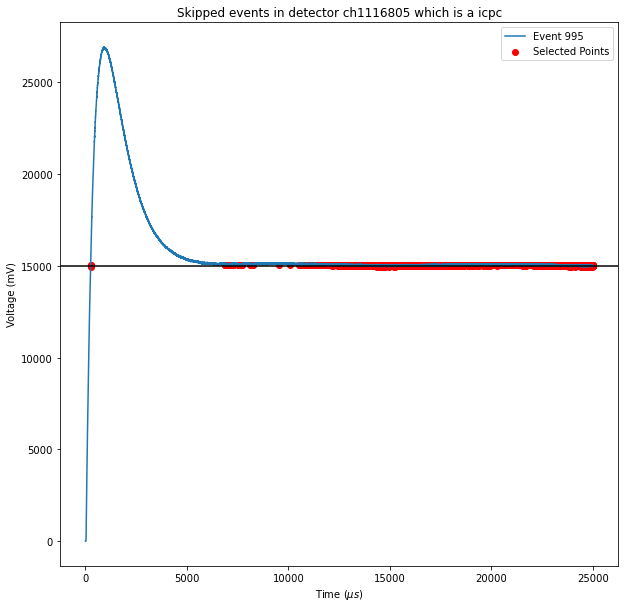

recovery rate 3284.8s
MICRODISCHARGE
Maximum difference: 428.0, 3284.8
Next Maximum difference: 3308.0, 3323.2000000000003


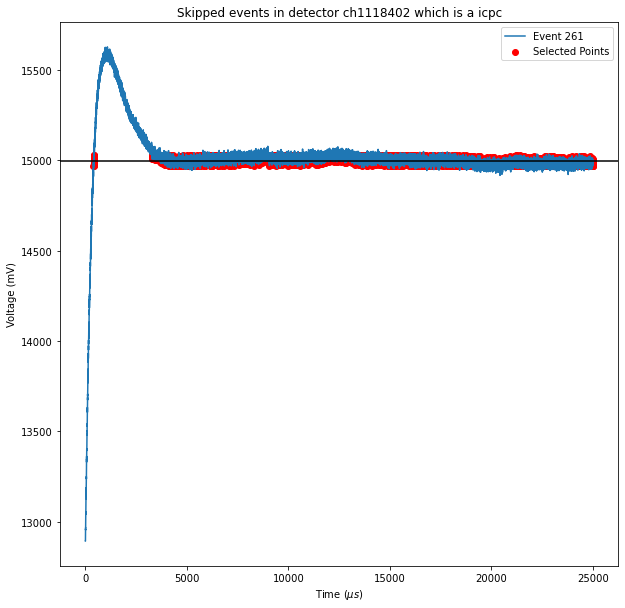

recovery rate 5384.8s
DISCHARGE
Maximum difference: 486.40000000000003, 5384.8
Next maximum difference: 9872.800000000001, 10301.6


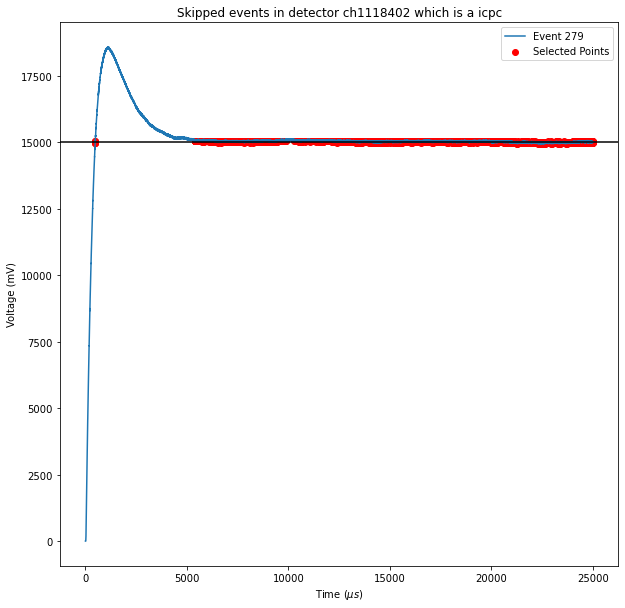

recovery rate 3645.6000000000004s
MICRODISCHARGE
Maximum difference: 401.6, 3645.6000000000004
Next Maximum difference: 3651.2000000000003, 3675.2000000000003


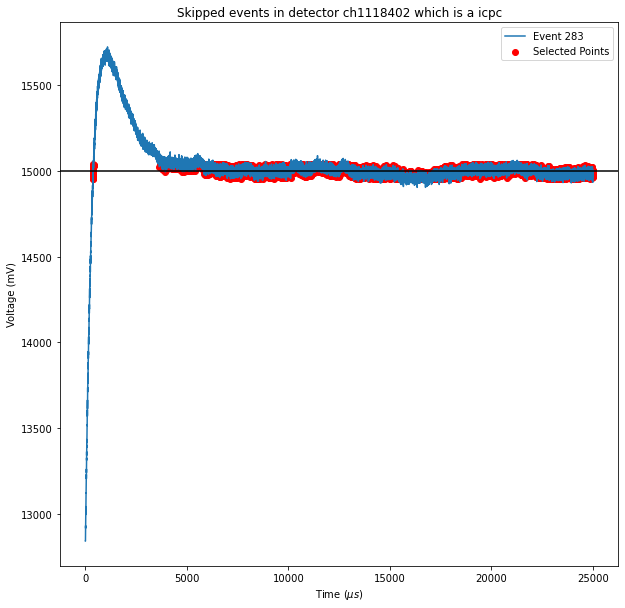

recovery rate -204.0s
MICRODISCHARGE
Maximum difference: 2020.0, 2809.6000000000004
Next Maximum difference: 3013.6000000000004, 3763.2000000000003


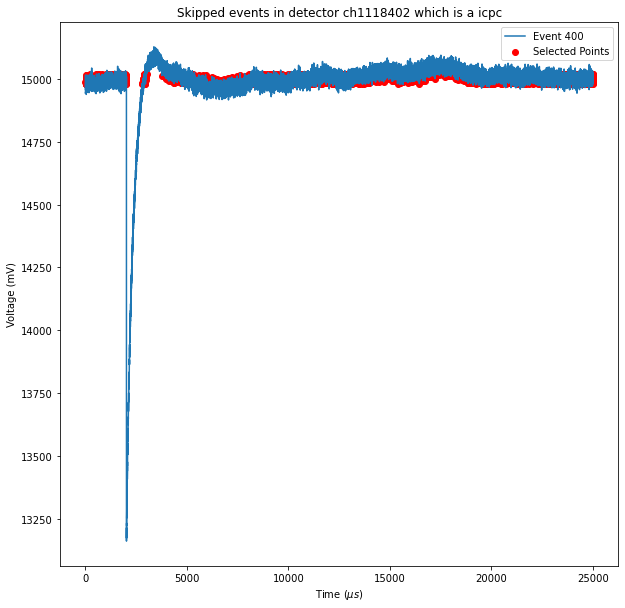

recovery rate 4973.6s
DISCHARGE
Maximum difference: 408.8, 4973.6
Next maximum difference: 18336.0, 19545.600000000002


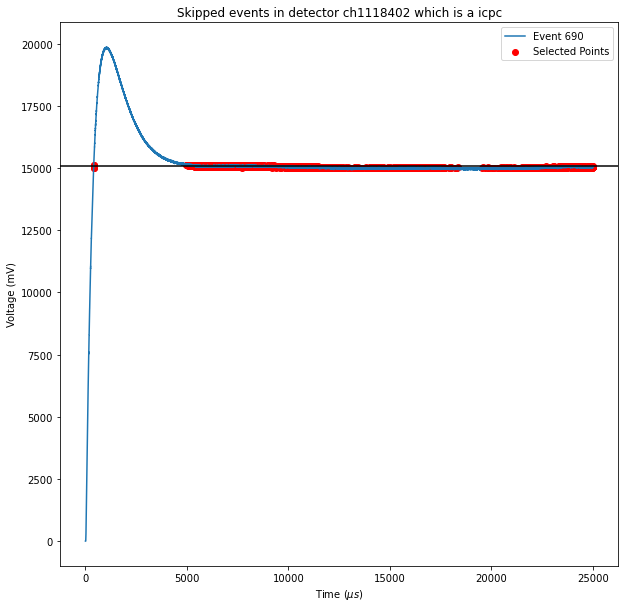

recovery rate 2834.4s
MICRODISCHARGE
Maximum difference: 566.4, 2834.4
Next Maximum difference: 15578.400000000001, 16108.800000000001


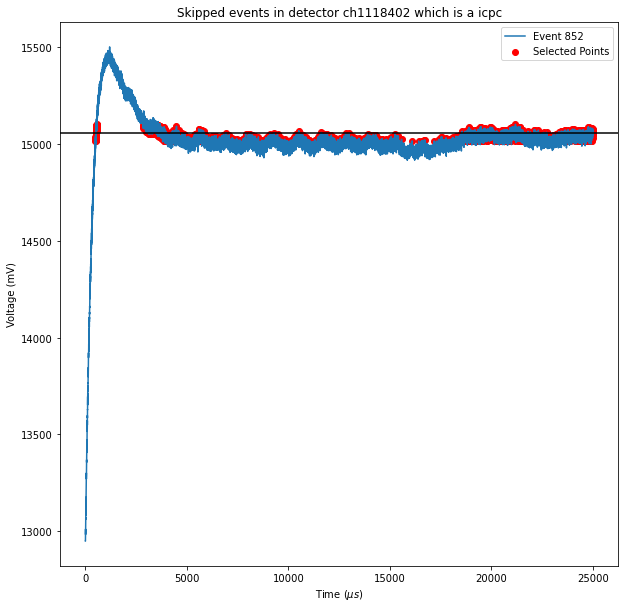

recovery rate 5177.6s
DISCHARGE
Maximum difference: 500.8, 5177.6
Next maximum difference: 5210.400000000001, 5249.6


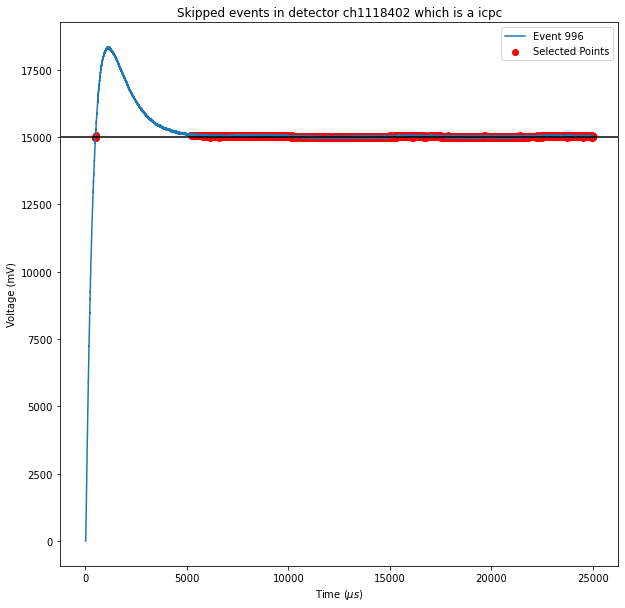

recovery rate 5579.200000000001s
DISCHARGE
Maximum difference: 237.60000000000002, 5579.200000000001
Next maximum difference: 5661.6, 5680.0


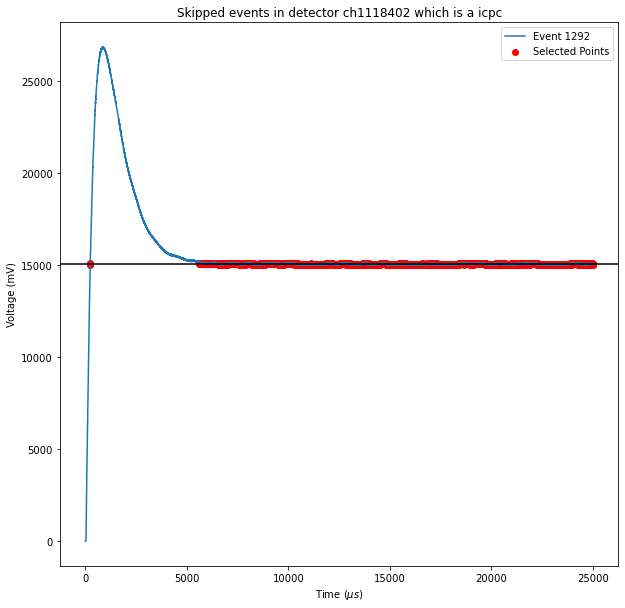

recovery rate 5112.0s
DISCHARGE
Maximum difference: 397.6, 5112.0
Next maximum difference: 5112.0, 5176.0


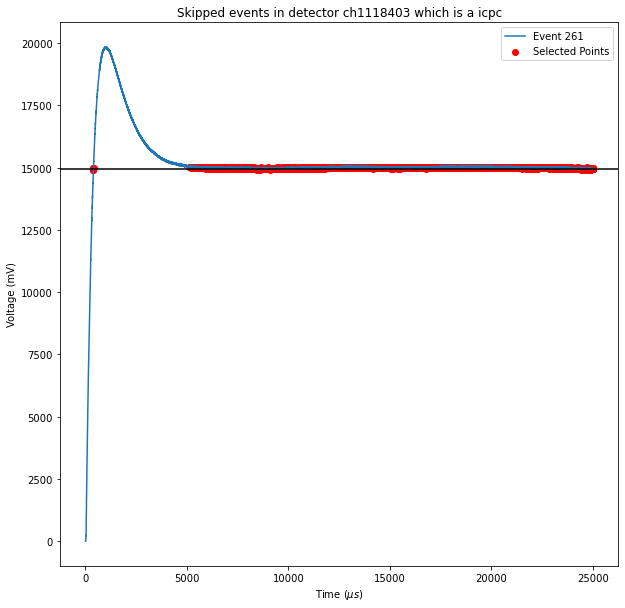

recovery rate 5044.0s
DISCHARGE
Maximum difference: 372.0, 5044.0
Next maximum difference: 11652.800000000001, 11948.0


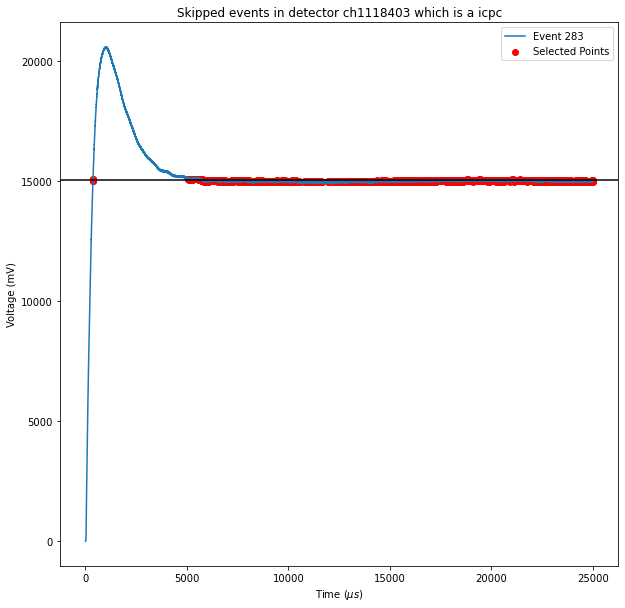

recovery rate 4497.6s
DISCHARGE
Maximum difference: 492.8, 4497.6
Next maximum difference: 10577.6, 10987.2


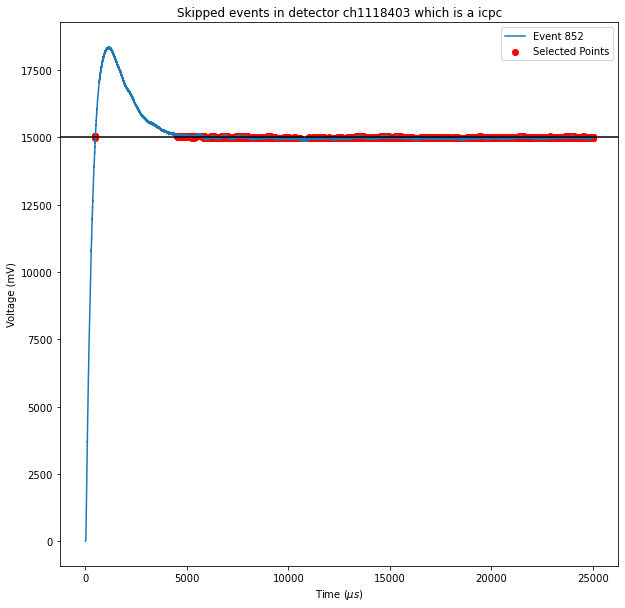

recovery rate -10660.0s
MICRODISCHARGE
Maximum difference: 1650.4, 3492.0
Next Maximum difference: 14152.0, 15094.400000000001


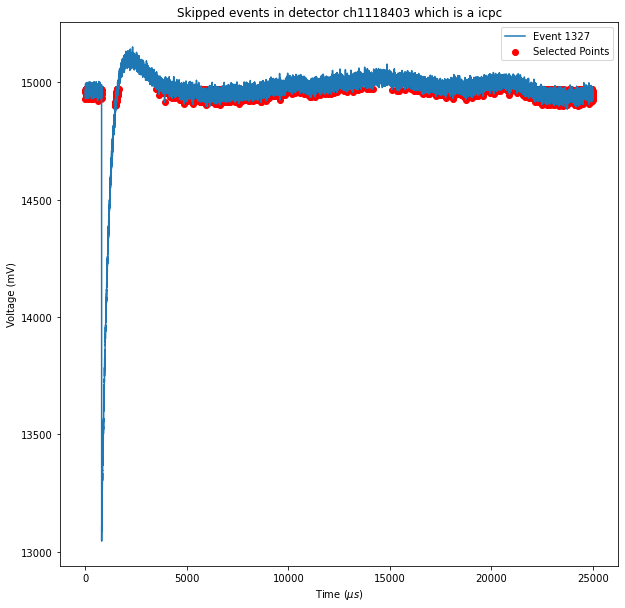

recovery rate 0.0s
MICRODISCHARGE
Maximum difference: 24430.4, 24456.800000000003
Next Maximum difference: 24456.800000000003, 24464.0


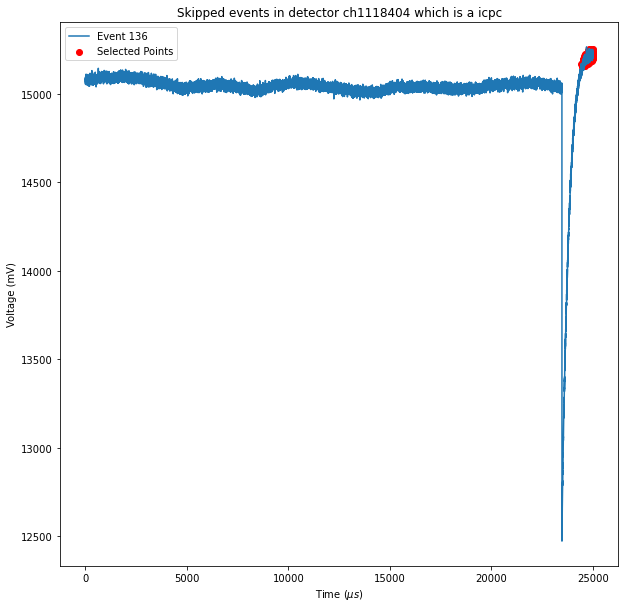

recovery rate 2400.8s
MICRODISCHARGE
Maximum difference: 540.0, 2400.8
Next Maximum difference: 8592.0, 9715.2


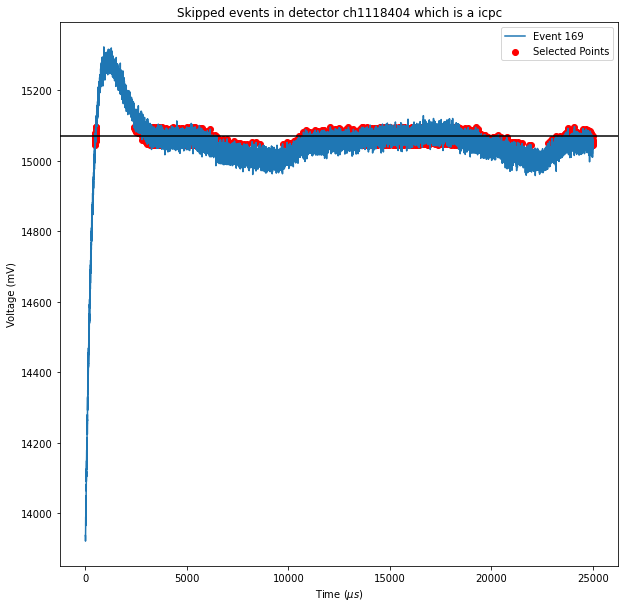

recovery rate 15136.800000000001s
MICRODISCHARGE
Maximum difference: 11424.0, 15136.800000000001
Next Maximum difference: 498.40000000000003, 2173.6


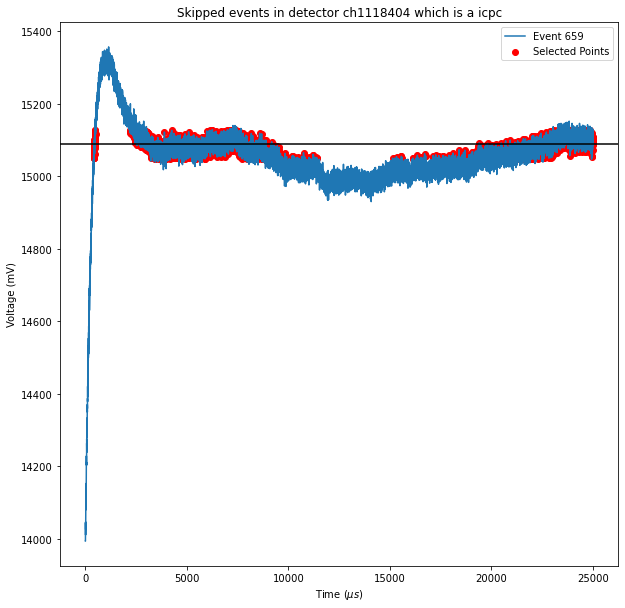

recovery rate 12225.6s
MICRODISCHARGE
Maximum difference: 9344.0, 12225.6
Next Maximum difference: 4688.0, 6741.6


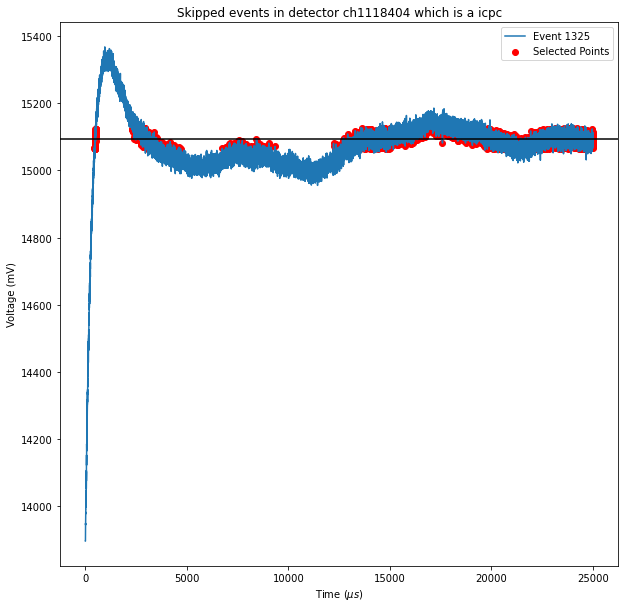

recovery rate 19019.2s
MICRODISCHARGE
Maximum difference: 16572.8, 19019.2
Next Maximum difference: 332.0, 2750.4


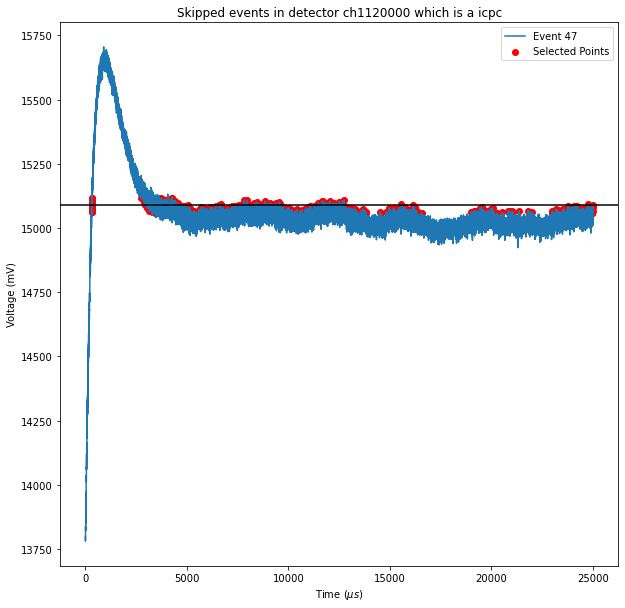

recovery rate 2232.0s
MICRODISCHARGE
Maximum difference: 600.0, 2232.0
Next Maximum difference: 21013.600000000002, 21160.0


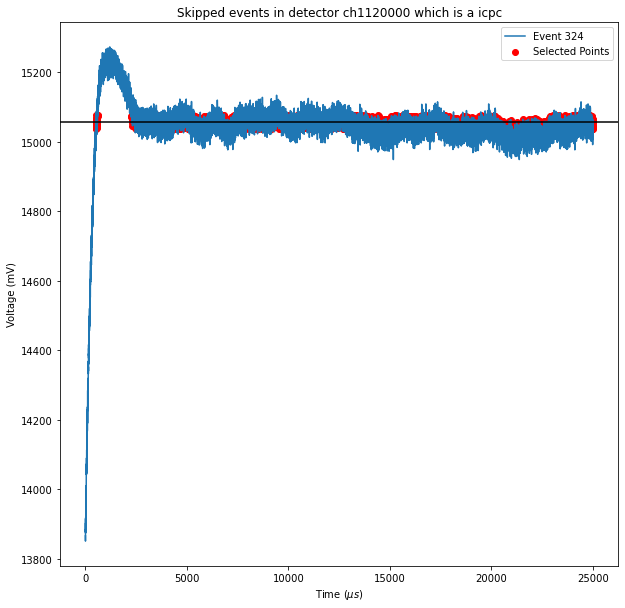

recovery rate 2905.6000000000004s
MICRODISCHARGE
Maximum difference: 458.40000000000003, 2905.6000000000004
Next Maximum difference: 8729.6, 8815.2


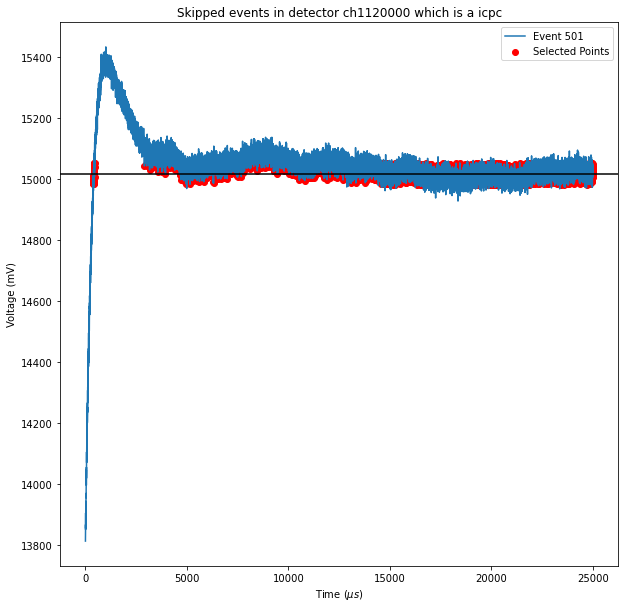

recovery rate 2786.4s
MICRODISCHARGE
Maximum difference: 396.0, 2786.4
Next Maximum difference: 2828.0, 2921.6000000000004


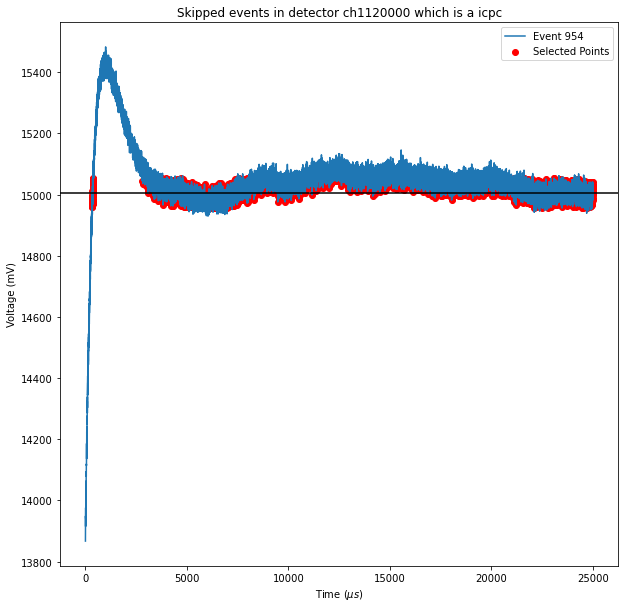

recovery rate 5452.0s
DISCHARGE
Maximum difference: 506.40000000000003, 5452.0
Next maximum difference: 14160.800000000001, 15417.6


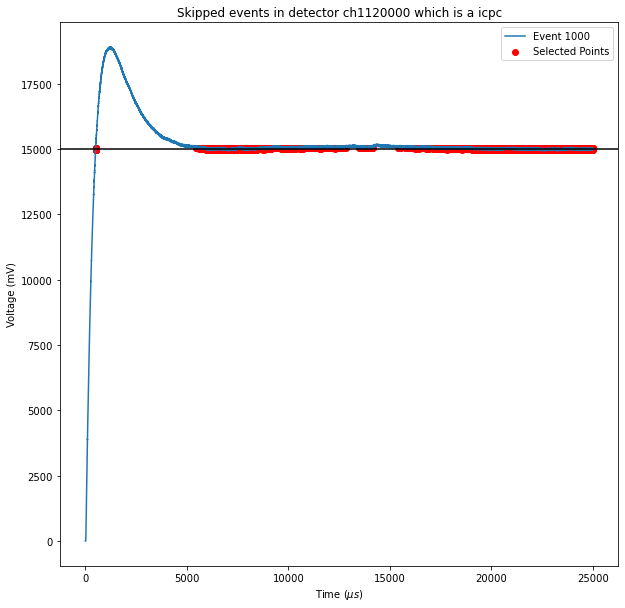

recovery rate 13527.2s
MICRODISCHARGE
Maximum difference: 10560.800000000001, 13527.2
Next Maximum difference: 671.2, 2560.8


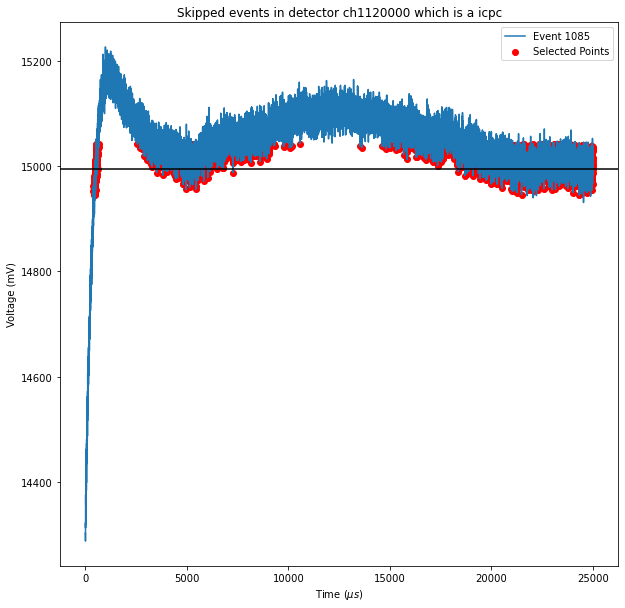

recovery rate 1174.4000000000015s
MICRODISCHARGE
Maximum difference: 15080.800000000001, 15858.400000000001
Next Maximum difference: 14684.0, 14727.2


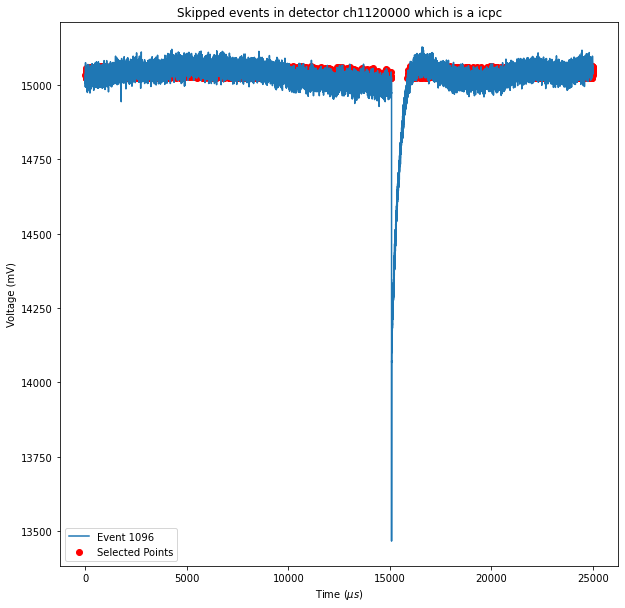

recovery rate 2596.8s
MICRODISCHARGE
Maximum difference: 564.0, 2596.8
Next Maximum difference: 22974.4, 23120.0


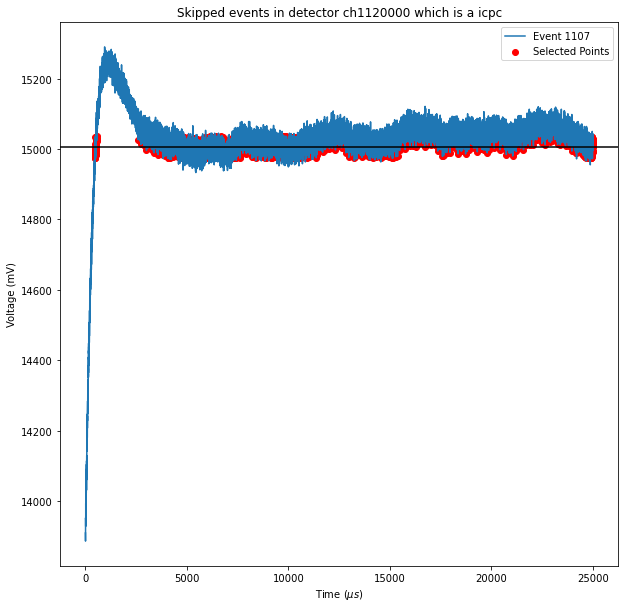

recovery rate 2420.8s
MICRODISCHARGE
Maximum difference: 427.20000000000005, 2420.8
Next Maximum difference: 17056.8, 17679.2


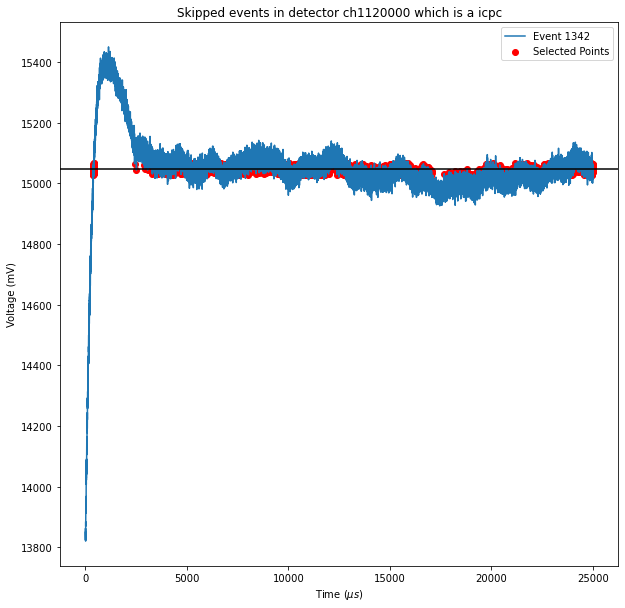

recovery rate -21.600000000002183s
MICRODISCHARGE
Maximum difference: 24180.800000000003, 24188.0
Next Maximum difference: 24209.600000000002, 24215.2


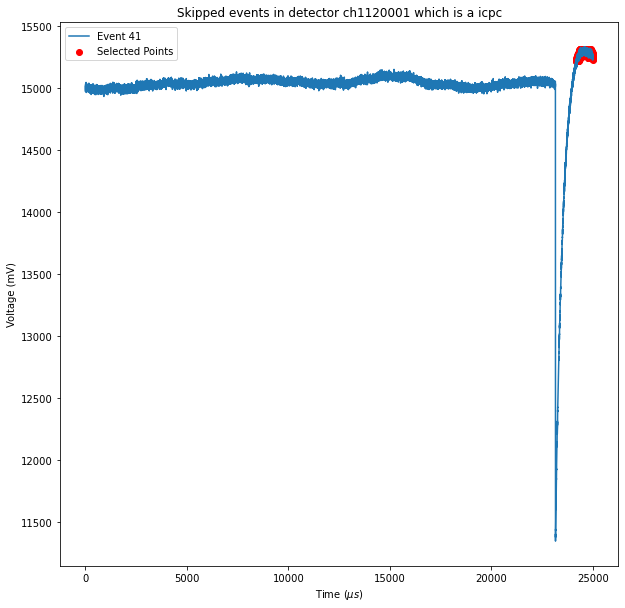

recovery rate 5363.200000000001s
DISCHARGE
Maximum difference: 283.2, 5363.200000000001
Next maximum difference: 22668.0, 24840.800000000003


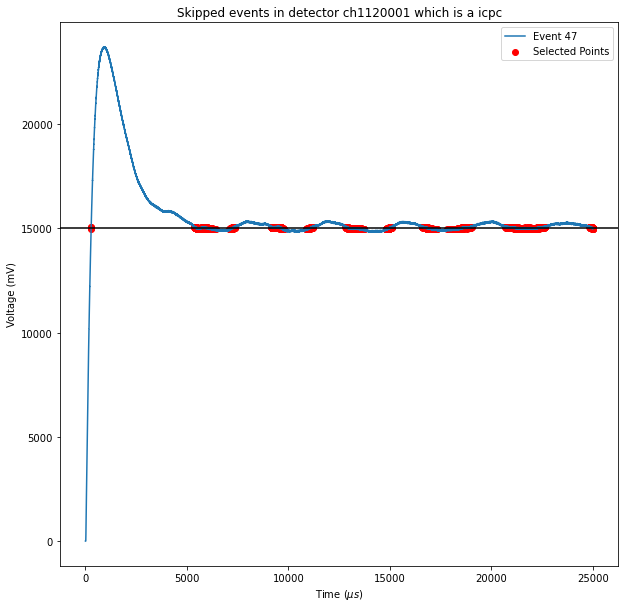

recovery rate 5351.200000000001s
DISCHARGE
Maximum difference: 497.6, 5351.200000000001
Next maximum difference: 7548.8, 9697.6


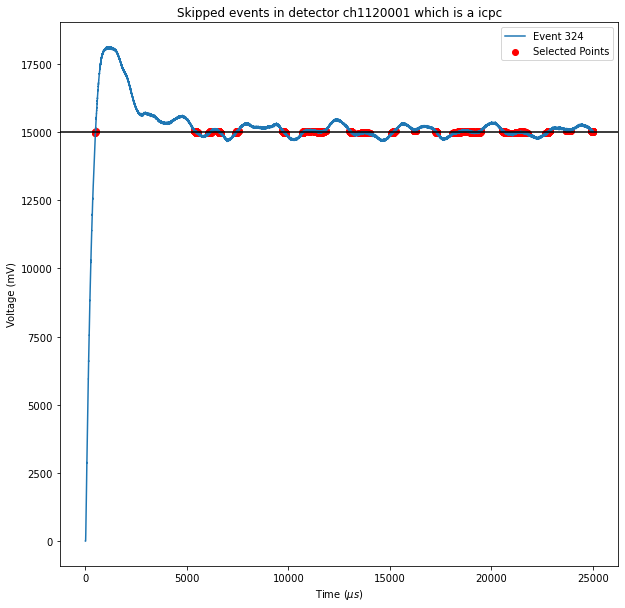

recovery rate 699.2000000000007s
MICRODISCHARGE
Maximum difference: 23844.0, 24498.4
Next Maximum difference: 23799.2, 23844.0


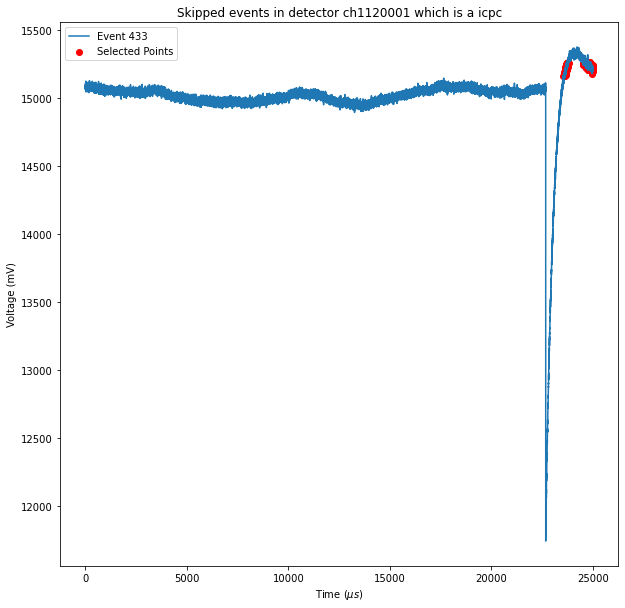

recovery rate 5408.8s
DISCHARGE
Maximum difference: 395.20000000000005, 5408.8
Next maximum difference: 7404.8, 9988.0


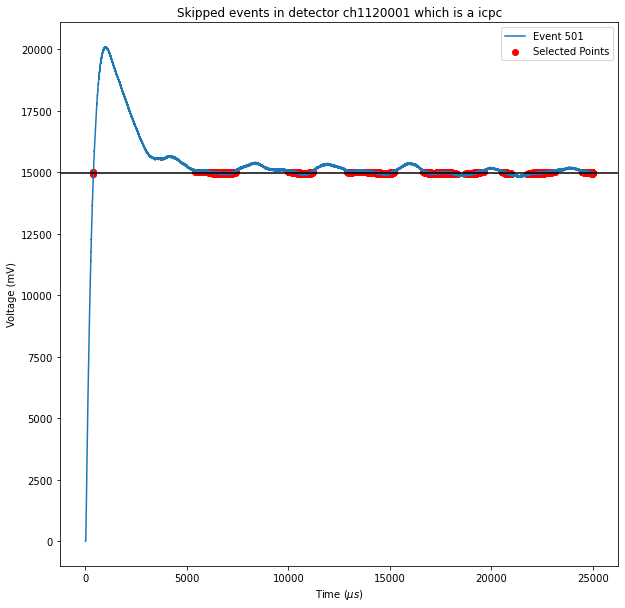

recovery rate 5378.400000000001s
DISCHARGE
Maximum difference: 377.6, 5378.400000000001
Next maximum difference: 11353.6, 13104.0


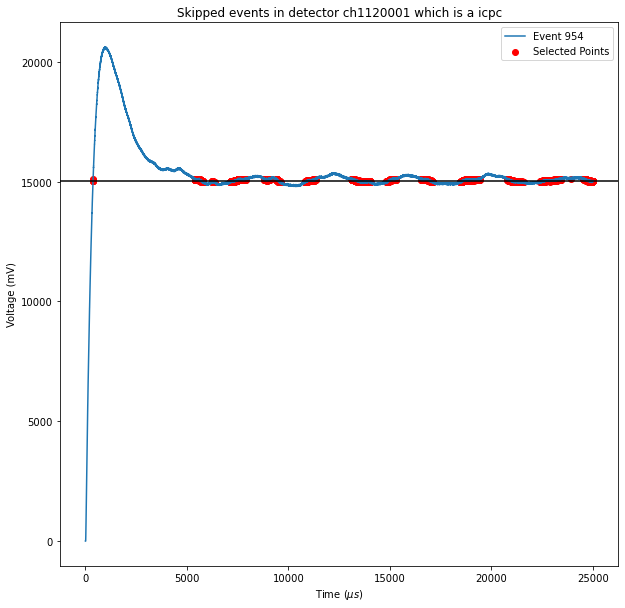

recovery rate -35.19999999999891s
DISCHARGE
Maximum difference: 9131.2, 15922.400000000001
Next maximum difference: 15957.6, 18521.600000000002


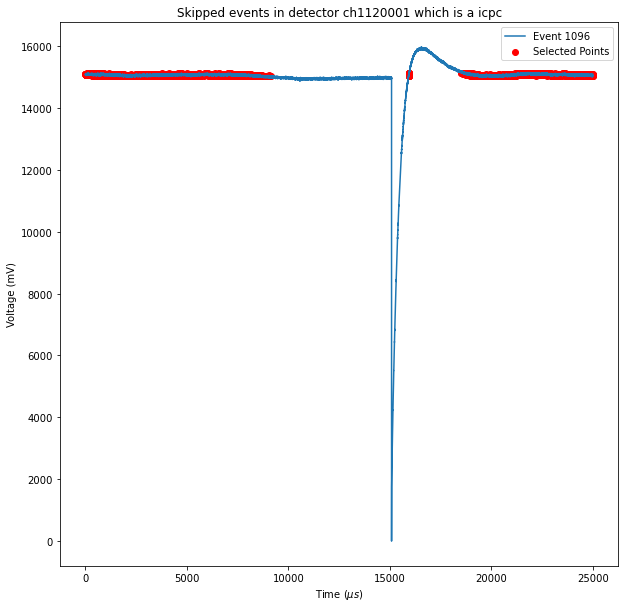

recovery rate 5344.8s
DISCHARGE
Maximum difference: 500.8, 5344.8
Next maximum difference: 15338.400000000001, 17177.600000000002


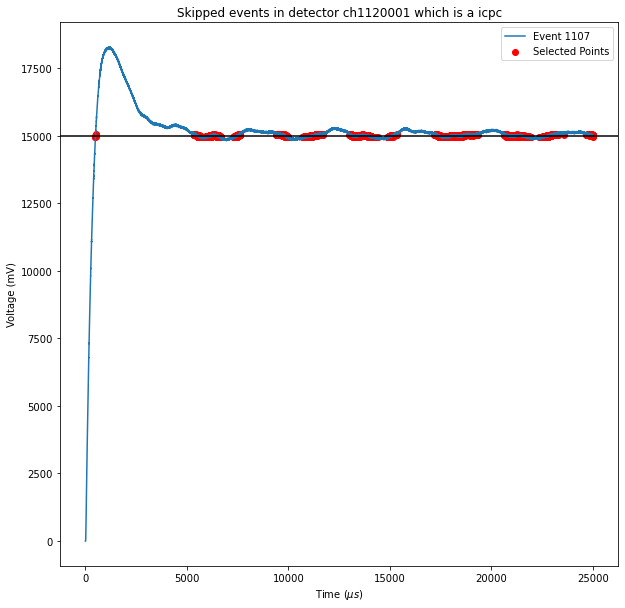

recovery rate 3388.0s
MICRODISCHARGE
Maximum difference: 1498.4, 4024.0
Next Maximum difference: 636.0, 1420.0


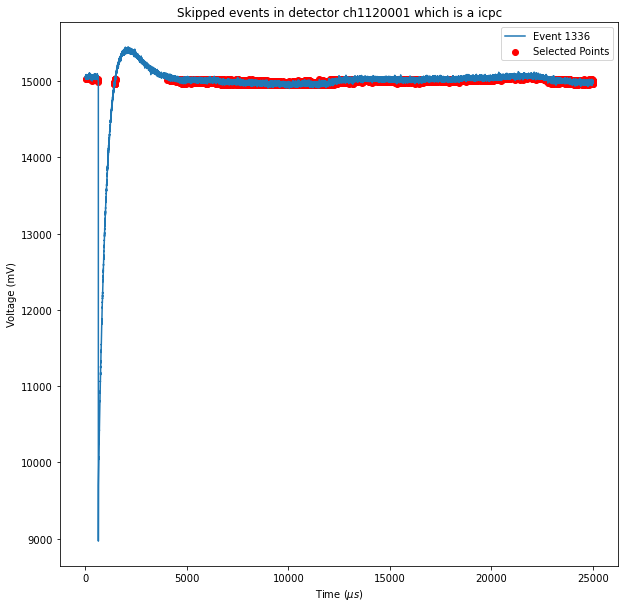

recovery rate 5281.6s
DISCHARGE
Maximum difference: 364.8, 5281.6
Next maximum difference: 7347.200000000001, 9640.0


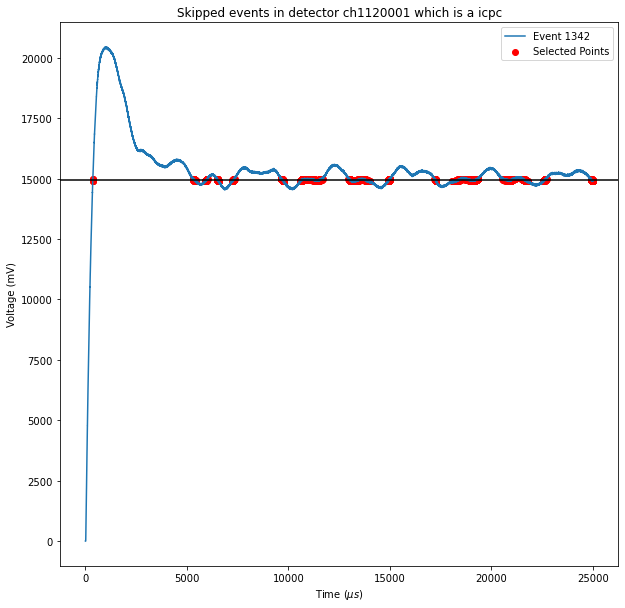

recovery rate -8878.400000000001s
MICRODISCHARGE
Maximum difference: 12.8, 2292.0
Next Maximum difference: 11170.400000000001, 11213.6


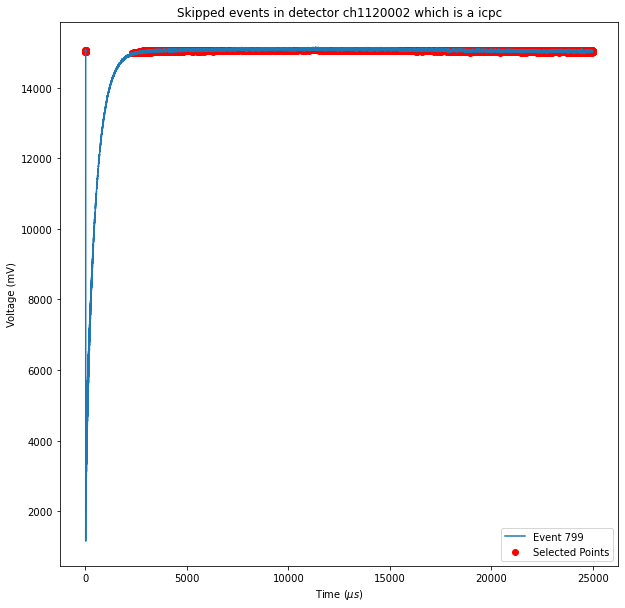

recovery rate -60.80000000000109s
MICRODISCHARGE
Maximum difference: 15085.6, 15180.0
Next Maximum difference: 15240.800000000001, 15289.6


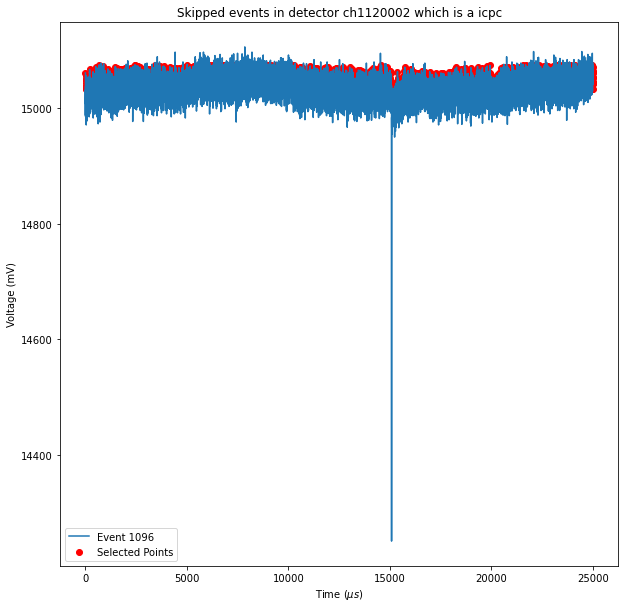

recovery rate 10812.800000000003s
MICRODISCHARGE
Maximum difference: 21429.600000000002, 22780.800000000003
Next Maximum difference: 11968.0, 12144.800000000001


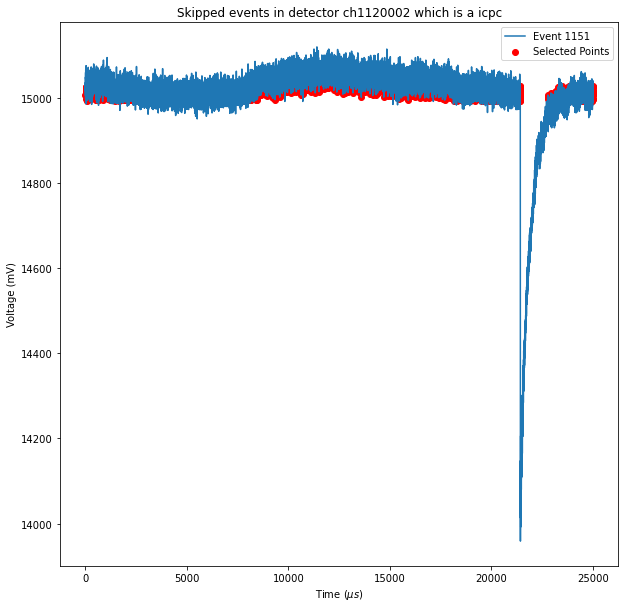

recovery rate 19100.0s
DISCHARGE
Maximum difference: 9828.800000000001, 19100.0
Next maximum difference: 19776.800000000003, 24493.600000000002


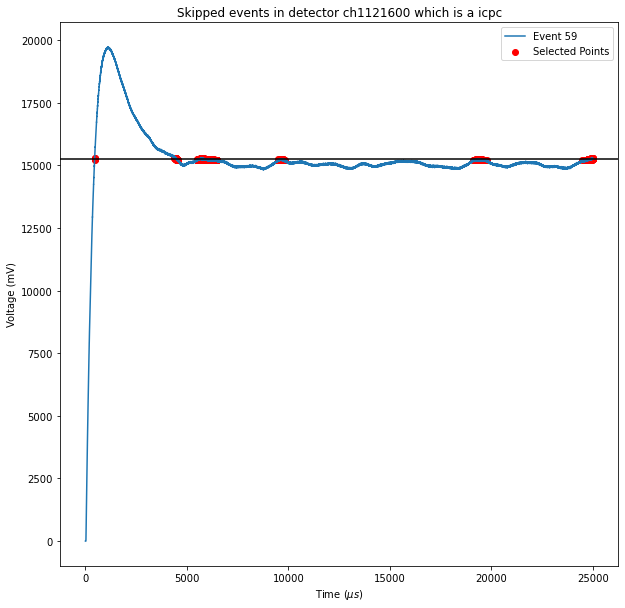

recovery rate 4480.0s
DISCHARGE
Maximum difference: 564.8000000000001, 4480.0
Next maximum difference: 12310.400000000001, 15140.800000000001


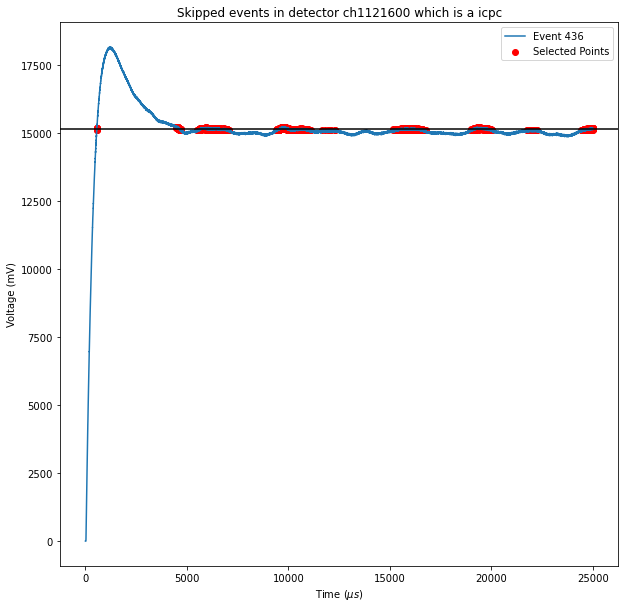

recovery rate 15408.800000000001s
DISCHARGE
Maximum difference: 10636.0, 15408.800000000001
Next maximum difference: 19853.600000000002, 24476.0


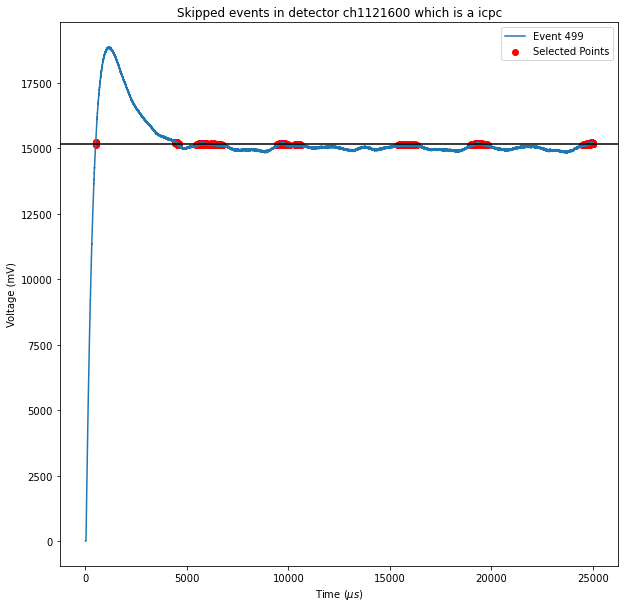

recovery rate 15316.0s
DISCHARGE
Maximum difference: 10021.6, 15316.0
Next maximum difference: 19840.0, 24409.600000000002


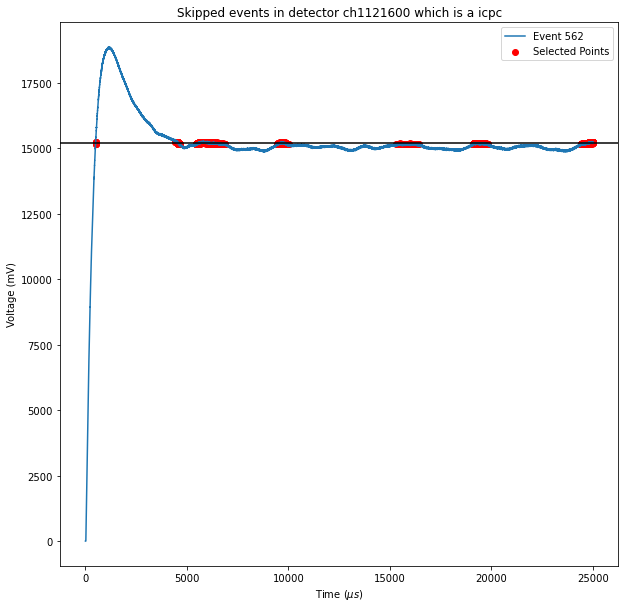

recovery rate 15368.800000000001s
DISCHARGE
Maximum difference: 10532.0, 15368.800000000001
Next maximum difference: 19906.4, 24624.800000000003


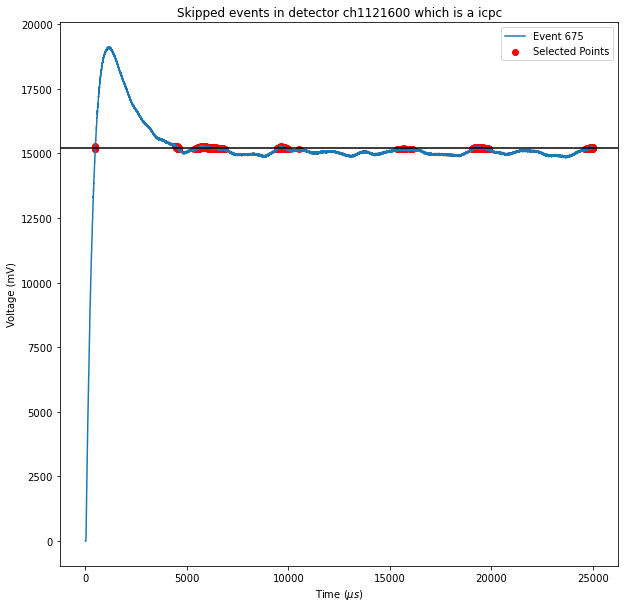

recovery rate 15379.2s
DISCHARGE
Maximum difference: 9919.2, 15379.2
Next maximum difference: 19895.2, 24459.2


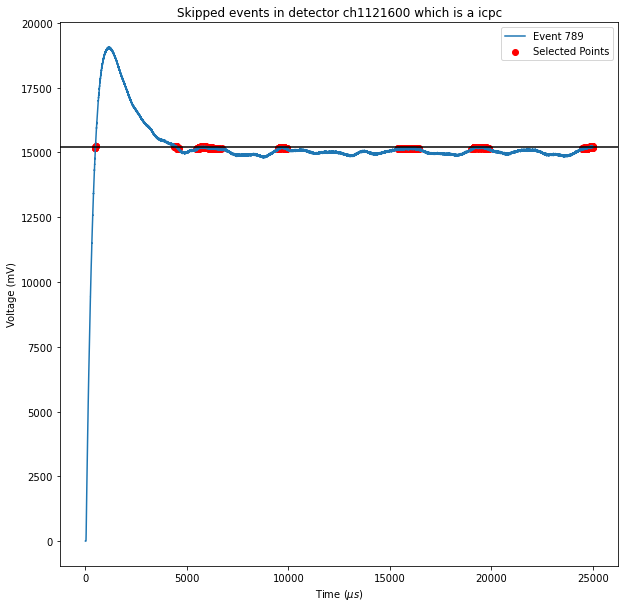

recovery rate 24444.0s
DISCHARGE
Maximum difference: 18581.600000000002, 24444.0
Next maximum difference: 9936.800000000001, 15720.0


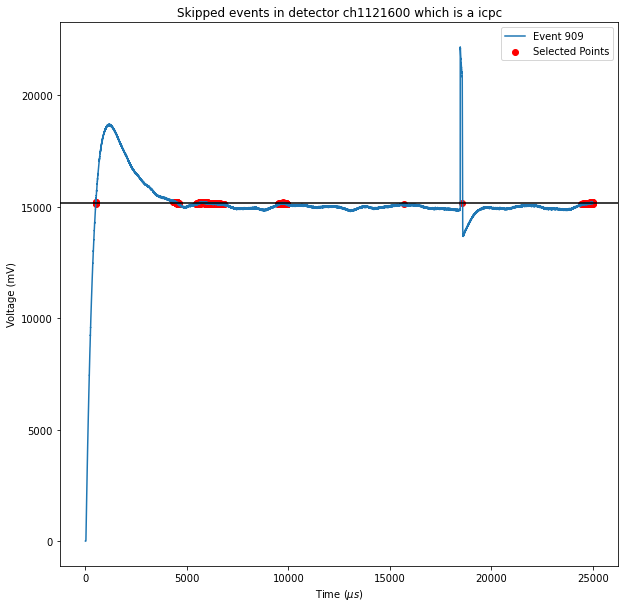

recovery rate 15318.400000000001s
DISCHARGE
Maximum difference: 10493.6, 15318.400000000001
Next maximum difference: 19822.4, 24408.0


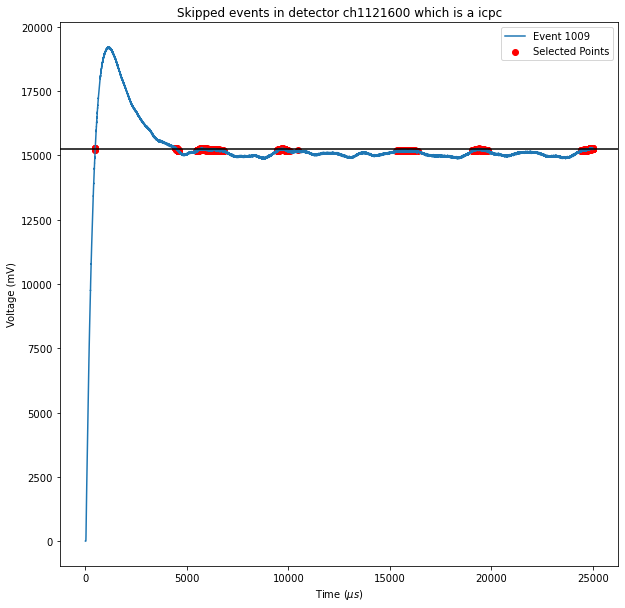

recovery rate 19233.600000000002s
DISCHARGE
Maximum difference: 9852.800000000001, 19233.600000000002
Next maximum difference: 19662.4, 24456.0


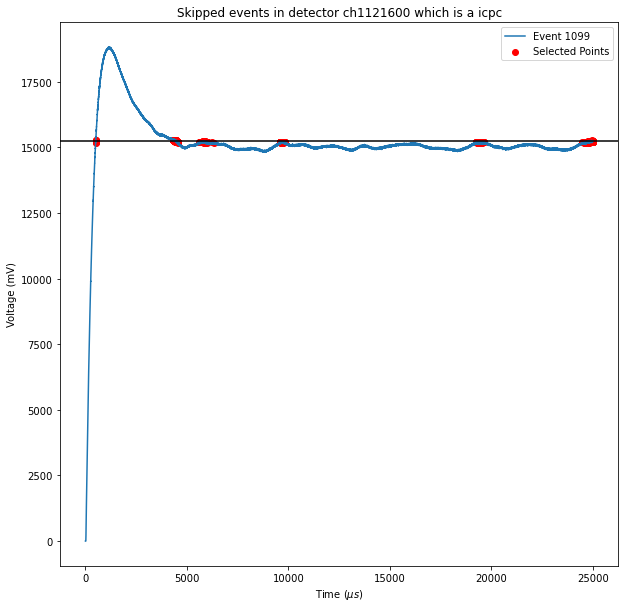

recovery rate 2123.2000000000007s
MICRODISCHARGE
Maximum difference: 11163.2, 12142.400000000001
Next Maximum difference: 10019.2, 10743.2


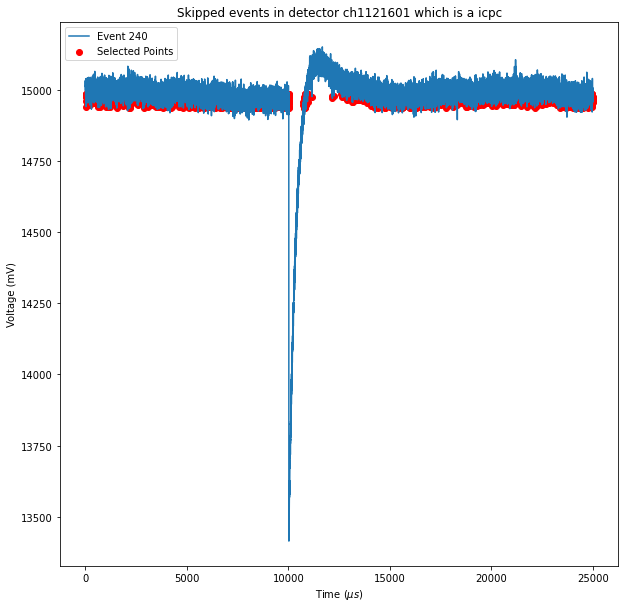

recovery rate 6415.200000000001s
DISCHARGE
Maximum difference: 376.8, 6415.200000000001
Next maximum difference: 7417.6, 7748.8


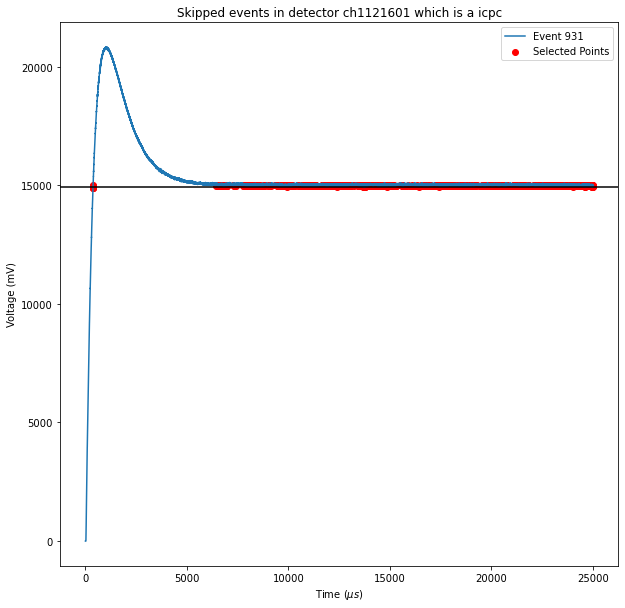

recovery rate 5013.6s
DISCHARGE
Maximum difference: 529.6, 5013.6
Next maximum difference: 15416.800000000001, 15672.800000000001


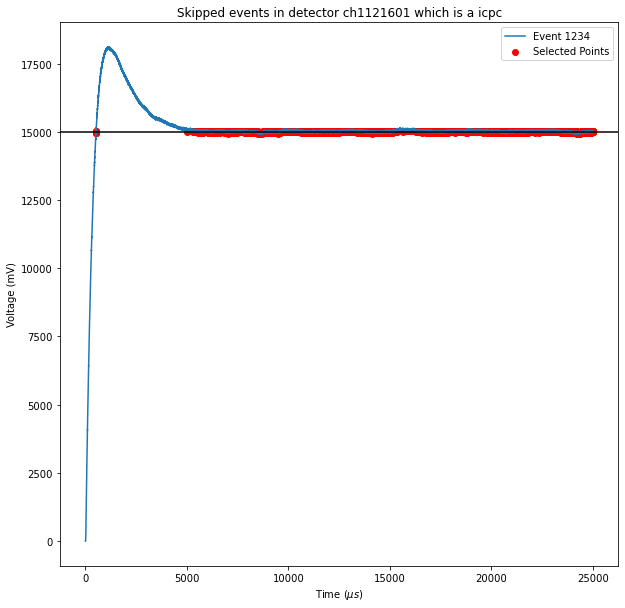

recovery rate 5169.6s
DISCHARGE
Maximum difference: 488.8, 5169.6
Next maximum difference: 5266.400000000001, 5332.0


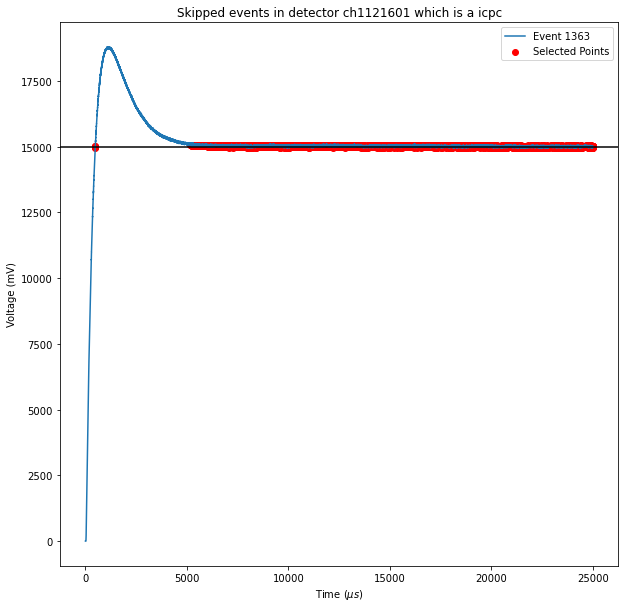

recovery rate 22599.2s
MICRODISCHARGE
Maximum difference: 5353.6, 22599.2
Next Maximum difference: 431.20000000000005, 3138.4


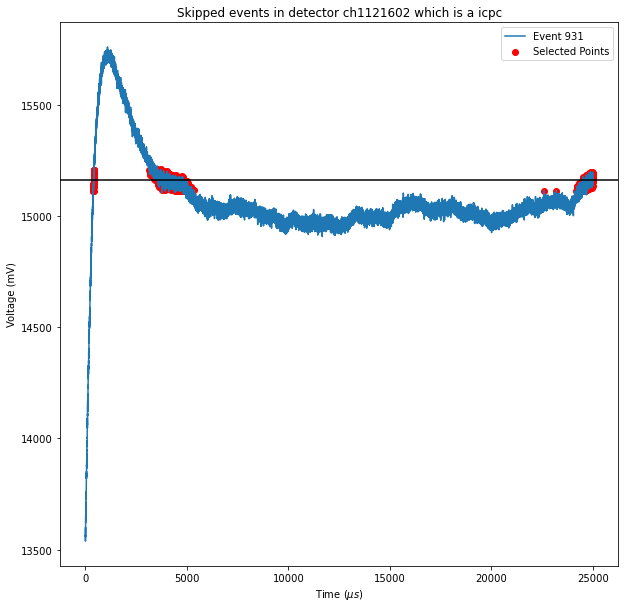

recovery rate 22676.800000000003s
MICRODISCHARGE
Maximum difference: 17308.0, 22676.800000000003
Next Maximum difference: 484.0, 5190.400000000001


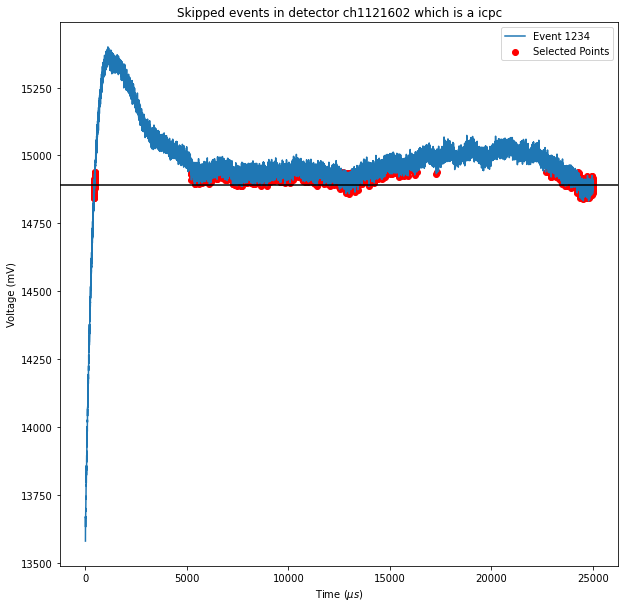

recovery rate 17429.600000000002s
MICRODISCHARGE
Maximum difference: 13398.400000000001, 17429.600000000002
Next Maximum difference: 532.0, 3572.0


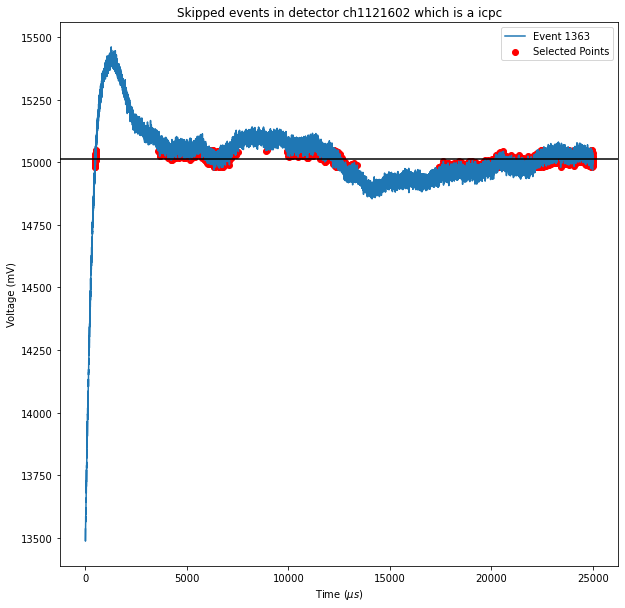

recovery rate 2986.4s
MICRODISCHARGE
Maximum difference: 208.8, 2986.4
Next Maximum difference: 3041.6000000000004, 3099.2000000000003


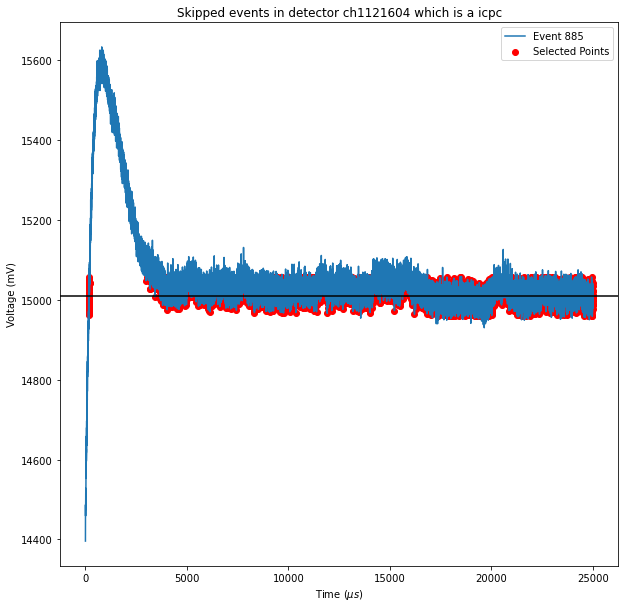

recovery rate 7028.799999999999s
MICRODISCHARGE
Maximum difference: 21403.2, 22284.0
Next Maximum difference: 15255.2, 15464.0


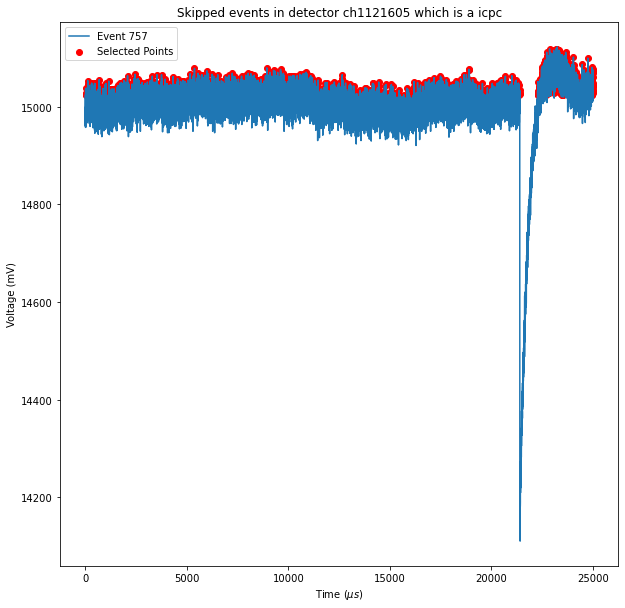

recovery rate 6515.200000000001s
DISCHARGE
Maximum difference: 331.20000000000005, 6515.200000000001
Next maximum difference: 7716.0, 7866.400000000001


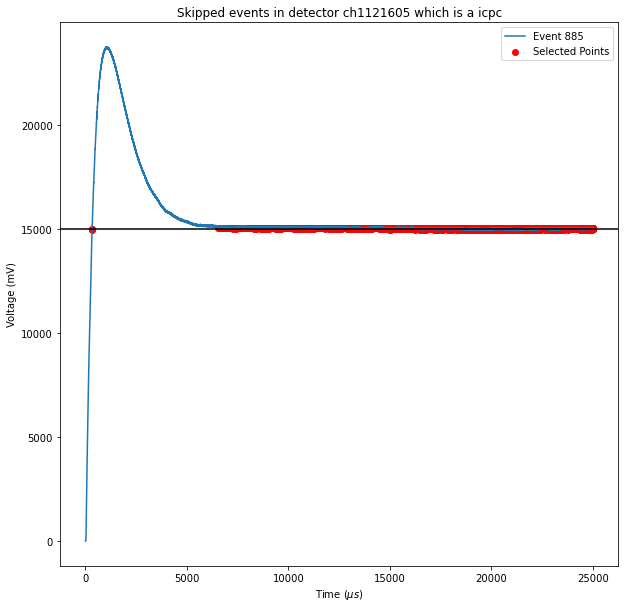

recovery rate -2836.8s
MICRODISCHARGE
Maximum difference: 5702.400000000001, 5746.400000000001
Next Maximum difference: 8583.2, 8622.4


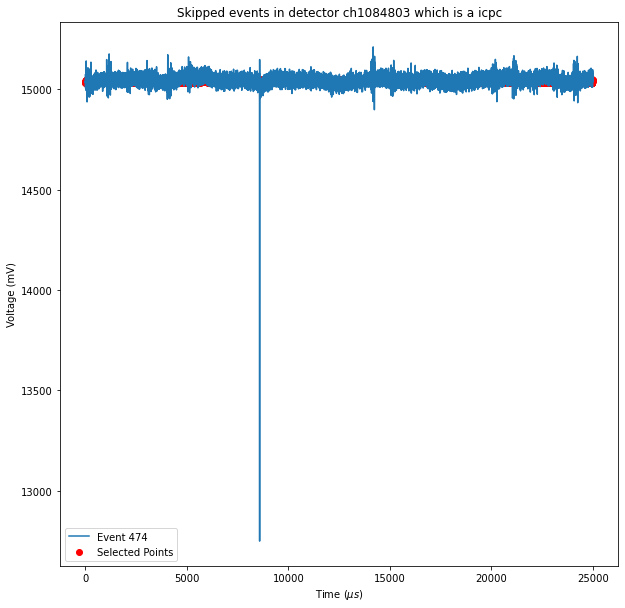

recovery rate 5948.0s
DISCHARGE
Maximum difference: 474.40000000000003, 5948.0
Next maximum difference: 5948.0, 6119.200000000001


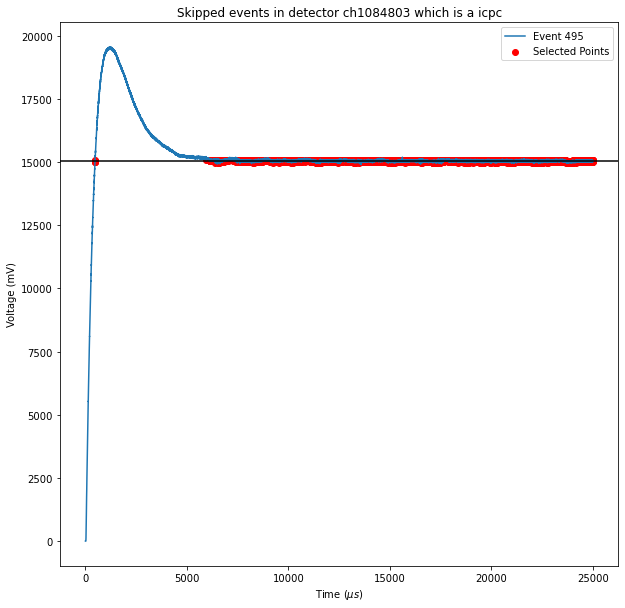

recovery rate 2258.3999999999996s
MICRODISCHARGE
Maximum difference: 9590.4, 10841.6
Next Maximum difference: 8583.2, 9311.2


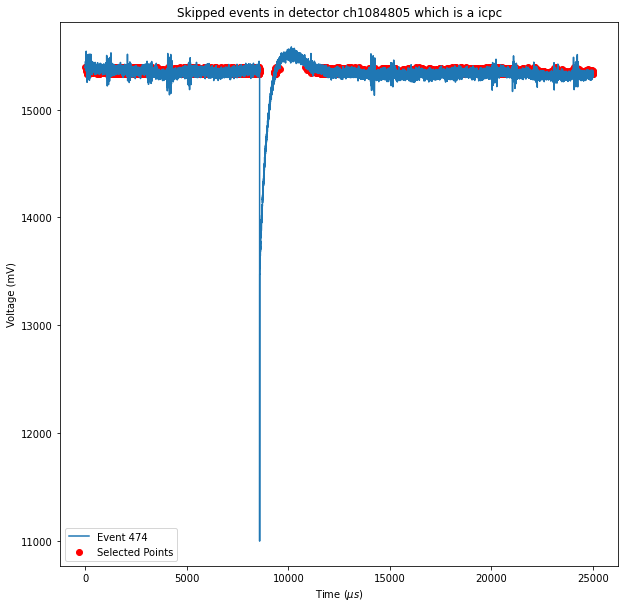

recovery rate 3116.0s
MICRODISCHARGE
Maximum difference: 10492.0, 12724.800000000001
Next Maximum difference: 9608.800000000001, 10356.800000000001


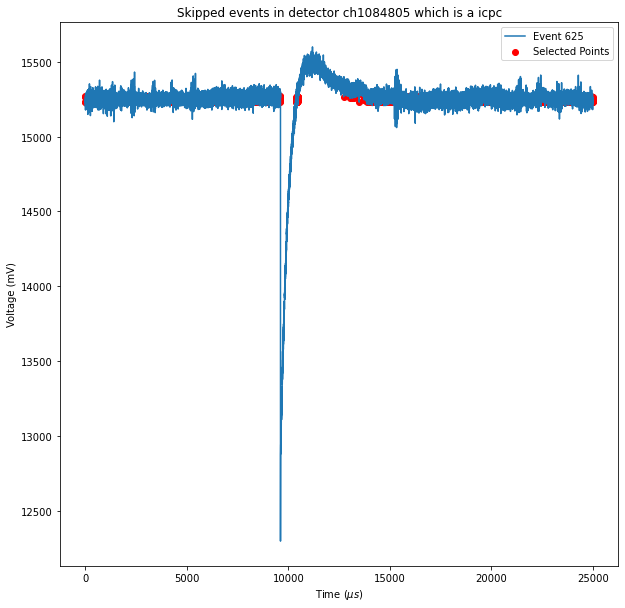

recovery rate 2395.2000000000007s
MICRODISCHARGE
Maximum difference: 14064.800000000001, 15000.800000000001
Next Maximum difference: 12605.6, 13389.6


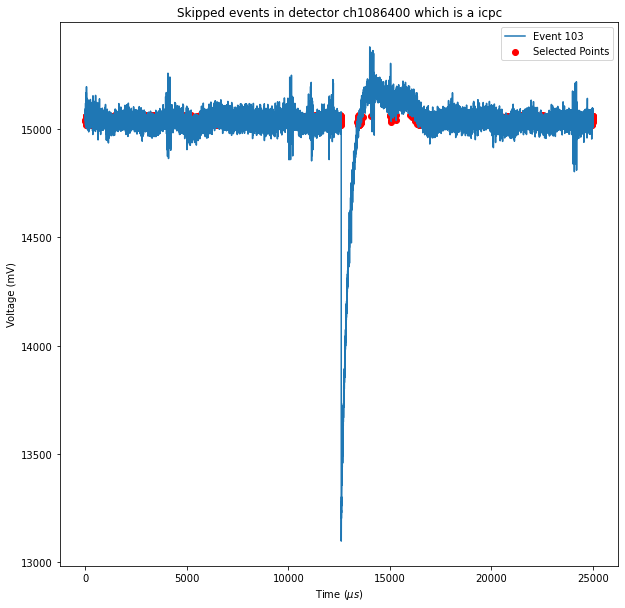

recovery rate 4960.0s
DISCHARGE
Maximum difference: 459.20000000000005, 4960.0
Next maximum difference: 5120.8, 5904.0


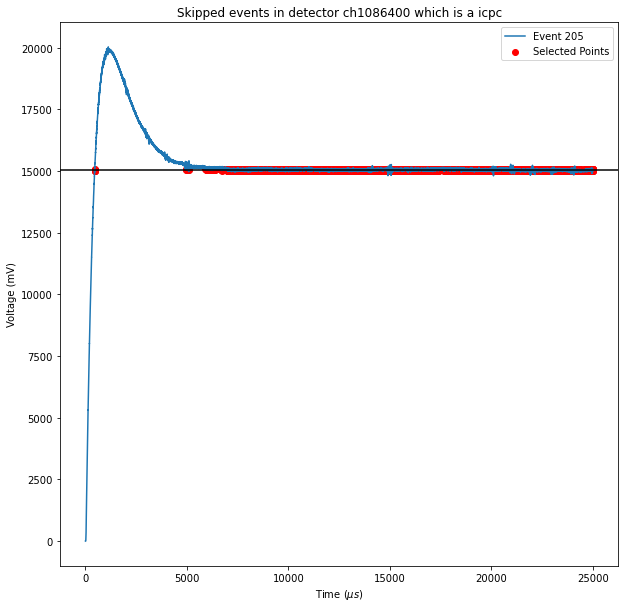

recovery rate 5065.6s
DISCHARGE
Maximum difference: 9432.0, 13648.0
Next maximum difference: 8582.4, 9422.4


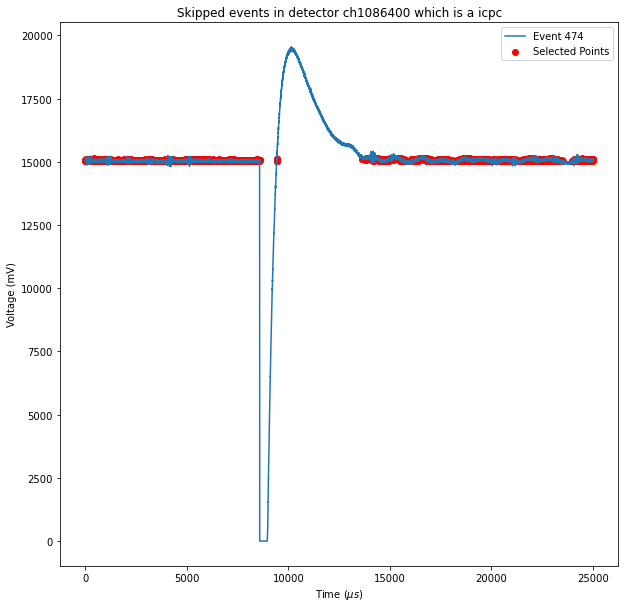

recovery rate 5892.8s
DISCHARGE
Maximum difference: 291.2, 5892.8
Next maximum difference: 5892.8, 5937.6


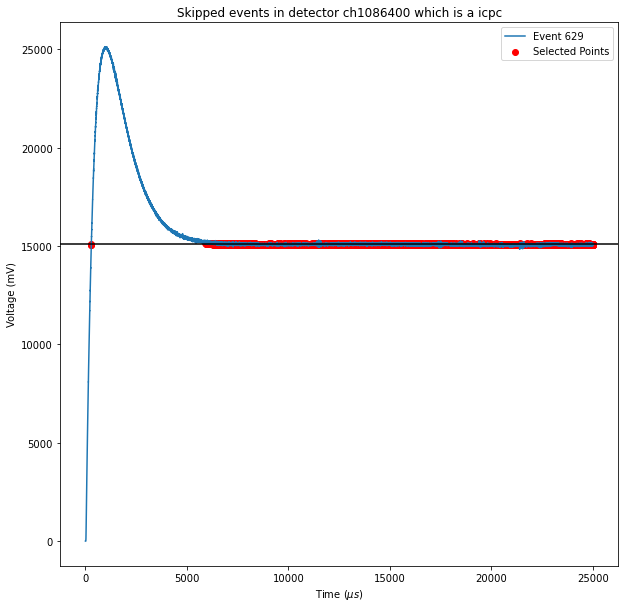

recovery rate 3189.6000000000004s
MICRODISCHARGE
Maximum difference: 348.0, 3189.6000000000004
Next Maximum difference: 3189.6000000000004, 3267.2000000000003


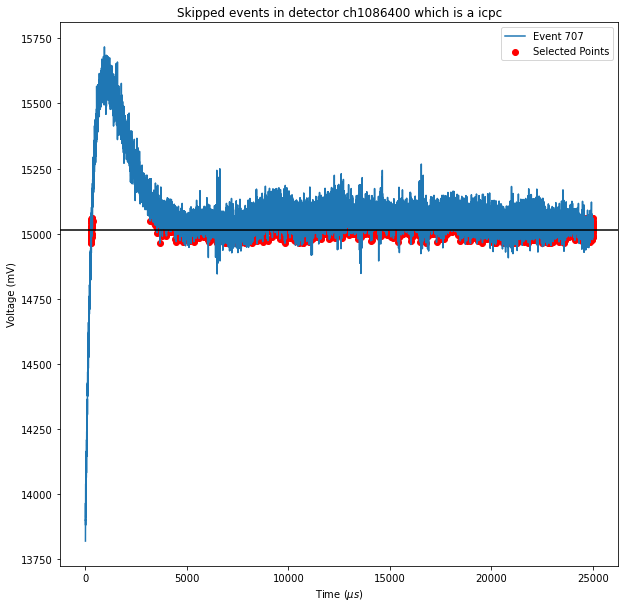

recovery rate 2176.8s
MICRODISCHARGE
Maximum difference: 505.6, 2176.8
Next Maximum difference: 2176.8, 2354.4


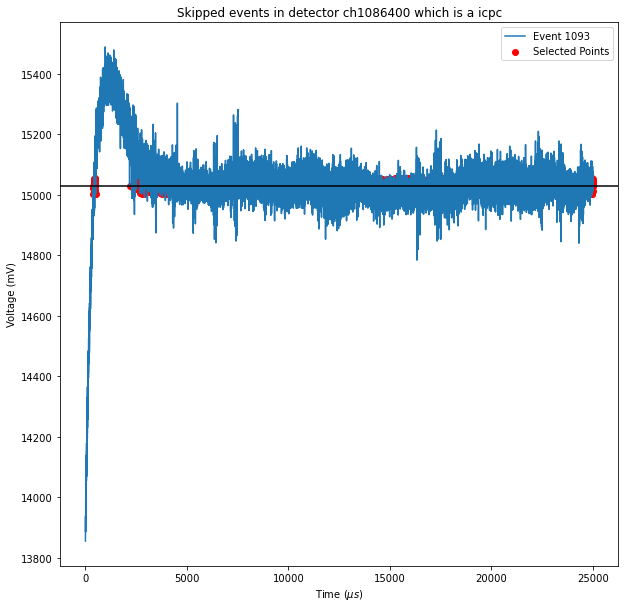

recovery rate 2488.8s
MICRODISCHARGE
Maximum difference: 7310.400000000001, 8833.6
Next Maximum difference: 6344.8, 7114.400000000001


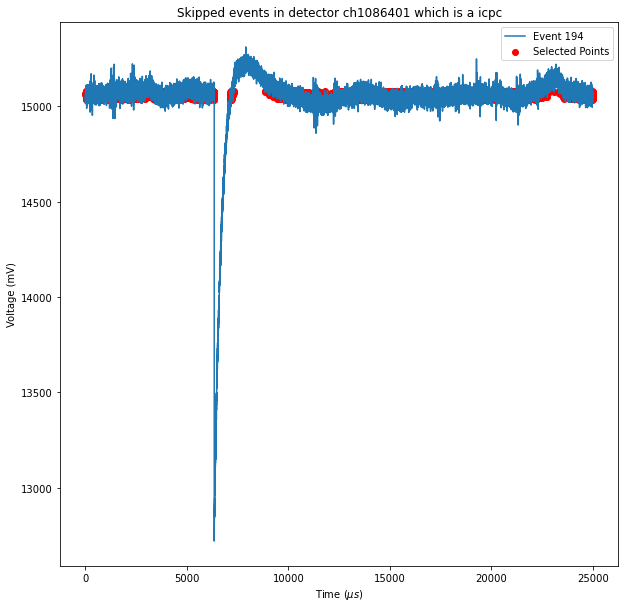

recovery rate 4690.400000000001s
DISCHARGE
Maximum difference: 530.4, 4690.400000000001
Next maximum difference: 4725.6, 4771.2


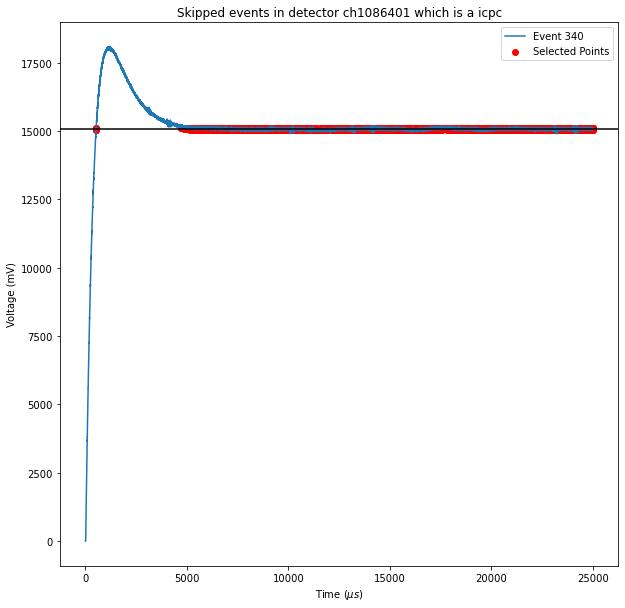

recovery rate -14708.800000000003s
MICRODISCHARGE
Maximum difference: 8582.4, 9060.0
Next Maximum difference: 23768.800000000003, 23945.600000000002


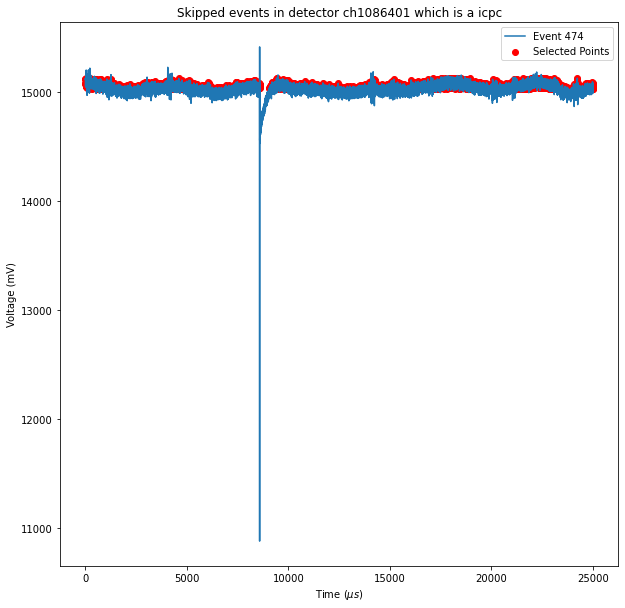

recovery rate 5045.6s
DISCHARGE
Maximum difference: 476.0, 5045.6
Next maximum difference: 5045.6, 5204.0


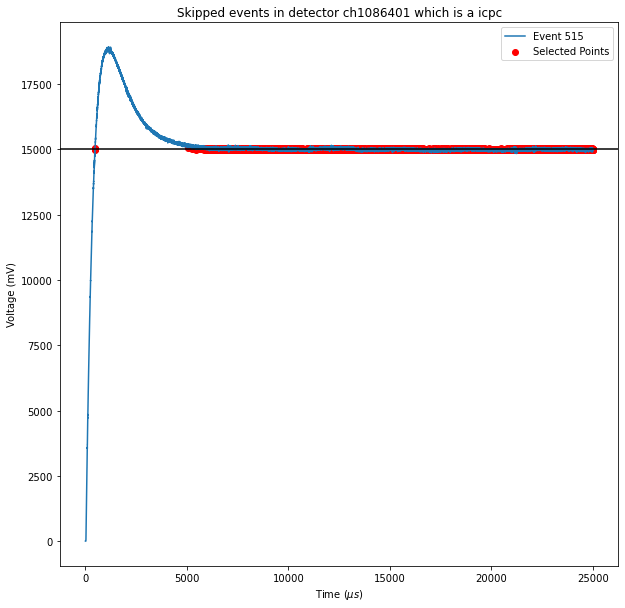

recovery rate 6135.200000000001s
DISCHARGE
Maximum difference: 290.40000000000003, 6135.200000000001
Next maximum difference: 8256.0, 9832.800000000001


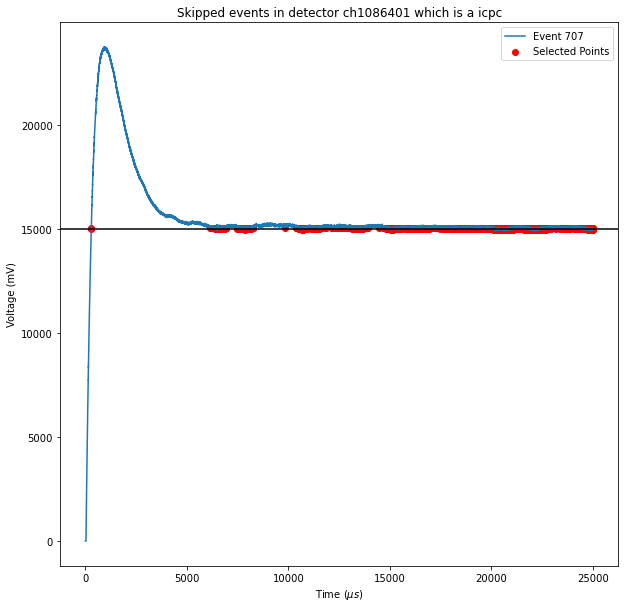

recovery rate 5372.8s
DISCHARGE
Maximum difference: 476.8, 5372.8
Next maximum difference: 5372.8, 5464.8


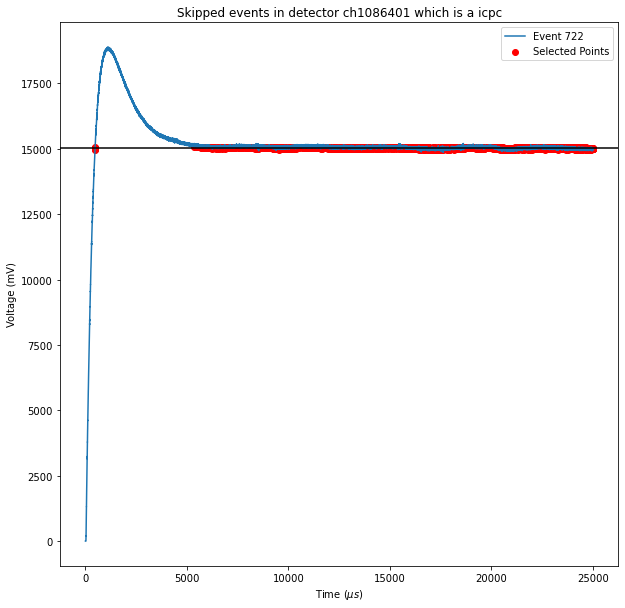

recovery rate 5256.0s
DISCHARGE
Maximum difference: 386.40000000000003, 5256.0
Next maximum difference: 5256.0, 5313.6


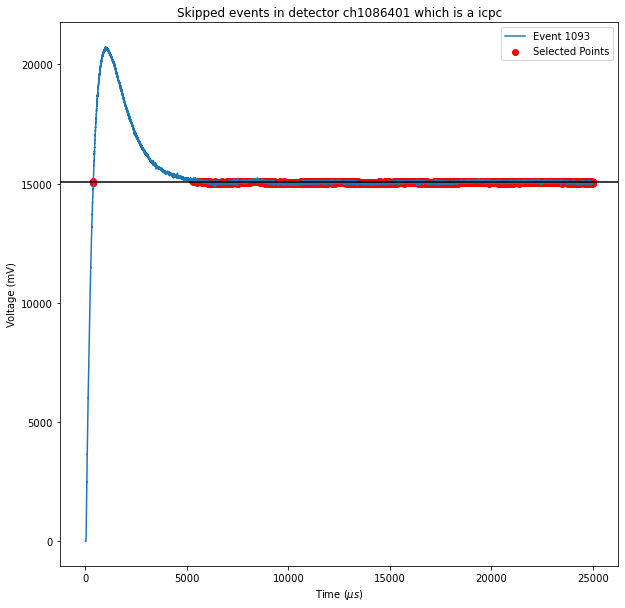

In [22]:
import pandas as pd

# Create an empty DataFrame to store the data
df = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate','Recovery Rate 2'])
df1 = pd.DataFrame(columns=['Detector Name', 'Event','Type', 'Recovery Rate','Recovery Rate 2'])


for j in detectors_bege:
    wfs_all = wfs_all_dict[j]
    index_skip1 = index_skipm[j]
    
    if len(index_skip1) < 20:
        for i in index_skip1:
            wf0 = wfs_all[i, :]
            mean_y = np.mean(wf0) 
            
            
            #weighted mean
            all_weight =[]
            for k in wf0:
                weight = abs(1/(k-mean_y))
                all_weight.append(weight)
                weighted_average = np.sum(k*weight)/np.sum(weight)
            
            ts = np.arange(0, wf0.shape[0], 1) * 0.8  # micro s 
            plt.plot(ts[:], wf0[:], label=f'Event {i}')
            
            for_append = []
            for_x = []
            for t, q in zip(ts, wf0):
                if weighted_average-51 < q < weighted_average+51:
                    for_x.append(t)
                    for_append.append(q)

            
            plt.scatter(for_x, for_append, color='r', label='Baseline Points')
            #differences between points along the baseline
            x_diff = [for_x[i+1] - for_x[i] for i in range(len(for_x)-1)]
            
            if len(x_diff)>0:#if there is a gap in the baseline we have a discharge
                #where does the maximum difference occur 
                max_diff_index = np.argmax(x_diff)
                
                
                masked_data = np.ma.masked_equal(x_diff, np.max(x_diff))
                #where does the next maximum difference occur
                next_max_index = np.argmax(masked_data)

                # indices above are used to determine the x point where the maximum occurs 
                max_diff_x1 = for_x[max_diff_index]
                max_diff_x2 = for_x[max_diff_index + 1]
                # indices above are used to determine the x point where the next maximum occurs
                max_diff_x3 = for_x[next_max_index]
                max_diff_x4 = for_x[next_max_index + 1]
               
                #if at t=0 the waveform is below the baseline
                # the recovery rate is as follows 
                if (wf0[0]<weighted_average):
                    rec_rate = max_diff_x2
                    print(f"recovery rate {rec_rate}s")
                    plt.axhline(y=weighted_average,color='k')
                else:#otherwise the recovery rate is as follows
                    rec_rate = max_diff_x2-max_diff_x3
                    print(f"recovery rate {rec_rate}s")
                    
                #--------------------------------------------------
                #ONLY KEY DIFFERENCE BETWEEN OTHER RECOVERY RATE NOTEBOOK 
                
                #if the recovery rate is negative or 0 this is a sign of a different shaped
                #dicsharge event
                if rec_rate<=0:
                    rec_rate = 0
                    rec_rate_2 = max_diff_x2-max_diff_x1
                
                #---------------------------------------------------
                
                #if at any point the waveform = 0 it is a discharge event 
                if np.any(wf0[:]==0):
                    discharge_type = "discharge"
                    print("DISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df = df.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate,
                        'Recovery Rate 2': rec_rate_2,
                    }, ignore_index=True)                    
                else:#if at any point ≠ 0 it is a microdischarge event
                    discharge_type = "microdischarge"
                    print("MICRODISCHARGE")
                    print(f"Maximum difference: {max_diff_x1}, {max_diff_x2}")
                    print(f"Next Maximum difference: {max_diff_x3}, {max_diff_x4}")
                    df1 = df1.append({
                        'Detector Name': j,
                        'Event':i,
                        'Type': discharge_type,
                        'Recovery Rate': rec_rate,
                        'Recovery Rate 2': rec_rate_2,
                    }, ignore_index=True)
            
            else:
                print("NO DISCHARGE")

            
            # Customize plot
            #plt.axhline(y=mean_y,color='lawngreen')
            #plt.axhline(y=weighted_average,color='k')
            plt.xlabel('Time ($\mu s$)')
            plt.ylabel('Voltage (mV)')
            plt.title(f'Skipped events in detector {j} which is a {test}')
            plt.legend()
            plt.show()

In [23]:
excel_filename = 'discharge_icpc.xlsx'
df.to_excel(excel_filename, index=False)

excel_filename1 = 'microdischarge_icpc.xlsx'
df1.to_excel(excel_filename1, index=False)